In [1]:
# import packages

# packages for data preparation and plotting
import pandas as pd
import os
import csv
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table
import holidays
import cftime
from netCDF4 import Dataset
import datetime as dt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams

# packages for modeling and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import Huber

from scipy.stats import kendalltau, spearmanr

# other
import warnings

In [2]:
# Data wrangling

In [3]:
# Load, inspect and clean the flight delay dataset

In [4]:
# loading and combining the flight data

warnings.filterwarnings("ignore")

flight_data = pd.DataFrame()

data_folder = "./flight_data"
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

for csv_file in csv_files:
    file_path = os.path.join(data_folder, csv_file)
    df = pd.read_csv(file_path)
    flight_data = flight_data.append(df, ignore_index=True)

flight_data

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY
0,4/1/2013 12:00:00 AM,9E,ALB,540,0.0,0.0,82.0,NaN,NaN
1,4/1/2013 12:00:00 AM,9E,ALB,925,0.0,0.0,95.0,NaN,NaN
2,4/1/2013 12:00:00 AM,9E,ALB,1240,0.0,0.0,84.0,NaN,NaN
3,4/1/2013 12:00:00 AM,9E,ALB,1410,0.0,0.0,83.0,NaN,NaN
4,4/1/2013 12:00:00 AM,9E,ALB,1630,0.0,0.0,90.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6107603,9/30/2022 12:00:00 AM,YX,STL,1836,2.0,0.0,123.0,NaN,NaN
6107604,9/30/2022 12:00:00 AM,YX,SYR,625,17.0,0.0,44.0,NaN,NaN
6107605,9/30/2022 12:00:00 AM,YX,SYR,1309,0.0,0.0,46.0,NaN,NaN
6107606,9/30/2022 12:00:00 AM,YX,XNA,620,0.0,0.0,151.0,NaN,NaN


In [5]:
# Filter for JFK airport

df_1 = flight_data[flight_data['ORIGIN'] == 'JFK']
df_1

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY
71,4/1/2013 12:00:00 AM,9E,JFK,755,0.0,0.0,93.0,NaN,NaN
72,4/1/2013 12:00:00 AM,9E,JFK,757,23.0,0.0,75.0,0.0,2.0
73,4/1/2013 12:00:00 AM,9E,JFK,805,0.0,0.0,97.0,NaN,NaN
74,4/1/2013 12:00:00 AM,9E,JFK,810,0.0,0.0,156.0,NaN,NaN
75,4/1/2013 12:00:00 AM,9E,JFK,815,0.0,0.0,125.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6107430,9/30/2022 12:00:00 AM,YX,JFK,2125,NaN,1.0,NaN,NaN,NaN
6107431,9/30/2022 12:00:00 AM,YX,JFK,2130,0.0,0.0,52.0,NaN,NaN
6107432,9/30/2022 12:00:00 AM,YX,JFK,2147,15.0,0.0,40.0,0.0,4.0
6107433,9/30/2022 12:00:00 AM,YX,JFK,2200,0.0,0.0,77.0,NaN,NaN


In [6]:
# Sorting by date

df_1['FL_DATE'] = pd.to_datetime(df_1['FL_DATE'])

df_1 = df_1.sort_values(by='FL_DATE')

df_1 = df_1.reset_index(drop=True)

df_1

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,NaN,NaN
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,NaN,NaN
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,NaN,NaN
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,NaN,NaN
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1129717,2023-08-31,B6,JFK,1555,0.0,0.0,118.0,NaN,NaN
1129718,2023-08-31,B6,JFK,1540,0.0,0.0,95.0,NaN,NaN
1129719,2023-08-31,B6,JFK,1530,0.0,0.0,110.0,NaN,NaN
1129720,2023-08-31,B6,JFK,2000,0.0,0.0,307.0,NaN,NaN


In [7]:
# Inspecting the data
# Inspecting null values

In [8]:
df_1.isnull().sum()

FL_DATE                   0
OP_UNIQUE_CARRIER         0
ORIGIN                    0
CRS_DEP_TIME              0
DEP_DELAY_NEW         25762
CANCELLED                 0
AIR_TIME              29839
WEATHER_DELAY        888519
NAS_DELAY            888519
dtype: int64

In [9]:
missing_values_rows = df_1[df_1['AIR_TIME'].isnull()]

# Display the rows with missing values in 'arr_flights'
print(missing_values_rows)

           FL_DATE OP_UNIQUE_CARRIER ORIGIN  CRS_DEP_TIME  DEP_DELAY_NEW  \
168     2013-01-01                B6    JFK           600            NaN   
204     2013-01-01                9E    JFK          1840           59.0   
367     2013-01-02                B6    JFK          2045            0.0   
491     2013-01-02                AA    JFK          1545            NaN   
524     2013-01-02                9E    JFK          1930            0.0   
...            ...               ...    ...           ...            ...   
1129355 2023-08-30                B6    JFK          1630            NaN   
1129356 2023-08-30                B6    JFK          1630            NaN   
1129619 2023-08-31                B6    JFK          2016            0.0   
1129668 2023-08-31                B6    JFK          1230            NaN   
1129679 2023-08-31                B6    JFK          1038            NaN   

         CANCELLED  AIR_TIME  WEATHER_DELAY  NAS_DELAY  
168            1.0       NaN  

In [10]:
df_1.dropna(subset=['AIR_TIME'], inplace=True)

In [11]:
# replace NaN values in a column with 0
df_1['DEP_DELAY_NEW'].fillna(0, inplace=True)

In [12]:
# replace NaN values in a column with 0
df_1['WEATHER_DELAY'].fillna(0, inplace=True)

In [13]:
# replace NaN values in a column with 0
df_1['NAS_DELAY'].fillna(0, inplace=True)

In [14]:
df_1

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1129717,2023-08-31,B6,JFK,1555,0.0,0.0,118.0,0.0,0.0
1129718,2023-08-31,B6,JFK,1540,0.0,0.0,95.0,0.0,0.0
1129719,2023-08-31,B6,JFK,1530,0.0,0.0,110.0,0.0,0.0
1129720,2023-08-31,B6,JFK,2000,0.0,0.0,307.0,0.0,0.0


In [15]:
df_1.dtypes

FL_DATE              datetime64[ns]
OP_UNIQUE_CARRIER            object
ORIGIN                       object
CRS_DEP_TIME                  int64
DEP_DELAY_NEW               float64
CANCELLED                   float64
AIR_TIME                    float64
WEATHER_DELAY               float64
NAS_DELAY                   float64
dtype: object

In [16]:
df_1.describe()

,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY
count,1.099883e+06,1.099883e+06,1099883.0,1.099883e+06,1.099883e+06,1.099883e+06
mean,1.373371e+03,1.569169e+01,0.0,1.839024e+02,8.590814e-01,4.152354e+00
std,4.897220e+02,4.783789e+01,0.0,1.135355e+02,1.430923e+01,1.953844e+01
min,2.500000e+01,0.000000e+00,0.0,2.000000e+01,0.000000e+00,0.000000e+00
25%,9.050000e+02,0.000000e+00,0.0,8.500000e+01,0.000000e+00,0.000000e+00
50%,1.430000e+03,0.000000e+00,0.0,1.500000e+02,0.000000e+00,0.000000e+00
75%,1.809000e+03,9.000000e+00,0.0,3.090000e+02,0.000000e+00,0.000000e+00
max,2.359000e+03,1.757000e+03,0.0,7.230000e+02,1.740000e+03,1.198000e+03


In [17]:
# Create a binary variable Delayed. Is 0 if on-time and is 1 if delayed.

df_1['Delayed'] = np.where((df_1['DEP_DELAY_NEW'] > 0) | (df_1['CANCELLED'] > 0), 1, 0)
df_1

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0,0
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0,0
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0,0
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0,0
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
1129717,2023-08-31,B6,JFK,1555,0.0,0.0,118.0,0.0,0.0,0
1129718,2023-08-31,B6,JFK,1540,0.0,0.0,95.0,0.0,0.0,0
1129719,2023-08-31,B6,JFK,1530,0.0,0.0,110.0,0.0,0.0,0
1129720,2023-08-31,B6,JFK,2000,0.0,0.0,307.0,0.0,0.0,0


In [18]:
# Create a binary variable Weather_Delayed. Is 0 if on-time and is 1 if delayed because of weather.

df_1['Weather_Delayed'] = np.where((df_1['WEATHER_DELAY'] > 0) | (df_1['NAS_DELAY'] > 0), 1, 0)
df_1

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed,Weather_Delayed
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0,0,0
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0,0,0
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0,0,0
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0,0,0
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1129717,2023-08-31,B6,JFK,1555,0.0,0.0,118.0,0.0,0.0,0,0
1129718,2023-08-31,B6,JFK,1540,0.0,0.0,95.0,0.0,0.0,0,0
1129719,2023-08-31,B6,JFK,1530,0.0,0.0,110.0,0.0,0.0,0,0
1129720,2023-08-31,B6,JFK,2000,0.0,0.0,307.0,0.0,0.0,0,0


In [19]:
# Add a column to classify whether the date is a weekday or weekend

# Create a custom function to classify the days
def classify_day_type(date):
    if date.weekday() < 5:  # 0-4 correspond to Monday to Friday
        return 'weekday'
    else:
        return 'weekend'

# Apply the function to create the "Day_Type" column
df_1['Day_Type'] = df_1['FL_DATE'].apply(classify_day_type)
df_1

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed,Weather_Delayed,Day_Type
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0,0,0,weekday
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0,0,0,weekday
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0,0,0,weekday
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0,0,0,weekday
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0,0,0,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...
1129717,2023-08-31,B6,JFK,1555,0.0,0.0,118.0,0.0,0.0,0,0,weekday
1129718,2023-08-31,B6,JFK,1540,0.0,0.0,95.0,0.0,0.0,0,0,weekday
1129719,2023-08-31,B6,JFK,1530,0.0,0.0,110.0,0.0,0.0,0,0,weekday
1129720,2023-08-31,B6,JFK,2000,0.0,0.0,307.0,0.0,0.0,0,0,weekday


In [20]:
df_1

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed,Weather_Delayed,Day_Type
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0,0,0,weekday
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0,0,0,weekday
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0,0,0,weekday
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0,0,0,weekday
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0,0,0,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...
1129717,2023-08-31,B6,JFK,1555,0.0,0.0,118.0,0.0,0.0,0,0,weekday
1129718,2023-08-31,B6,JFK,1540,0.0,0.0,95.0,0.0,0.0,0,0,weekday
1129719,2023-08-31,B6,JFK,1530,0.0,0.0,110.0,0.0,0.0,0,0,weekday
1129720,2023-08-31,B6,JFK,2000,0.0,0.0,307.0,0.0,0.0,0,0,weekday


In [21]:
# load, inspect and clean the ERA5 climate data

In [22]:
# wind data

In [23]:
# inspect dataset
wind_ds = nc.Dataset('./ERA5_data/ERA5_10mwindgust.nc', 'r')
wind_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-10-31 17:44:35 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data7/adaptor.mars.internal-1698770502.421442-14049-8-2de186f8-bedf-40df-9f0d-f7475b19d1fa.nc /cache/tmp/2de186f8-bedf-40df-9f0d-f7475b19d1fa-adaptor.mars.internal-1698764872.9100122-14049-7-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(94816)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 fg10(time, expver, latitude, longitude)
    groups: 

In [24]:
# List dimensions
print("Dimensions:")
for dimname, dimobj in wind_ds.dimensions.items():
    print(f"{dimname}: {len(dimobj)}")

# List variables
print("\nVariables:")
for varname, varobj in wind_ds.variables.items():
    print(f"{varname}: {varobj.shape} - {varobj.dtype}")

# List global attributes
print("\nGlobal Attributes:")
for attrname in wind_ds.ncattrs():
    print(f"{attrname}: {getattr(wind_ds, attrname)}")


Dimensions:
longitude: 1
latitude: 1
expver: 2
time: 94816

Variables:
longitude: (1,) - float32
latitude: (1,) - float32
expver: (2,) - int32
time: (94816,) - int32
fg10: (94816, 2, 1, 1) - int16

Global Attributes:
Conventions: CF-1.6
history: 2023-10-31 17:44:35 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data7/adaptor.mars.internal-1698770502.421442-14049-8-2de186f8-bedf-40df-9f0d-f7475b19d1fa.nc /cache/tmp/2de186f8-bedf-40df-9f0d-f7475b19d1fa-adaptor.mars.internal-1698764872.9100122-14049-7-tmp.grib


In [25]:
# Load the netCDF dataset
wind_ds = nc.Dataset('./ERA5_data/ERA5_10mwindgust.nc', 'r')

# Extract time and wind gust values
time_values = wind_ds.variables['time'][:]
wind_gust_values = wind_ds.variables['fg10'][:, :, 0, 0]

# Filter data until August 31, 2023
end_date = pd.to_datetime("2023-08-31")
filtered_indices = time_values <= pd.Timestamp(end_date).timestamp()

# Convert time values to a human-readable format
hours = time_values[filtered_indices] % 24
dates = pd.to_datetime(time_values[filtered_indices], unit='h', origin='1900-01-01')
dates += pd.to_timedelta(hours, unit='h')

# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Wind Gust': wind_gust_values[filtered_indices, 0]})

# Group by date and calculate both the maximum and average wind gust values for each day
df_2 = df.groupby(df['Date'].dt.date)['Wind Gust'].agg(['max', 'mean']).reset_index()
df_2.columns = ['Date', 'Max Wind Gust', 'Average Wind Gust']

# Print the DataFrame with both maximum and average wind gust values per day
print(df_2)


            Date  Max Wind Gust  Average Wind Gust
0     2013-01-01      11.181630          10.799783
1     2013-01-02      11.062606           9.729393
2     2013-01-03       9.990900           8.062486
3     2013-01-04      10.066462           8.093209
4     2013-01-05      12.933895          11.057853
...          ...            ...                ...
3947  2023-10-23            NaN                NaN
3948  2023-10-24            NaN                NaN
3949  2023-10-25            NaN                NaN
3950  2023-10-26            NaN                NaN
3951  2023-10-27            NaN                NaN

[3952 rows x 3 columns]


In [26]:
# Convert the 'Date' column to a datetime type (if it's not already)
df_2['Date'] = pd.to_datetime(df_2['Date'])

# Filter the DataFrame to include only rows until 2023-08-31
df_2 = df_2[df_2['Date'] <= '2023-08-31']
df_2

,Date,Max Wind Gust,Average Wind Gust
0,2013-01-01,11.181630,10.799783
1,2013-01-02,11.062606,9.729393
2,2013-01-03,9.990900,8.062486
3,2013-01-04,10.066462,8.093209
4,2013-01-05,12.933895,11.057853
...,...,...,...
3890,2023-08-27,6.373272,4.355673
3891,2023-08-28,7.750687,5.179188
3892,2023-08-29,8.806590,6.765388
3893,2023-08-30,8.030220,5.077388


In [27]:
# Merge the dataframes on the 'FL_DATE' and 'Date' columns
merged_df = df_1.merge(df_2, left_on='FL_DATE', right_on='Date', how='left')

# Drop the 'Date' column 
merged_df = merged_df.drop(columns=['Date'])

# Now, merged_df contains the Max Wind Gust and Average Wind Gust columns from df_2

In [28]:
merged_df

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed,Weather_Delayed,Day_Type,Max Wind Gust,Average Wind Gust
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0,0,0,weekday,11.181630,10.799783
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0,0,0,weekday,11.181630,10.799783
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0,0,0,weekday,11.181630,10.799783
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0,0,0,weekday,11.181630,10.799783
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0,0,0,weekday,11.181630,10.799783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099878,2023-08-31,B6,JFK,1555,0.0,0.0,118.0,0.0,0.0,0,0,weekday,10.386986,7.965358
1099879,2023-08-31,B6,JFK,1540,0.0,0.0,95.0,0.0,0.0,0,0,weekday,10.386986,7.965358
1099880,2023-08-31,B6,JFK,1530,0.0,0.0,110.0,0.0,0.0,0,0,weekday,10.386986,7.965358
1099881,2023-08-31,B6,JFK,2000,0.0,0.0,307.0,0.0,0.0,0,0,weekday,10.386986,7.965358


In [29]:
# max total precipitation

In [30]:
# inspect dataset
prec_ds = nc.Dataset('./ERA5_data/ERA5_maxtotalprec.nc', 'r')
prec_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-10-31 20:41:11 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data2/adaptor.mars.internal-1698780751.9158218-7392-3-05db907a-a342-4804-81e9-e4f054e97b93.nc /cache/tmp/05db907a-a342-4804-81e9-e4f054e97b93-adaptor.mars.internal-1698775037.1763122-7392-4-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(94818)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 mxtpr(time, expver, latitude, longitude)
    groups: 

In [31]:
# List dimensions
print("Dimensions:")
for dimname, dimobj in prec_ds.dimensions.items():
    print(f"{dimname}: {len(dimobj)}")

# List variables
print("\nVariables:")
for varname, varobj in prec_ds.variables.items():
    print(f"{varname}: {varobj.shape} - {varobj.dtype}")

# List global attributes
print("\nGlobal Attributes:")
for attrname in prec_ds.ncattrs():
    print(f"{attrname}: {getattr(prec_ds, attrname)}")

Dimensions:
longitude: 1
latitude: 1
expver: 2
time: 94818

Variables:
longitude: (1,) - float32
latitude: (1,) - float32
expver: (2,) - int32
time: (94818,) - int32
mxtpr: (94818, 2, 1, 1) - int16

Global Attributes:
Conventions: CF-1.6
history: 2023-10-31 20:41:11 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data2/adaptor.mars.internal-1698780751.9158218-7392-3-05db907a-a342-4804-81e9-e4f054e97b93.nc /cache/tmp/05db907a-a342-4804-81e9-e4f054e97b93-adaptor.mars.internal-1698775037.1763122-7392-4-tmp.grib


In [32]:
# Load the netCDF dataset
prec_ds = nc.Dataset('./ERA5_data/ERA5_maxtotalprec.nc', 'r')

# Extract time and wind gust values
time_values = prec_ds.variables['time'][:]
prec_values = prec_ds.variables['mxtpr'][:, :, 0, 0]

# Filter data until August 31, 2023
end_date = pd.to_datetime("2023-08-31")
filtered_indices = time_values <= pd.Timestamp(end_date).timestamp()

# Convert time values to a human-readable format (you can adjust this as needed)
hours = time_values[filtered_indices] % 24
dates = pd.to_datetime(time_values[filtered_indices], unit='h', origin='1900-01-01')
dates += pd.to_timedelta(hours, unit='h')

# Create a DataFrame
df_3 = pd.DataFrame({'Date': dates, 'Precipitation': prec_values[filtered_indices, 0]})

# Group by date and calculate both the maximum and average wind gust values for each day
df_3 = df_3.groupby(df_3['Date'].dt.date)['Precipitation'].agg(['max', 'mean']).reset_index()
df_3.columns = ['Date', 'Max Precipitation', 'Average Precipitation']

# Print the DataFrame with both maximum and average wind gust values per day
print(df_3)


            Date  Max Precipitation  Average Precipitation
0     2013-01-01       1.165386e-05           3.590825e-06
1     2013-01-02       1.361249e-05           1.085409e-06
2     2013-01-03      -4.336809e-19          -4.336809e-19
3     2013-01-04      -4.336809e-19          -4.336809e-19
4     2013-01-05      -4.336809e-19          -4.336809e-19
...          ...                ...                    ...
3947  2023-10-23                NaN                    NaN
3948  2023-10-24                NaN                    NaN
3949  2023-10-25                NaN                    NaN
3950  2023-10-26                NaN                    NaN
3951  2023-10-27                NaN                    NaN

[3952 rows x 3 columns]


In [33]:
# Convert the 'Date' column to a datetime type (if it's not already)
df_3['Date'] = pd.to_datetime(df_3['Date'])

# Filter the DataFrame to include only rows until 2023-08-31
df_3 = df_3[df_3['Date'] <= '2023-08-31']
df_3

,Date,Max Precipitation,Average Precipitation
0,2013-01-01,1.165386e-05,3.590825e-06
1,2013-01-02,1.361249e-05,1.085409e-06
2,2013-01-03,-4.336809e-19,-4.336809e-19
3,2013-01-04,-4.336809e-19,-4.336809e-19
4,2013-01-05,-4.336809e-19,-4.336809e-19
...,...,...,...
3890,2023-08-27,2.722498e-05,4.104966e-06
3891,2023-08-28,2.340565e-05,2.550302e-06
3892,2023-08-29,9.499365e-06,9.997184e-07
3893,2023-08-30,2.421848e-04,3.705895e-05


In [34]:
# Merge the dataframes on the 'FL_DATE' and 'Date' columns

df_3['Date'] = pd.to_datetime(df_3['Date'])
merged_df_2 = merged_df.merge(df_3, left_on='FL_DATE', right_on='Date', how='left')

# Drop the 'Date' column from the merged dataframe if you don't need it
merged_df_2 = merged_df_2.drop(columns=['Date'])

# Now, merged_df contains the Max Wind Gust and Average Wind Gust columns from df_2
merged_df_2

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed,Weather_Delayed,Day_Type,Max Wind Gust,Average Wind Gust,Max Precipitation,Average Precipitation
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,0.000004
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,0.000004
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,0.000004
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,0.000004
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099878,2023-08-31,B6,JFK,1555,0.0,0.0,118.0,0.0,0.0,0,0,weekday,10.386986,7.965358,0.000579,0.000050
1099879,2023-08-31,B6,JFK,1540,0.0,0.0,95.0,0.0,0.0,0,0,weekday,10.386986,7.965358,0.000579,0.000050
1099880,2023-08-31,B6,JFK,1530,0.0,0.0,110.0,0.0,0.0,0,0,weekday,10.386986,7.965358,0.000579,0.000050
1099881,2023-08-31,B6,JFK,2000,0.0,0.0,307.0,0.0,0.0,0,0,weekday,10.386986,7.965358,0.000579,0.000050


In [35]:
# max temperature

In [36]:
# inspect dataset
maxtemp_ds = nc.Dataset('./ERA5_data/ERA5_max2mtemp.nc', 'r')
maxtemp_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-10-29 21:00:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data6/adaptor.mars.internal-1698609322.2537086-18372-7-cb4694a4-d8db-4f7c-b17c-6b724b6945d4.nc /cache/tmp/cb4694a4-d8db-4f7c-b17c-6b724b6945d4-adaptor.mars.internal-1698603697.5047975-18372-12-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(94771)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 mx2t(time, expver, latitude, longitude)
    groups: 

In [37]:
# List dimensions
print("Dimensions:")
for dimname, dimobj in maxtemp_ds.dimensions.items():
    print(f"{dimname}: {len(dimobj)}")

# List variables
print("\nVariables:")
for varname, varobj in maxtemp_ds.variables.items():
    print(f"{varname}: {varobj.shape} - {varobj.dtype}")

# List global attributes
print("\nGlobal Attributes:")
for attrname in maxtemp_ds.ncattrs():
    print(f"{attrname}: {getattr(maxtemp_ds, attrname)}")


Dimensions:
longitude: 1
latitude: 1
expver: 2
time: 94771

Variables:
longitude: (1,) - float32
latitude: (1,) - float32
expver: (2,) - int32
time: (94771,) - int32
mx2t: (94771, 2, 1, 1) - int16

Global Attributes:
Conventions: CF-1.6
history: 2023-10-29 21:00:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data6/adaptor.mars.internal-1698609322.2537086-18372-7-cb4694a4-d8db-4f7c-b17c-6b724b6945d4.nc /cache/tmp/cb4694a4-d8db-4f7c-b17c-6b724b6945d4-adaptor.mars.internal-1698603697.5047975-18372-12-tmp.grib


In [38]:
# Load the netCDF dataset
maxtemp_ds = nc.Dataset('./ERA5_data/ERA5_max2mtemp.nc', 'r')

# Extract time and wind gust values
time_values = maxtemp_ds.variables['time'][:]
maxtemp_values = maxtemp_ds.variables['mx2t'][:, :, 0, 0]

# Filter data until August 31, 2023
end_date = pd.to_datetime("2023-08-31")
filtered_indices = time_values <= pd.Timestamp(end_date).timestamp()

# Convert time values to a human-readable format (you can adjust this as needed)
hours = time_values[filtered_indices] % 24
dates = pd.to_datetime(time_values[filtered_indices], unit='h', origin='1900-01-01')
dates += pd.to_timedelta(hours, unit='h')

# Create a DataFrame
df_4 = pd.DataFrame({'Date': dates, 'Max Temperature': maxtemp_values[filtered_indices, 0]})

# Group by date and calculate both the maximum and average wind gust values for each day
df_4 = df_4.groupby(df_4['Date'].dt.date)['Max Temperature'].agg(['max']).reset_index()
df_4.columns = ['Date', 'Max Temperature']

# Print the DataFrame with both maximum and average wind gust values per day
print(df_4)


            Date  Max Temperature
0     2013-01-01       276.518323
1     2013-01-02       277.604790
2     2013-01-03       273.417664
3     2013-01-04       273.696061
4     2013-01-05       276.370748
...          ...              ...
3945  2023-10-21              NaN
3946  2023-10-22              NaN
3947  2023-10-23              NaN
3948  2023-10-24              NaN
3949  2023-10-25              NaN

[3950 rows x 2 columns]


In [39]:
# Understand where NaN values start
first_nan_date = df_4[df_4['Max Temperature'].isna()]['Date'].iloc[0]

print("The NaN values start from:", first_nan_date)

The NaN values start from: 2023-08-02


In [40]:
# Convert the 'Date' column to a datetime type (if it's not already)
df_4['Date'] = pd.to_datetime(df_4['Date'])

# Filter the DataFrame to include only rows until 2023-08-31
df_4 = df_4[df_4['Date'] <= '2023-07-31']
df_4

,Date,Max Temperature
0,2013-01-01,276.518323
1,2013-01-02,277.604790
2,2013-01-03,273.417664
3,2013-01-04,273.696061
4,2013-01-05,276.370748
...,...,...
3859,2023-07-27,301.301262
3860,2023-07-28,304.053327
3861,2023-07-29,303.431121
3862,2023-07-30,303.735842


In [41]:
# Convert the temperature values to °C
df_4['Max Temperature (°C)'] = df_4['Max Temperature'] - 273.15

In [42]:
df_4

,Date,Max Temperature,Max Temperature (°C)
0,2013-01-01,276.518323,3.368323
1,2013-01-02,277.604790,4.454790
2,2013-01-03,273.417664,0.267664
3,2013-01-04,273.696061,0.546061
4,2013-01-05,276.370748,3.220748
...,...,...,...
3859,2023-07-27,301.301262,28.151262
3860,2023-07-28,304.053327,30.903327
3861,2023-07-29,303.431121,30.281121
3862,2023-07-30,303.735842,30.585842


In [43]:
# merge flight delay and temperature dataframes
import pandas as pd

merged_df_2['FL_DATE'] = pd.to_datetime(merged_df_2['FL_DATE'])  # Convert the 'FL_DATE' column to a datetime type
end_date = pd.to_datetime('2023-07-31')  # Define the end date

# Filter the DataFrame to keep only rows up to July 31, 2023
merged_df_2 = merged_df_2[merged_df_2['FL_DATE'] <= end_date]
merged_df_2

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed,Weather_Delayed,Day_Type,Max Wind Gust,Average Wind Gust,Max Precipitation,Average Precipitation
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088973,2023-07-31,YX,JFK,700,0.0,0.0,38.0,0.0,0.0,0,0,weekday,10.123752,6.171360,0.000014,9.221892e-07
1088974,2023-07-31,YX,JFK,635,0.0,0.0,76.0,0.0,0.0,0,0,weekday,10.123752,6.171360,0.000014,9.221892e-07
1088975,2023-07-31,YX,JFK,630,0.0,0.0,62.0,0.0,0.0,0,0,weekday,10.123752,6.171360,0.000014,9.221892e-07
1088976,2023-07-31,OO,JFK,1935,34.0,0.0,113.0,0.0,0.0,1,0,weekday,10.123752,6.171360,0.000014,9.221892e-07


In [44]:
# Merge the dataframes on the 'FL_DATE' and 'Date' columns
merged_df_3 = merged_df_2.merge(df_4, left_on='FL_DATE', right_on='Date', how='left')

# Drop the 'Date' column from the merged dataframe if you don't need it
merged_df_3 = merged_df_3.drop(columns=['Date'])

# Now, merged_df contains the Max Wind Gust and Average Wind Gust columns from df_2
merged_df_3

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed,Weather_Delayed,Day_Type,Max Wind Gust,Average Wind Gust,Max Precipitation,Average Precipitation,Max Temperature,Max Temperature (°C)
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0,0,0,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088973,2023-07-31,YX,JFK,700,0.0,0.0,38.0,0.0,0.0,0,0,weekday,10.123752,6.171360,0.000014,9.221892e-07,297.768250,24.618250
1088974,2023-07-31,YX,JFK,635,0.0,0.0,76.0,0.0,0.0,0,0,weekday,10.123752,6.171360,0.000014,9.221892e-07,297.768250,24.618250
1088975,2023-07-31,YX,JFK,630,0.0,0.0,62.0,0.0,0.0,0,0,weekday,10.123752,6.171360,0.000014,9.221892e-07,297.768250,24.618250
1088976,2023-07-31,OO,JFK,1935,34.0,0.0,113.0,0.0,0.0,1,0,weekday,10.123752,6.171360,0.000014,9.221892e-07,297.768250,24.618250


In [45]:
# min temperature

In [46]:
# inspect dataset
mintemp_ds = nc.Dataset('./ERA5_data/ERA5_min2mtemp.nc', 'r')
mintemp_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-10-29 23:29:34 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data8/adaptor.mars.internal-1698618712.080491-12717-3-d80d2bb4-b823-422d-8d42-002f95106a03.nc /cache/tmp/d80d2bb4-b823-422d-8d42-002f95106a03-adaptor.mars.internal-1698613678.2801728-12717-4-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(94774)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 mn2t(time, expver, latitude, longitude)
    groups: 

In [47]:
# List dimensions
print("Dimensions:")
for dimname, dimobj in mintemp_ds.dimensions.items():
    print(f"{dimname}: {len(dimobj)}")

# List variables
print("\nVariables:")
for varname, varobj in mintemp_ds.variables.items():
    print(f"{varname}: {varobj.shape} - {varobj.dtype}")

# List global attributes
print("\nGlobal Attributes:")
for attrname in mintemp_ds.ncattrs():
    print(f"{attrname}: {getattr(mintemp_ds, attrname)}")


Dimensions:
longitude: 1
latitude: 1
expver: 2
time: 94774

Variables:
longitude: (1,) - float32
latitude: (1,) - float32
expver: (2,) - int32
time: (94774,) - int32
mn2t: (94774, 2, 1, 1) - int16

Global Attributes:
Conventions: CF-1.6
history: 2023-10-29 23:29:34 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data8/adaptor.mars.internal-1698618712.080491-12717-3-d80d2bb4-b823-422d-8d42-002f95106a03.nc /cache/tmp/d80d2bb4-b823-422d-8d42-002f95106a03-adaptor.mars.internal-1698613678.2801728-12717-4-tmp.grib


In [48]:
# Load the netCDF dataset
mintemp_ds = nc.Dataset('./ERA5_data/ERA5_min2mtemp.nc', 'r')

# Extract time and wind gust values
time_values = mintemp_ds.variables['time'][:]
mintemp_values = mintemp_ds.variables['mn2t'][:, :, 0, 0]

# Filter data until August 31, 2023
end_date = pd.to_datetime("2023-08-31")
filtered_indices = time_values <= pd.Timestamp(end_date).timestamp()

# Convert time values to a human-readable format (you can adjust this as needed)
hours = time_values[filtered_indices] % 24
dates = pd.to_datetime(time_values[filtered_indices], unit='h', origin='1900-01-01')
dates += pd.to_timedelta(hours, unit='h')

# Create a DataFrame
df_5 = pd.DataFrame({'Date': dates, 'Min Temperature': mintemp_values[filtered_indices, 0]})

# Group by date and calculate both the maximum and average wind gust values for each day
df_5 = df_5.groupby(df_5['Date'].dt.date)['Min Temperature'].agg(['min']).reset_index()
df_5.columns = ['Date', 'Min Temperature']

# Print the DataFrame with both maximum and average wind gust values per day
print(df_5)


            Date  Min Temperature
0     2013-01-01       275.330232
1     2013-01-02       268.696546
2     2013-01-03       268.660571
3     2013-01-04       269.283329
4     2013-01-05       272.326767
...          ...              ...
3945  2023-10-21              NaN
3946  2023-10-22              NaN
3947  2023-10-23              NaN
3948  2023-10-24              NaN
3949  2023-10-25              NaN

[3950 rows x 2 columns]


In [49]:
# Convert the 'Date' column to a datetime type (if it's not already)
df_5['Date'] = pd.to_datetime(df_5['Date'])

# Filter the DataFrame to include only rows until 2023-08-31
df_5 = df_5[df_5['Date'] <= '2023-07-31']
df_5

,Date,Min Temperature
0,2013-01-01,275.330232
1,2013-01-02,268.696546
2,2013-01-03,268.660571
3,2013-01-04,269.283329
4,2013-01-05,272.326767
...,...,...
3859,2023-07-27,293.590858
3860,2023-07-28,296.676665
3861,2023-07-29,297.832644
3862,2023-07-30,292.359732


In [50]:
# Change temeprature values to °C
df_5['Min Temperature (°C)'] = df_5['Min Temperature'] - 273.15

In [51]:
df_5

,Date,Min Temperature,Min Temperature (°C)
0,2013-01-01,275.330232,2.180232
1,2013-01-02,268.696546,-4.453454
2,2013-01-03,268.660571,-4.489429
3,2013-01-04,269.283329,-3.866671
4,2013-01-05,272.326767,-0.823233
...,...,...,...
3859,2023-07-27,293.590858,20.440858
3860,2023-07-28,296.676665,23.526665
3861,2023-07-29,297.832644,24.682644
3862,2023-07-30,292.359732,19.209732


In [52]:
# Merge the dataframes on the 'FL_DATE' and 'Date' columns
merged_df_4 = merged_df_3.merge(df_5, left_on='FL_DATE', right_on='Date', how='left')

# Add a column for weather delay cost
merged_df_4['Estimated_Weather_Delay_Cost'] = merged_df_4['WEATHER_DELAY'] * 101.18 + merged_df_4['NAS_DELAY'] * 101.18

# create a new dataframe that can be used later on
merged_df_5 = merged_df_4

# Drop the 'Date' column from the merged dataframe if you don't need it
merged_df_4 = merged_df_4.drop(columns=['Date'])

# Now, merged_df contains the Max Wind Gust and Average Wind Gust columns from df_2
merged_df_4

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed,...,Day_Type,Max Wind Gust,Average Wind Gust,Max Precipitation,Average Precipitation,Max Temperature,Max Temperature (°C),Min Temperature,Min Temperature (°C),Estimated_Weather_Delay_Cost
0,2013-01-01,DL,JFK,1740,0.0,0.0,341.0,0.0,0.0,0,...,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323,275.330232,2.180232,0.0
1,2013-01-01,DL,JFK,820,0.0,0.0,182.0,0.0,0.0,0,...,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323,275.330232,2.180232,0.0
2,2013-01-01,DL,JFK,810,0.0,0.0,147.0,0.0,0.0,0,...,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323,275.330232,2.180232,0.0
3,2013-01-01,DL,JFK,810,0.0,0.0,126.0,0.0,0.0,0,...,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323,275.330232,2.180232,0.0
4,2013-01-01,DL,JFK,800,0.0,0.0,158.0,0.0,0.0,0,...,weekday,11.181630,10.799783,0.000012,3.590825e-06,276.518323,3.368323,275.330232,2.180232,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088973,2023-07-31,YX,JFK,700,0.0,0.0,38.0,0.0,0.0,0,...,weekday,10.123752,6.171360,0.000014,9.221892e-07,297.768250,24.618250,292.363729,19.213729,0.0
1088974,2023-07-31,YX,JFK,635,0.0,0.0,76.0,0.0,0.0,0,...,weekday,10.123752,6.171360,0.000014,9.221892e-07,297.768250,24.618250,292.363729,19.213729,0.0
1088975,2023-07-31,YX,JFK,630,0.0,0.0,62.0,0.0,0.0,0,...,weekday,10.123752,6.171360,0.000014,9.221892e-07,297.768250,24.618250,292.363729,19.213729,0.0
1088976,2023-07-31,OO,JFK,1935,34.0,0.0,113.0,0.0,0.0,1,...,weekday,10.123752,6.171360,0.000014,9.221892e-07,297.768250,24.618250,292.363729,19.213729,0.0


In [53]:
# Drop unnecessary columns
merged_df_4.drop(columns=['Max Temperature', 'Min Temperature'], inplace=True)

In [54]:
# Add delay cost data

In [55]:
# Add a column for delay cost
#In 2022, the average cost of aircraft block (taxi plus airborne) time for U.S. passenger airlines was $101.18 per minute

merged_df_4['Estimated_Delay_Cost'] = merged_df_4['DEP_DELAY_NEW'] * 101.18

In [56]:
# Optimize the dataframe for machine learning

In [57]:
# Filter rows where the 'FL_DATE' is before 2022
merged_df_4 = merged_df_4[merged_df_4['FL_DATE'].dt.year < 2022]

In [58]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column
merged_df_4['DOY'] = pd.to_datetime(merged_df_4['FL_DATE']).dt.dayofyear
merged_df_4 = merged_df_4.drop(columns=['FL_DATE'])  # Remove the original 'FL_DATE' column

In [59]:
columns_to_drop = ['CANCELLED', 'ORIGIN', 'DEP_DELAY_NEW', 'WEATHER_DELAY', 'NAS_DELAY', 'Delayed', 'Estimated_Delay_Cost', 'Delayed', 'Max Wind Gust','Max Precipitation']
merged_df_4 = merged_df_4.drop(columns_to_drop, axis=1)

In [60]:
merged_df_4

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Weather_Delayed,Day_Type,Average Wind Gust,Average Precipitation,Max Temperature (°C),Min Temperature (°C),Estimated_Weather_Delay_Cost,DOY
0,DL,1740,341.0,0,weekday,10.799783,0.000004,3.368323,2.180232,0.00,1
1,DL,820,182.0,0,weekday,10.799783,0.000004,3.368323,2.180232,0.00,1
2,DL,810,147.0,0,weekday,10.799783,0.000004,3.368323,2.180232,0.00,1
3,DL,810,126.0,0,weekday,10.799783,0.000004,3.368323,2.180232,0.00,1
4,DL,800,158.0,0,weekday,10.799783,0.000004,3.368323,2.180232,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
880788,B6,800,383.0,1,weekday,3.364571,0.000012,8.840544,6.205372,3237.76,365
880789,B6,800,99.0,0,weekday,3.364571,0.000012,8.840544,6.205372,0.00,365
880790,B6,800,396.0,0,weekday,3.364571,0.000012,8.840544,6.205372,0.00,365
880791,B6,800,150.0,0,weekday,3.364571,0.000012,8.840544,6.205372,0.00,365


In [61]:
# Plots for inspection of variable relationships

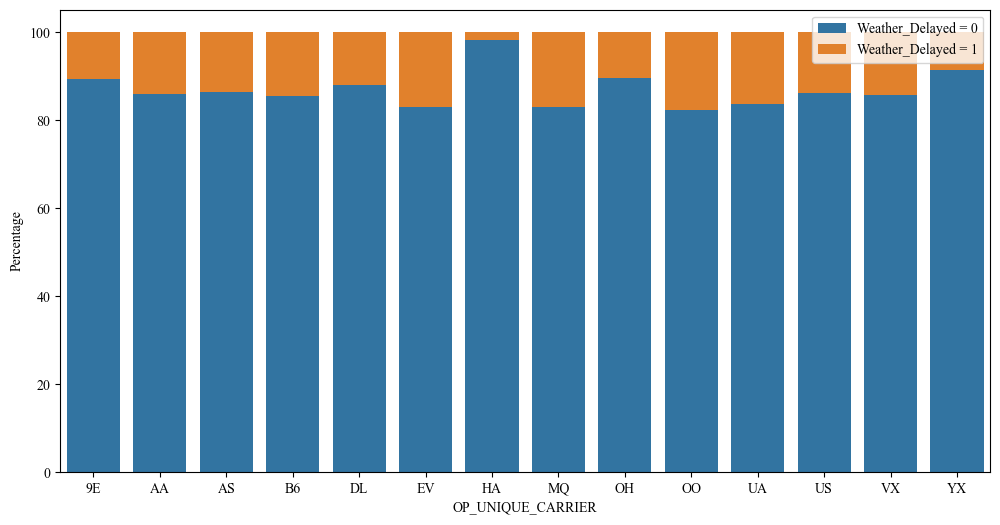

In [62]:
# plot percentage of weather delayed flights by carrier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Calculate the percentage of Weather_Delayed being 0 and 1 for each OP_UNIQUE_CARRIER
carrier_percentage = merged_df_4.groupby(['OP_UNIQUE_CARRIER', 'Weather_Delayed']).size().unstack(fill_value=0)
carrier_percentage['Total'] = carrier_percentage[0] + carrier_percentage[1]
carrier_percentage['Percentage_0'] = (carrier_percentage[0] / carrier_percentage['Total']) * 100
carrier_percentage['Percentage_1'] = (carrier_percentage[1] / carrier_percentage['Total']) * 100

# Plot the percentage bar plots with total adding up to 100%
plt.figure(figsize=(12, 6))
sns.barplot(x='OP_UNIQUE_CARRIER', y='Percentage_0', data=carrier_percentage.reset_index(), color='#1f78b4', label='Weather_Delayed = 0')
sns.barplot(x='OP_UNIQUE_CARRIER', y='Percentage_1', data=carrier_percentage.reset_index(), color='#ff7f0e', bottom=carrier_percentage['Percentage_0'], label='Weather_Delayed = 1')
plt.xlabel('OP_UNIQUE_CARRIER')
plt.ylabel('Percentage')
plt.legend()
plt.show()


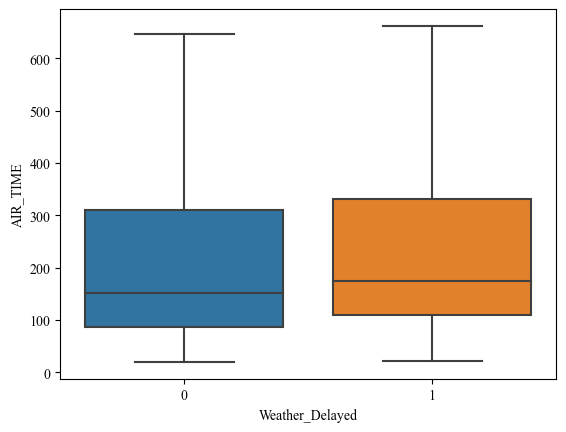

In [63]:
# plot the relationship of airtime and flight status
import seaborn as sns
import matplotlib.pyplot as plt

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

sns.boxplot(x='Weather_Delayed', y='AIR_TIME', data=merged_df_4, showfliers=False)
plt.xlabel('Weather_Delayed')
plt.ylabel('AIR_TIME')
plt.show()


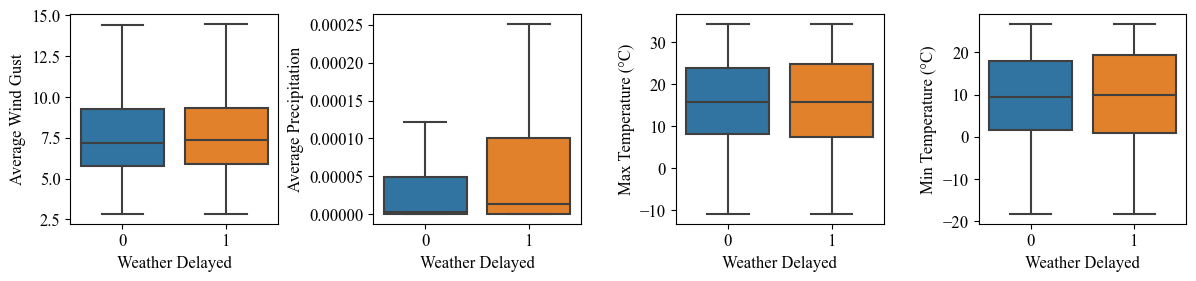

In [64]:
# Plot the relationships of weather variables and fligth status
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Set the font to Times New Roman
rcParams['font.family'] = 'times new roman'
rcParams['font.size'] = 12

# Filter the DataFrame to include only the relevant columns for boxplots
relevant_columns = [
    "Average Wind Gust",
    "Average Precipitation",
    "Max Temperature (°C)",
    "Min Temperature (°C)"
]

# Create subplots for boxplots without outliers
plt.figure(figsize=(12, 8))
for i, column in enumerate(relevant_columns):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=merged_df_4["Weather_Delayed"], y=merged_df_4[column], showfliers=False)

    # Set the x-axis and y-axis labels with Times New Roman font
    plt.xlabel("Weather Delayed", fontdict={'family': 'times new roman', 'size': 12})
    plt.ylabel(column, fontdict={'family': 'times new roman', 'size': 12})
    
plt.tight_layout()
plt.show()


In [65]:
# Plot the minimum and maximum values of the weather variables

In [66]:
merged_df_4['Average Wind Gust'].min()

2.8141485773611836

In [67]:
merged_df_4['Average Wind Gust'].max()

20.571183278717342

In [68]:
merged_df_4['Min Temperature (°C)'].min()

-18.28282775878904

In [69]:
merged_df_4['Min Temperature (°C)'].max()

26.747576354837975

In [70]:
merged_df_4['Max Temperature (°C)'].min()

-10.98548844179868

In [71]:
merged_df_4['Max Temperature (°C)'].max()

34.38369140625002

In [72]:
merged_df_4['Average Precipitation'].min()

-4.336808689942018e-19

In [73]:
merged_df_4['Average Precipitation'].max()

0.0010386217074563784

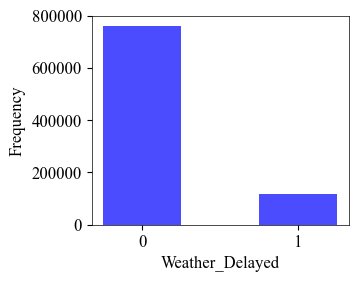

In [74]:
# Plot the balance of flights that are delayed vs on-time
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the font to Times New Roman
rcParams['font.family'] = 'times new roman'

# Filter the DataFrame to include only the relevant columns for histograms
relevant_columns = ["Weather_Delayed"]

# Create subplots for histograms
plt.figure(figsize=(12, 8), facecolor='white')  # Set the background color to white

for i, column in enumerate(relevant_columns):
    ax = plt.subplot(3, 4, i+1)
    plt.hist(merged_df_4[column], bins=[-0.25, 0.25, 0.75, 1.25], color='blue', alpha=0.7)
    
    # Set the frame (spines) to black and make them thinner
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)  # Adjust the line width for the frame
    
    # Set the x-axis and y-axis labels
    ax.set_xlabel(column, color='black', fontdict={'fontsize': 12})  # Set the x-axis label and color
    ax.set_ylabel("Frequency", color='black', fontdict={'fontsize': 12})  # Set the y-axis label and color

    # Set x-axis ticks to only 0 and 1
    ax.set_xticks([0, 1])  
    ax.set_xticklabels([0, 1])  # Set the x-axis tick labels
    
    plt.grid(False)  # Remove the grid

plt.tight_layout()

# Save the figure as a picture (e.g., histogram.png)
plt.savefig("histogram.png", facecolor='white')  # Set the background color when saving

# Display the figure (optional)
plt.show()


In [75]:
(merged_df_4["Weather_Delayed"] == 0).sum()

762128

In [76]:
(merged_df_4["Weather_Delayed"] == 1).sum()

118665

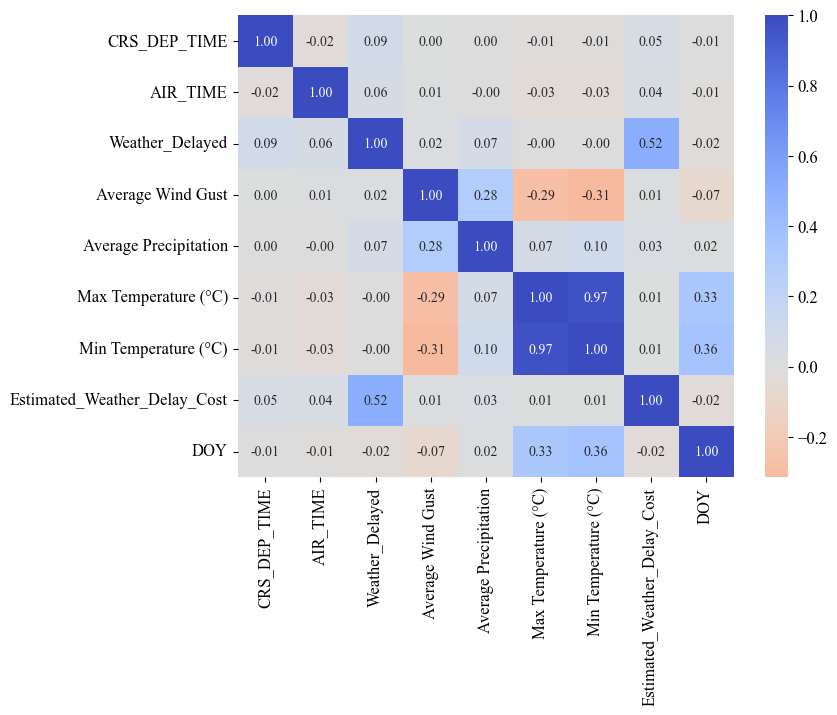

In [77]:
# plot the correlation of variables
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Compute the correlation matrix
correlation_matrix = merged_df_4.corr()

# Create a heatmap with non-overlapping annotations and a title
plt.figure(figsize=(8, 6))  # Reduce the figure size

# Set the annot parameter to display values in each cell
# Use a diverging color map with red for positive values, blue for negative values, and center at 0 (white)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm_r', center=0, annot_kws={"size": 10})

# Save the plot as a picture with higher resolution (e.g., correlation_matrix.png)
plt.savefig("correlation_matrix.png", dpi=50)  # Adjust the DPI as needed

plt.show()


In [78]:
# Machine learning models

In [79]:
# Data preprocessing

In [80]:
#prepare data for modeling

# Select input features and target variable
selected_features = [
    'DOY', 'OP_UNIQUE_CARRIER', 'CRS_DEP_TIME', 'AIR_TIME', 'Day_Type',
    'Average Wind Gust', 'Average Precipitation', 'Min Temperature (°C)'
]
X = merged_df_4[selected_features]
y = merged_df_4['Weather_Delayed']

# Separate numerical and categorical columns
numerical_cols = ['CRS_DEP_TIME', 'AIR_TIME', 'Average Wind Gust', 'Average Precipitation', 'Min Temperature (°C)', 'DOY']
categorical_cols = ['OP_UNIQUE_CARRIER', 'Day_Type']

# Standardize numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Handle categorical features with one-hot encoding
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(X[categorical_cols])
feature_names = encoder.get_feature_names_out(input_features=categorical_cols)
X_encoded = pd.DataFrame(X_encoded, columns=feature_names)
X = pd.concat([X.drop(columns=categorical_cols), X_encoded], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Create a logistic regression model

In [82]:
# Address class imbalance using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


# Create new interaction terms for the training set
for carrier in ['AA', 'AS', 'B6', 'DL', 'EV', 'HA', 'MQ', 'OH', 'OO', 'UA', 'US', 'VX', 'YX']:
    X_train_resampled[f'OP_CARRIER_DEP_TIME_Interact_{carrier}'] = X_train_resampled[f'OP_UNIQUE_CARRIER_{carrier}'] * X_train_resampled['CRS_DEP_TIME']
    X_train_resampled[f'OP_CARRIER_AIR_TIME_Interact_{carrier}'] = X_train_resampled[f'OP_UNIQUE_CARRIER_{carrier}'] * X_train_resampled['AIR_TIME']

# Create new interaction terms for the test set
for carrier in ['AA', 'AS', 'B6', 'DL', 'EV', 'HA', 'MQ', 'OH', 'OO', 'UA', 'US', 'VX', 'YX']:
    X_test[f'OP_CARRIER_DEP_TIME_Interact_{carrier}'] = X_test[f'OP_UNIQUE_CARRIER_{carrier}'] * X_test['CRS_DEP_TIME']
    X_test[f'OP_CARRIER_AIR_TIME_Interact_{carrier}'] = X_test[f'OP_UNIQUE_CARRIER_{carrier}'] * X_test['AIR_TIME']


# Model 

# Define fixed hyperparameters for the logistic regression model
logistic_params = {
     'C': 1000,  # Regularization parameter
    'max_iter': 500  # Maximum number of iterations
}

# Initialize the logistic regression model with fixed hyperparameters
model = LogisticRegression(**logistic_params)

# Define StratifiedKFold with 3 folds
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize lists to store evaluation results for each fold
accuracies = []
class_reports = []
confusion_matrices = []

# Perform cross-validation
for train_idx, test_idx in stratified_cv.split(X_train_resampled, y_train_resampled):
    X_train_fold, X_val_fold = X_train_resampled.iloc[train_idx], X_train_resampled.iloc[test_idx]
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_idx], y_train_resampled.iloc[test_idx]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation fold
    y_val_pred = model.predict(X_val_fold)

    # Evaluate the model on the validation fold
    accuracy_fold = accuracy_score(y_val_fold, y_val_pred)
    class_report_fold = classification_report(y_val_fold, y_val_pred)
    confusion_mat_fold = confusion_matrix(y_val_fold, y_val_pred)

    # Store the evaluation results for this fold
    accuracies.append(accuracy_fold)
    class_reports.append(class_report_fold)
    confusion_matrices.append(confusion_mat_fold)

# Calculate the average accuracy and report for all folds
average_accuracy = sum(accuracies) / len(accuracies)
average_class_report = "\n\n".join(class_reports)
average_confusion_matrix = sum(confusion_matrices)

print(f'Average Accuracy: {average_accuracy}')
print('Average Classification Report:\n', average_class_report)
print('Average Confusion Matrix:\n', average_confusion_matrix)

# Now you can evaluate the model on the test set if needed
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_class_report = classification_report(y_test, y_pred)
test_confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Classification Report:\n', test_class_report)
print('Test Confusion Matrix:\n', test_confusion_mat)



Average Accuracy: 0.6389285444009861
Average Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.91      0.76     52693
           1       0.55      0.18      0.27     31616

    accuracy                           0.64     84309
   macro avg       0.60      0.54      0.51     84309
weighted avg       0.61      0.64      0.57     84309


              precision    recall  f1-score   support

           0       0.65      0.92      0.76     52693
           1       0.56      0.17      0.26     31615

    accuracy                           0.64     84308
   macro avg       0.61      0.55      0.51     84308
weighted avg       0.62      0.64      0.57     84308


              precision    recall  f1-score   support

           0       0.65      0.92      0.76     52692
           1       0.57      0.17      0.27     31616

    accuracy                           0.64     84308
   macro avg       0.61      0.55      0.51     84308
wei

In [83]:
# Create a random forest model

In [84]:
# Initialize stratified k-fold cross-validator
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Adjust the number of splits as needed

# Initialize lists to store evaluation metrics across all folds
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
conf_matrix_list = []

# Model Building and Cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Address Class Imbalance with SMOTE (Synthetic Minority Over-sampling Technique)
    smote = SMOTE(sampling_strategy=0.6, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Create interaction terms
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_resampled_poly = poly.fit_transform(X_resampled)

    # Initialize and train a random forest classifier
    clf = RandomForestClassifier(n_estimators=150, max_depth=30, random_state=42)
    clf.fit(X_resampled_poly, y_resampled)

    # Create interaction terms for test data as well
    X_test_poly = poly.transform(X_test)

    # Make predictions
    y_pred = clf.predict(X_test_poly)

    # Evaluate the model using different metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_poly)[:, 1])
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Append metrics to the respective lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    conf_matrix_list.append(conf_matrix)

# Calculate the average metrics across all folds
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)
avg_f1 = sum(f1_list) / len(f1_list)
avg_roc_auc = sum(roc_auc_list) / len(roc_auc_list)

# Calculate the average confusion matrix
avg_conf_matrix = sum(conf_matrix_list) / len(conf_matrix_list)

# Print the average metrics
print(f"Average Accuracy: {avg_accuracy:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")
print(f"Average ROC AUC: {avg_roc_auc:.2f}")

# Print the average confusion matrix
print("Average Confusion Matrix:")
print(avg_conf_matrix)


Average Accuracy: 0.88
Average Precision: 0.56
Average Recall: 0.42
Average F1 Score: 0.48
Average ROC AUC: 0.81
Average Confusion Matrix:
[[240780.33333333  13262.33333333]
 [ 22981.33333333  16573.66666667]]


In [85]:
# Gradient Boosting

In [86]:
# run

# Address class imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a StratifiedKFold object for stratified cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define the Gradient Boosting Classifier with your chosen hyperparameters
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.4, max_depth=5, random_state=42)

# Initialize variables to store results
accuracies = []
roc_auc_scores = []  # Added for ROC AUC
reports = []
confusion_matrices = []  # Added for confusion matrices

# Perform stratified cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Train the model on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test data and evaluate the model
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])  # Calculate ROC AUC
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)  # Calculate confusion matrix

    accuracies.append(accuracy)
    roc_auc_scores.append(roc_auc)  # Store ROC AUC score
    reports.append(report)
    confusion_matrices.append(cm)  # Store confusion matrix

# Calculate the mean accuracy and ROC AUC, and print the classification reports
mean_accuracy = sum(accuracies) / len(accuracies)
mean_roc_auc = sum(roc_auc_scores) / len(roc_auc_scores)
print("Mean Accuracy:", mean_accuracy)
print("Mean ROC AUC:", mean_roc_auc)

for i, report in enumerate(reports):
    print(f"Classification Report for Fold {i + 1}:\n", report)

# Print the confusion matrices for each fold
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i + 1}:\n", cm)


Mean Accuracy: 0.9311283668398058
Mean ROC AUC: 0.9720173776495272
Classification Report for Fold 1:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93    254043
           1       0.97      0.89      0.93    254043

    accuracy                           0.93    508086
   macro avg       0.93      0.93      0.93    508086
weighted avg       0.93      0.93      0.93    508086

Classification Report for Fold 2:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93    254043
           1       0.97      0.89      0.93    254042

    accuracy                           0.93    508085
   macro avg       0.93      0.93      0.93    508085
weighted avg       0.93      0.93      0.93    508085

Classification Report for Fold 3:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93    254042
           1       0.97      0.89      0.93    254043

    accura

In [87]:
# Neural network for classification and regression

In [88]:
# Select features and target variables
regression_features = [
    'DOY', 'OP_UNIQUE_CARRIER', 'CRS_DEP_TIME', 'AIR_TIME', 'Day_Type',
    'Average Wind Gust', 'Average Precipitation', 'Min Temperature (°C)',
    'Weather_Delayed'
]

regression_target = 'Estimated_Weather_Delay_Cost'

# Separate features and targets
X_reg = merged_df_4[regression_features]
y_reg = merged_df_4[regression_target]

# Separate numerical and categorical columns for regression
numerical_cols_reg = ['CRS_DEP_TIME', 'AIR_TIME', 'Average Wind Gust', 'Average Precipitation', 'Min Temperature (°C)', 'DOY']
categorical_cols_reg = ['OP_UNIQUE_CARRIER', 'Day_Type']

# Standardize numerical features for regression
scaler_reg = StandardScaler()
X_reg[numerical_cols_reg] = scaler_reg.fit_transform(X_reg[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
encoder_reg = OneHotEncoder(drop='first', sparse=False)
X_encoded_reg = encoder_reg.fit_transform(X_reg[categorical_cols_reg])
feature_names_reg = encoder_reg.get_feature_names_out(input_features=categorical_cols_reg)
X_encoded_reg = pd.DataFrame(X_encoded_reg, columns=feature_names_reg)
X_reg = pd.concat([X_reg.drop(columns=categorical_cols_reg), X_encoded_reg], axis=1)

# Define a custom Huber activation function
def huber_activation(x):
    return tf.where(tf.abs(x) < 1, x**2 / 2, tf.abs(x) - 0.5)

# Neural network architecture for regression with Huber activation and loss
input_reg = Input(shape=(X_reg.shape[1],))
hidden_layer_reg = Dense(64, activation=huber_activation)(input_reg)
output_reg = Dense(1, activation='linear', name='output_reg')(hidden_layer_reg)

# Add an additional hidden layer with more neurons
hidden_layer_reg_2 = Dense(128, activation=huber_activation)(hidden_layer_reg)
output_reg = Dense(1, activation='linear', name='output_reg')(hidden_layer_reg_2)

# Compile the model with Huber loss
model = Model(inputs=input_reg, outputs=output_reg)
model.compile(optimizer='adam', loss=Huber(), metrics=['mae', 'mse'])

# Train the model
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R^2): {r2}')


Epoch 1/10
17616/17616 [==============================] - 47s 3ms/step - loss: 344.2547 - mae: 344.6687 - mse: 4947008.0000 - val_loss: 338.6088 - val_mae: 338.9522 - val_mse: 4626132.0000
Epoch 2/10
17616/17616 [==============================] - 45s 3ms/step - loss: 337.9794 - mae: 338.2485 - mse: 4873038.5000 - val_loss: 337.5355 - val_mae: 337.7525 - val_mse: 4646069.5000
Epoch 3/10
17616/17616 [==============================] - 46s 3ms/step - loss: 336.8201 - mae: 337.0283 - mse: 4841670.5000 - val_loss: 336.7320 - val_mae: 336.9255 - val_mse: 4558311.0000
Epoch 4/10
17616/17616 [==============================] - 45s 3ms/step - loss: 336.4434 - mae: 336.6438 - mse: 4825739.5000 - val_loss: 336.1732 - val_mae: 336.3160 - val_mse: 4575864.5000
Epoch 5/10
17616/17616 [==============================] - 45s 3ms/step - loss: 336.2065 - mae: 336.4110 - mse: 4819532.0000 - val_loss: 336.5747 - val_mae: 336.8291 - val_mse: 4497960.0000
Epoch 6/10
17616/17616 [==============================]

In [89]:
# Regression to forecast Estimated_Weather_Delay_Cost

In [90]:
# Select features and target variable for regression
regression_features = [
    'DOY', 'OP_UNIQUE_CARRIER', 'CRS_DEP_TIME', 'AIR_TIME', 'Day_Type',
    'Average Wind Gust', 'Average Precipitation', 'Min Temperature (°C)',
    'Weather_Delayed'  # Include Weather_Delayed as a feature for regression
]
regression_target = 'Estimated_Weather_Delay_Cost'

# Separate numerical and categorical columns for regression
regression_numerical_cols = ['CRS_DEP_TIME', 'AIR_TIME', 'Average Wind Gust', 'Average Precipitation', 'Min Temperature (°C)', 'DOY' 
                             ,'Weather_Delayed'
                            ]
regression_categorical_cols = ['OP_UNIQUE_CARRIER', 'Day_Type']

# Select features and target variable for regression
X_reg = merged_df_4[regression_features]
y_reg = merged_df_4[regression_target]

# Separate numerical and categorical columns for regression
numerical_cols_reg = ['CRS_DEP_TIME', 'AIR_TIME', 'Average Wind Gust', 'Average Precipitation', 'Min Temperature (°C)', 'DOY', 
                      'Weather_Delayed'
                     ]
categorical_cols_reg = ['OP_UNIQUE_CARRIER', 'Day_Type']

# Standardize numerical features for regression
scaler_reg = StandardScaler()
X_reg[numerical_cols_reg] = scaler_reg.fit_transform(X_reg[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
encoder_reg = OneHotEncoder(drop='first', sparse=False)
X_encoded_reg = encoder_reg.fit_transform(X_reg[categorical_cols_reg])
feature_names_reg = encoder_reg.get_feature_names_out(input_features=categorical_cols_reg)
X_encoded_reg = pd.DataFrame(X_encoded_reg, columns=feature_names_reg)
X_reg = pd.concat([X_reg.drop(columns=categorical_cols_reg), X_encoded_reg], axis=1)


# Create a KFold object for cross-validation for regression
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the Gradient Boosting Regressor with quantile loss (Huber approximation)
regressor = GradientBoostingRegressor(n_estimators=10, learning_rate=0.4, max_depth=12, loss='quantile', alpha=0.5, random_state=42)

# Initialize variables to store results
mae_scores = []
mse_scores = []
r2_scores = []

# Perform cross-validation for regression
for train_index, test_index in kf.split(X_reg):
    X_train_reg, X_test_reg = X_reg.iloc[train_index], X_reg.iloc[test_index]
    y_train_reg, y_test_reg = y_reg.iloc[train_index], y_reg.iloc[test_index]

    # Train the model on the training data
    regressor.fit(X_train_reg, y_train_reg)

    # Make predictions on the test data and evaluate the model
    y_pred_reg = regressor.predict(X_test_reg)
    
    # Calculate regression metrics
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)

    # Store regression metrics
    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate the mean regression metrics and print the results
mean_mae = sum(mae_scores) / len(mae_scores)
mean_mse = sum(mse_scores) / len(mse_scores)
mean_r2 = sum(r2_scores) / len(r2_scores)
print("Mean MAE:", mean_mae)
print("Mean MSE:", mean_mse)
print("Mean R^2:", mean_r2)


Mean MAE: 324.6092002107246
Mean MSE: 4507584.828690839
Mean R^2: 0.2796618505378986


In [91]:
# Bias correction of CMIP6 data / Quantile delta mapping

In [92]:
# Quantile mapping and quantile delta mapping are two techniques used in climate science and hydrology 
# to adjust simulated or modeled data to better match observed data. 
# These methods are often employed to correct biases or discrepancies between model outputs and real-world observations

In [93]:
# Loading ERA5 datasets

In [94]:
# Min temperature 2003-2014

In [95]:
# inspect data
mintemp_ds_314 = nc.Dataset('./ERA5_data/ERA5_min2mtemp_3-14.nc', 'r')
mintemp_ds_314

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-11-14 17:15:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data3/adaptor.mars.internal-1699976344.0868902-10977-19-837c508c-68ae-42b9-99b4-04aa4b9490e2.nc /cache/tmp/837c508c-68ae-42b9-99b4-04aa4b9490e2-adaptor.mars.internal-1699969608.3757536-10977-18-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), time(105192)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 mn2t(time, latitude, longitude)
    groups: 

In [96]:
# List dimensions
print("Dimensions:")
for dimname, dimobj in mintemp_ds_314.dimensions.items():
    print(f"{dimname}: {len(dimobj)}")

# List variables
print("\nVariables:")
for varname, varobj in mintemp_ds_314.variables.items():
    print(f"{varname}: {varobj.shape} - {varobj.dtype}")

# List global attributes
print("\nGlobal Attributes:")
for attrname in mintemp_ds_314.ncattrs():
    print(f"{attrname}: {getattr(mintemp_ds_314, attrname)}")

Dimensions:
longitude: 1
latitude: 1
time: 105192

Variables:
longitude: (1,) - float32
latitude: (1,) - float32
time: (105192,) - int32
mn2t: (105192, 1, 1) - int16

Global Attributes:
Conventions: CF-1.6
history: 2023-11-14 17:15:14 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data3/adaptor.mars.internal-1699976344.0868902-10977-19-837c508c-68ae-42b9-99b4-04aa4b9490e2.nc /cache/tmp/837c508c-68ae-42b9-99b4-04aa4b9490e2-adaptor.mars.internal-1699969608.3757536-10977-18-tmp.grib


In [97]:
# Load the netCDF dataset
hist_mintemp_ds = nc.Dataset('./ERA5_data/ERA5_min2mtemp_3-14.nc', 'r')

# Extract time and values
time_values = hist_mintemp_ds.variables['time'][:]
hist_mintemp_values = hist_mintemp_ds.variables['mn2t'][:, 0, 0]

# Filter data until August 31, 2023
end_date = pd.to_datetime("2014-12-31")
filtered_indices = time_values <= pd.Timestamp(end_date).timestamp()

# Convert time values to a human-readable format (you can adjust this as needed)
hours = time_values[filtered_indices] % 24
dates = pd.to_datetime(time_values[filtered_indices], unit='h', origin='1900-01-01')
dates += pd.to_timedelta(hours, unit='h')

# Create a DataFrame
hist_mintemp_df = pd.DataFrame({'Date': dates, 'Hist Min Temperature': hist_mintemp_values[filtered_indices]})

# Group by date and calculate the min for each day
hist_mintemp_df = hist_mintemp_df.groupby(hist_mintemp_df['Date'].dt.date)['Hist Min Temperature'].agg(['min']).reset_index()
hist_mintemp_df.columns = ['Date', 'Hist Min Temperature']

# Print the DataFrame with min values per day
print(hist_mintemp_df)

            Date  Hist Min Temperature
0     2003-01-01            278.552983
1     2003-01-02            274.627315
2     2003-01-03            273.102509
3     2003-01-04            273.081199
4     2003-01-05            270.649558
...          ...                   ...
4379  2014-12-28            276.509647
4380  2014-12-29            275.916140
4381  2014-12-30            272.665271
4382  2014-12-31            270.728482
4383  2015-01-01            271.184662

[4384 rows x 2 columns]


In [98]:
# Convert temeprature to °C
hist_mintemp_df['Hist Min Temperature (°C)'] = hist_mintemp_df['Hist Min Temperature'] - 273.15

In [99]:
# Convert the 'Date' column to a datetime type (if it's not already)
hist_mintemp_df['Date'] = pd.to_datetime(hist_mintemp_df['Date'])

# Filter the DataFrame to include only rows until 2014-12-31
hist_mintemp_df = hist_mintemp_df[hist_mintemp_df['Date'] <= '2014-12-31']
hist_mintemp_df

,Date,Hist Min Temperature,Hist Min Temperature (°C)
0,2003-01-01,278.552983,5.402983
1,2003-01-02,274.627315,1.477315
2,2003-01-03,273.102509,-0.047491
3,2003-01-04,273.081199,-0.068801
4,2003-01-05,270.649558,-2.500442
...,...,...,...
4378,2014-12-27,276.216050,3.066050
4379,2014-12-28,276.509647,3.359647
4380,2014-12-29,275.916140,2.766140
4381,2014-12-30,272.665271,-0.484729


In [100]:
# Windspeed 2003-2014

In [101]:
# inspect data
hist_wind_ds = nc.Dataset('./ERA5_data/ERA5_10mwindgust_3-14.nc', 'r')
hist_wind_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-11-14 20:42:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data2/adaptor.mars.internal-1699988925.6004477-31265-3-2a83b93a-c874-4485-b296-5ef97f8a4f37.nc /cache/tmp/2a83b93a-c874-4485-b296-5ef97f8a4f37-adaptor.mars.internal-1699982185.463163-31265-3-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), time(105192)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 fg10(time, latitude, longitude)
    groups: 

In [102]:
# List dimensions
print("Dimensions:")
for dimname, dimobj in hist_wind_ds.dimensions.items():
    print(f"{dimname}: {len(dimobj)}")

# List variables
print("\nVariables:")
for varname, varobj in hist_wind_ds.variables.items():
    print(f"{varname}: {varobj.shape} - {varobj.dtype}")

# List global attributes
print("\nGlobal Attributes:")
for attrname in hist_wind_ds.ncattrs():
    print(f"{attrname}: {getattr(hist_wind_ds, attrname)}")


Dimensions:
longitude: 1
latitude: 1
time: 105192

Variables:
longitude: (1,) - float32
latitude: (1,) - float32
time: (105192,) - int32
fg10: (105192, 1, 1) - int16

Global Attributes:
Conventions: CF-1.6
history: 2023-11-14 20:42:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data2/adaptor.mars.internal-1699988925.6004477-31265-3-2a83b93a-c874-4485-b296-5ef97f8a4f37.nc /cache/tmp/2a83b93a-c874-4485-b296-5ef97f8a4f37-adaptor.mars.internal-1699982185.463163-31265-3-tmp.grib


In [103]:
# Load the netCDF dataset
hist_wind_ds = nc.Dataset('./ERA5_data/ERA5_10mwindgust_3-14.nc', 'r')

# Extract time and wind gust values
time_values = hist_wind_ds.variables['time'][:]
hist_wind_gust_values = hist_wind_ds.variables['fg10'][:, 0, 0]

# Filter data until August 31, 2023
end_date = pd.to_datetime("2014-12-31")
filtered_indices = time_values <= pd.Timestamp(end_date).timestamp()

# Convert time values to a human-readable format (you can adjust this as needed)
hours = time_values[filtered_indices] % 24
dates = pd.to_datetime(time_values[filtered_indices], unit='h', origin='1900-01-01')
dates += pd.to_timedelta(hours, unit='h')

# Create a DataFrame
hist_wind_df = pd.DataFrame({'Date': dates, 'Hist Wind Gust': hist_wind_gust_values[filtered_indices]})

# Group by date and calculate both the maximum and average wind gust values for each day
hist_wind_df = hist_wind_df.groupby(hist_wind_df['Date'].dt.date)['Hist Wind Gust'].agg(['mean']).reset_index()
hist_wind_df.columns = ['Date', 'Hist Average Wind Gust']

# Print the DataFrame with both maximum and average wind gust values per day
print(hist_wind_df)

            Date  Hist Average Wind Gust
0     2003-01-01                6.899382
1     2003-01-02               13.124866
2     2003-01-03               10.345732
3     2003-01-04               14.527691
4     2003-01-05                9.307608
...          ...                     ...
4379  2014-12-28                5.573979
4380  2014-12-29                6.107990
4381  2014-12-30                5.764226
4382  2014-12-31                5.605639
4383  2015-01-01                9.056578

[4384 rows x 2 columns]


In [104]:
# Convert the 'Date' column to a datetime type (if it's not already)
hist_wind_df['Date'] = pd.to_datetime(hist_wind_df['Date'])

# Filter the DataFrame to include only rows until 2014-12-31
hist_wind_df = hist_wind_df[hist_wind_df['Date'] <= '2014-12-31']
hist_wind_df

,Date,Hist Average Wind Gust
0,2003-01-01,6.899382
1,2003-01-02,13.124866
2,2003-01-03,10.345732
3,2003-01-04,14.527691
4,2003-01-05,9.307608
...,...,...
4378,2014-12-27,6.294228
4379,2014-12-28,5.573979
4380,2014-12-29,6.107990
4381,2014-12-30,5.764226


In [105]:
# Historical precipitation rate 2003-2014

In [106]:
# inspect data
hist_prec_ds = nc.Dataset('./ERA5_data/ERA5_maxtotalprec_3-14.nc', 'r')
hist_prec_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-11-14 23:57:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data3/adaptor.mars.internal-1700001216.9759-20110-12-13067d65-7124-491c-877f-da364f96ba05.nc /cache/tmp/13067d65-7124-491c-877f-da364f96ba05-adaptor.mars.internal-1699994611.1333487-20110-14-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), time(105192)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 mxtpr(time, latitude, longitude)
    groups: 

In [107]:
# List dimensions
print("Dimensions:")
for dimname, dimobj in hist_prec_ds.dimensions.items():
    print(f"{dimname}: {len(dimobj)}")

# List variables
print("\nVariables:")
for varname, varobj in hist_prec_ds.variables.items():
    print(f"{varname}: {varobj.shape} - {varobj.dtype}")

# List global attributes
print("\nGlobal Attributes:")
for attrname in hist_prec_ds.ncattrs():
    print(f"{attrname}: {getattr(hist_prec_ds, attrname)}")

Dimensions:
longitude: 1
latitude: 1
time: 105192

Variables:
longitude: (1,) - float32
latitude: (1,) - float32
time: (105192,) - int32
mxtpr: (105192, 1, 1) - int16

Global Attributes:
Conventions: CF-1.6
history: 2023-11-14 23:57:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data3/adaptor.mars.internal-1700001216.9759-20110-12-13067d65-7124-491c-877f-da364f96ba05.nc /cache/tmp/13067d65-7124-491c-877f-da364f96ba05-adaptor.mars.internal-1699994611.1333487-20110-14-tmp.grib


In [108]:
# Load the netCDF dataset
hist_prec_ds = nc.Dataset('./ERA5_data/ERA5_maxtotalprec_3-14.nc', 'r')

# Extract time and wind gust values
time_values = hist_prec_ds.variables['time'][:]
hist_prec_values = hist_prec_ds.variables['mxtpr'][:, 0, 0]

# Filter data until August 31, 2023
end_date = pd.to_datetime("2014-12-31")
filtered_indices = time_values <= pd.Timestamp(end_date).timestamp()

# Convert time values to a human-readable format (you can adjust this as needed)
hours = time_values[filtered_indices] % 24
dates = pd.to_datetime(time_values[filtered_indices], unit='h', origin='1900-01-01')
dates += pd.to_timedelta(hours, unit='h')

# Create a DataFrame
hist_prec_df = pd.DataFrame({'Date': dates, 'Hist Precipitation': hist_prec_values[filtered_indices]})

# Group by date and calculate both the maximum and average wind gust values for each day
hist_prec_df = hist_prec_df.groupby(hist_prec_df['Date'].dt.date)['Hist Precipitation'].agg(['mean']).reset_index()
hist_prec_df.columns = ['Date', 'Hist Average Precipitation']

# Print the DataFrame with both maximum and average wind gust values per day
print(hist_prec_df)


            Date  Hist Average Precipitation
0     2003-01-01                    0.000005
1     2003-01-02                    0.000405
2     2003-01-03                    0.000024
3     2003-01-04                    0.000261
4     2003-01-05                    0.000002
...          ...                         ...
4379  2014-12-28                    0.000000
4380  2014-12-29                    0.000008
4381  2014-12-30                    0.000000
4382  2014-12-31                    0.000000
4383  2015-01-01                    0.000000

[4384 rows x 2 columns]


In [109]:
# Convert the 'Date' column to a datetime type (if it's not already)
hist_prec_df['Date'] = pd.to_datetime(hist_prec_df['Date'])

# Filter the DataFrame to include only rows until 2014-12-31
hist_prec_df = hist_prec_df[hist_prec_df['Date'] <= '2014-12-31']
hist_prec_df

,Date,Hist Average Precipitation
0,2003-01-01,0.000005
1,2003-01-02,0.000405
2,2003-01-03,0.000024
3,2003-01-04,0.000261
4,2003-01-05,0.000002
...,...,...
4378,2014-12-27,0.000000
4379,2014-12-28,0.000000
4380,2014-12-29,0.000008
4381,2014-12-30,0.000000


In [110]:
# Load CMIP6 data 2003-2014

In [111]:
# Min temp

In [112]:
# Open the NetCDF file for reading
with nc.Dataset('./CMIP6_data/hist_mintemp_3-14.nc', 'r') as data:
    # Get a list of variable names
    variable_names = list(data.variables.keys())

# Print the variable names
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)


Variables in the NetCDF file:
time
time_bnds
lat
lat_bnds
lon
lon_bnds
height
tasmin


In [113]:
# inspect dataset
CMIP_hist_mintemp_ds = nc.Dataset('./CMIP6_data/hist_mintemp_3-14.nc', 'r')
CMIP_hist_mintemp_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: CMIP
    branch_method: Hybrid-restart from year 1200-01-01 of piControl
    branch_time: 0.0
    branch_time_in_child: 0.0
    branch_time_in_parent: 438000.0
    contact: Please send any requests or bug reports to noresm-ncc@met.no.
    creation_date: 2019-12-02T05:03:48Z
    data_specs_version: 01.00.31
    experiment: all-forcing simulation of the recent past
    experiment_id: historical
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.NCC.NorESM2-MM.historical.none.r1i1p1f1
    grid: finite-volume grid with 0.9x1.25 degree lat/lon resolution
    grid_label: gn
    history: 2019-12-02T05:03:48Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: NorESM Climate modeling Consortium consisting

In [114]:
# Define the latitude and longitude coordinates for New York JFK Airport
ny_jfk_lat = 40.6413
ny_jfk_lon = -73.7781

# Find the nearest latitude and longitude indices in the dataset
lat_values = CMIP_hist_mintemp_ds.variables['lat'][:]
lon_values = CMIP_hist_mintemp_ds.variables['lon'][:]
lat_index = abs(lat_values - ny_jfk_lat).argmin()
lon_index = abs(lon_values - ny_jfk_lon).argmin()

# Extract time and temperature data
time_data = CMIP_hist_mintemp_ds.variables['time'][:]
temperature_data = CMIP_hist_mintemp_ds.variables['tasmin'][:, lat_index, lon_index]

# Convert the time data to a more understandable format
time_units = CMIP_hist_mintemp_ds.variables['time'].units
time_calendar = CMIP_hist_mintemp_ds.variables['time'].calendar
time_in_days = nc.num2date(time_data, units=time_units, calendar=time_calendar)

# Create a Pandas DataFrame
CMIP_hist_mintemp_df = pd.DataFrame({'Day': time_in_days, 'CMIP Hist Temperature': temperature_data})

CMIP_hist_mintemp_df['Day'] = pd.to_datetime(CMIP_hist_mintemp_df['Day'].astype(str)).dt.date

# Display the first few rows of the DataFrame
CMIP_hist_mintemp_df


,Day,CMIP Hist Temperature
0,2003-01-01,272.681549
1,2003-01-02,270.572296
2,2003-01-03,267.347656
3,2003-01-04,265.935577
4,2003-01-05,270.512939
...,...,...
4375,2014-12-27,270.790955
4376,2014-12-28,265.597229
4377,2014-12-29,263.210846
4378,2014-12-30,263.944153


In [115]:
# change format to datetime
CMIP_hist_mintemp_df['Day'] = pd.to_datetime(CMIP_hist_mintemp_df['Day'].astype(str)).dt.date

In [116]:
# convert temperature to °C
CMIP_hist_mintemp_df['CMIP Hist Temperature (C°)'] = CMIP_hist_mintemp_df['CMIP Hist Temperature'] - 273.15

In [117]:
CMIP_hist_mintemp_df

,Day,CMIP Hist Temperature,CMIP Hist Temperature (C°)
0,2003-01-01,272.681549,-0.468445
1,2003-01-02,270.572296,-2.577698
2,2003-01-03,267.347656,-5.802338
3,2003-01-04,265.935577,-7.214417
4,2003-01-05,270.512939,-2.637054
...,...,...,...
4375,2014-12-27,270.790955,-2.359039
4376,2014-12-28,265.597229,-7.552765
4377,2014-12-29,263.210846,-9.939148
4378,2014-12-30,263.944153,-9.205841


In [118]:
# wind gust

In [119]:
# Open the NetCDF file for reading
with nc.Dataset('./CMIP6_data/hist_windsp_3-14.nc', 'r') as data:
    # Get a list of variable names
    variable_names = list(data.variables.keys())

# Print the variable names
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)

Variables in the NetCDF file:
time
time_bnds
lat
lat_bnds
lon
lon_bnds
height
sfcWind


In [120]:
# inspect dataset
CMIP_hist_wind_ds = nc.Dataset('./CMIP6_data/hist_windsp_3-14.nc', 'r')
CMIP_hist_wind_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: CMIP
    branch_method: Hybrid-restart from year 1200-01-01 of piControl
    branch_time: 0.0
    branch_time_in_child: 0.0
    branch_time_in_parent: 438000.0
    contact: Please send any requests or bug reports to noresm-ncc@met.no.
    creation_date: 2019-12-02T05:29:47Z
    data_specs_version: 01.00.31
    experiment: all-forcing simulation of the recent past
    experiment_id: historical
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.NCC.NorESM2-MM.historical.none.r1i1p1f1
    grid: finite-volume grid with 0.9x1.25 degree lat/lon resolution
    grid_label: gn
    history: 2019-12-02T05:29:47Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: NorESM Climate modeling Consortium consisting

In [121]:
# Define the latitude and longitude coordinates for New York JFK Airport
ny_jfk_lat = 40.6413
ny_jfk_lon = -73.7781

# Find the nearest latitude and longitude indices in the dataset
lat_values = CMIP_hist_wind_ds.variables['lat'][:]
lon_values = CMIP_hist_wind_ds.variables['lon'][:]
lat_index = abs(lat_values - ny_jfk_lat).argmin()
lon_index = abs(lon_values - ny_jfk_lon).argmin()

# Extract time and temperature data
time_data = CMIP_hist_wind_ds.variables['time'][:]
wind_data = CMIP_hist_wind_ds.variables['sfcWind'][:, lat_index, lon_index]

# Convert the time data to a more understandable format
time_units = CMIP_hist_wind_ds.variables['time'].units
time_calendar = CMIP_hist_wind_ds.variables['time'].calendar
time_in_days = nc.num2date(time_data, units=time_units, calendar=time_calendar)

# Create a Pandas DataFrame
CMIP_hist_wind_df = pd.DataFrame({'Day': time_in_days, 'CMIP Hist Wind': wind_data})

# Display the first few rows of the DataFrame
CMIP_hist_wind_df


,Day,CMIP Hist Wind
0,2003-01-01 12:00:00,3.022420
1,2003-01-02 12:00:00,5.128068
2,2003-01-03 12:00:00,7.848475
3,2003-01-04 12:00:00,4.266280
4,2003-01-05 12:00:00,3.727975
...,...,...
4375,2014-12-27 12:00:00,5.047764
4376,2014-12-28 12:00:00,9.036031
4377,2014-12-29 12:00:00,6.708818
4378,2014-12-30 12:00:00,3.184098


In [122]:
# convert fromat to datetime
CMIP_hist_wind_df['Day'] = pd.to_datetime(CMIP_hist_wind_df['Day'].astype(str)).dt.date

In [123]:
CMIP_hist_wind_df

,Day,CMIP Hist Wind
0,2003-01-01,3.022420
1,2003-01-02,5.128068
2,2003-01-03,7.848475
3,2003-01-04,4.266280
4,2003-01-05,3.727975
...,...,...
4375,2014-12-27,5.047764
4376,2014-12-28,9.036031
4377,2014-12-29,6.708818
4378,2014-12-30,3.184098


In [124]:
# Precipitation

In [125]:
# Open the NetCDF file for reading
with nc.Dataset('./CMIP6_data/hist_prec_3-14.nc', 'r') as data:
    # Get a list of variable names
    variable_names = list(data.variables.keys())

# Print the variable names
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)

Variables in the NetCDF file:
time
time_bnds
lat
lat_bnds
lon
lon_bnds
pr


In [126]:
# inspect dataset
CMIP_hist_prec_ds = nc.Dataset('./CMIP6_data/hist_prec_3-14.nc', 'r')
CMIP_hist_prec_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: CMIP
    branch_method: Hybrid-restart from year 1200-01-01 of piControl
    branch_time: 0.0
    branch_time_in_child: 0.0
    branch_time_in_parent: 438000.0
    contact: Please send any requests or bug reports to noresm-ncc@met.no.
    creation_date: 2019-12-02T05:00:37Z
    data_specs_version: 01.00.31
    experiment: all-forcing simulation of the recent past
    experiment_id: historical
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.NCC.NorESM2-MM.historical.none.r1i1p1f1
    grid: finite-volume grid with 0.9x1.25 degree lat/lon resolution
    grid_label: gn
    history: 2019-12-02T05:00:37Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: NorESM Climate modeling Consortium consisting

In [127]:
# Define the latitude and longitude coordinates for New York JFK Airport
ny_jfk_lat = 40.6413
ny_jfk_lon = -73.7781

# Find the nearest latitude and longitude indices in the dataset
lat_values = CMIP_hist_prec_ds.variables['lat'][:]
lon_values = CMIP_hist_prec_ds.variables['lon'][:]
lat_index = abs(lat_values - ny_jfk_lat).argmin()
lon_index = abs(lon_values - ny_jfk_lon).argmin()

# Extract time and temperature data
time_data = CMIP_hist_prec_ds.variables['time'][:]
prec_data = CMIP_hist_prec_ds.variables['pr'][:, lat_index, lon_index]

# Convert the time data to a more understandable format
time_units = CMIP_hist_prec_ds.variables['time'].units
time_calendar = CMIP_hist_prec_ds.variables['time'].calendar
time_in_days = nc.num2date(time_data, units=time_units, calendar=time_calendar)

# Create a Pandas DataFrame
CMIP_hist_prec_df = pd.DataFrame({'Day': time_in_days, 'CMIP Hist Precipitation': prec_data})

CMIP_hist_prec_df['Day'] = pd.to_datetime(CMIP_hist_prec_df['Day'].astype(str)).dt.date

# Display the first few rows of the DataFrame
CMIP_hist_prec_df


,Day,CMIP Hist Precipitation
0,2003-01-01,5.180339e-07
1,2003-01-02,1.577209e-05
2,2003-01-03,5.473286e-07
3,2003-01-04,2.893440e-07
4,2003-01-05,3.239645e-06
...,...,...
4375,2014-12-27,1.998812e-05
4376,2014-12-28,9.776284e-05
4377,2014-12-29,2.087846e-11
4378,2014-12-30,2.914498e-07


In [128]:
# Load the Future data SSP 1.26

In [129]:
# Min temp

In [130]:
# Open the NetCDF file for reading
with nc.Dataset('./CMIP6_data/ssp126_mintemp_15-30.nc', 'r') as data:
    # Get a list of variable names
    variable_names = list(data.variables.keys())

# Print the variable names
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)


Variables in the NetCDF file:
time
time_bnds
lat
lat_bnds
lon
lon_bnds
height
tasmin


In [131]:
# inspect dataset
CMIP_SSP126_mintemp_ds = nc.Dataset('./CMIP6_data/ssp126_mintemp_15-30.nc', 'r')
CMIP_SSP126_mintemp_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: ScenarioMIP
    branch_method: Hybrid-restart from year 2015-01-01 of historical
    branch_time: 0.0
    branch_time_in_child: 0.0
    branch_time_in_parent: 60225.0
    contact: Please send any requests or bug reports to noresm-ncc@met.no.
    creation_date: 2019-12-24T16:02:22Z
    data_specs_version: 01.00.31
    experiment: update of RCP2.6 based on SSP1
    experiment_id: ssp126
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.NCC.NorESM2-MM.ssp126.none.r1i1p1f1
    grid: finite-volume grid with 0.9x1.25 degree lat/lon resolution
    grid_label: gn
    history: 2019-12-24T16:02:22Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: NorESM Climate modeling Consortium consisting of CICERO (

In [132]:
# Define the latitude and longitude coordinates for New York JFK Airport
ny_jfk_lat = 40.6413
ny_jfk_lon = -73.7781

# Find the nearest latitude and longitude indices in the dataset
lat_values = CMIP_SSP126_mintemp_ds.variables['lat'][:]
lon_values = CMIP_SSP126_mintemp_ds.variables['lon'][:]
lat_index = abs(lat_values - ny_jfk_lat).argmin()
lon_index = abs(lon_values - ny_jfk_lon).argmin()

# Extract time and temperature data
time_data = CMIP_SSP126_mintemp_ds.variables['time'][:]
temperature_data = CMIP_SSP126_mintemp_ds.variables['tasmin'][:, lat_index, lon_index]

# Convert the time data to a more understandable format
time_units = CMIP_SSP126_mintemp_ds.variables['time'].units
time_calendar = CMIP_SSP126_mintemp_ds.variables['time'].calendar
time_in_days = nc.num2date(time_data, units=time_units, calendar=time_calendar)

# Create a Pandas DataFrame
CMIP_SSP126_mintemp_df = pd.DataFrame({'Day': time_in_days, 'CMIP SSP126 Temperature': temperature_data})

CMIP_SSP126_mintemp_df['Day'] = pd.to_datetime(CMIP_SSP126_mintemp_df['Day'].astype(str)).dt.date

CMIP_SSP126_mintemp_df['Day'] = pd.to_datetime(CMIP_SSP126_mintemp_df['Day'])

CMIP_SSP126_mintemp_df = CMIP_SSP126_mintemp_df[CMIP_SSP126_mintemp_df['Day'] >= '2019-01-01']

CMIP_SSP126_mintemp_df['CMIP SSP126 Temperature (°C)'] = CMIP_SSP126_mintemp_df['CMIP SSP126 Temperature'] - 273.15

CMIP_SSP126_mintemp_df.drop('CMIP SSP126 Temperature', axis=1, inplace=True)

# Display the first few rows of the DataFrame
CMIP_SSP126_mintemp_df


,Day,CMIP SSP126 Temperature (°C)
1460,2019-01-01,-0.175415
1461,2019-01-02,4.007019
1462,2019-01-03,-1.786530
1463,2019-01-04,-4.983490
1464,2019-01-05,-1.106964
...,...,...
5835,2030-12-27,-2.782837
5836,2030-12-28,-2.644379
5837,2030-12-29,2.384979
5838,2030-12-30,6.648041


In [133]:
# Wind gust

In [134]:
# Open the NetCDF file for reading
with nc.Dataset('./CMIP6_data/ssp126_windsp_15-30.nc', 'r') as data:
    # Get a list of variable names
    variable_names = list(data.variables.keys())

# Print the variable names
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)


Variables in the NetCDF file:
time
time_bnds
lat
lat_bnds
lon
lon_bnds
height
sfcWind


In [135]:
# inspect dataset
CMIP_SSP126_wg_ds = nc.Dataset('./CMIP6_data/ssp126_windsp_15-30.nc', 'r')
CMIP_SSP126_wg_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: ScenarioMIP
    branch_method: Hybrid-restart from year 2015-01-01 of historical
    branch_time: 0.0
    branch_time_in_child: 0.0
    branch_time_in_parent: 60225.0
    contact: Please send any requests or bug reports to noresm-ncc@met.no.
    creation_date: 2019-12-24T16:16:34Z
    data_specs_version: 01.00.31
    experiment: update of RCP2.6 based on SSP1
    experiment_id: ssp126
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.NCC.NorESM2-MM.ssp126.none.r1i1p1f1
    grid: finite-volume grid with 0.9x1.25 degree lat/lon resolution
    grid_label: gn
    history: 2019-12-24T16:16:34Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: NorESM Climate modeling Consortium consisting of CICERO (

In [136]:
# Define the latitude and longitude coordinates for New York JFK Airport
ny_jfk_lat = 40.6413
ny_jfk_lon = -73.7781

# Find the nearest latitude and longitude indices in the dataset
lat_values = CMIP_SSP126_wg_ds.variables['lat'][:]
lon_values = CMIP_SSP126_wg_ds.variables['lon'][:]
lat_index = abs(lat_values - ny_jfk_lat).argmin()
lon_index = abs(lon_values - ny_jfk_lon).argmin()

# Extract time and temperature data
time_data = CMIP_SSP126_wg_ds.variables['time'][:]
wg_data = CMIP_SSP126_wg_ds.variables['sfcWind'][:, lat_index, lon_index]

# Convert the time data to a more understandable format
time_units = CMIP_SSP126_wg_ds.variables['time'].units
time_calendar = CMIP_SSP126_wg_ds.variables['time'].calendar
time_in_days = nc.num2date(time_data, units=time_units, calendar=time_calendar)

# Create a Pandas DataFrame
CMIP_SSP126_wg_df = pd.DataFrame({'Day': time_in_days, 'CMIP SSP126 Wind Gust': wg_data})

CMIP_SSP126_wg_df['Day'] = pd.to_datetime(CMIP_SSP126_wg_df['Day'].astype(str)).dt.date

CMIP_SSP126_wg_df['Day'] = pd.to_datetime(CMIP_SSP126_wg_df['Day'])

CMIP_SSP126_wg_df = CMIP_SSP126_wg_df[CMIP_SSP126_wg_df['Day'] >= '2019-01-01']

# Display the first few rows of the DataFrame
CMIP_SSP126_wg_df

,Day,CMIP SSP126 Wind Gust
1460,2019-01-01,2.401682
1461,2019-01-02,7.861353
1462,2019-01-03,4.308269
1463,2019-01-04,5.891513
1464,2019-01-05,2.511463
...,...,...
5835,2030-12-27,3.599856
5836,2030-12-28,2.906591
5837,2030-12-29,3.751544
5838,2030-12-30,5.873133


In [137]:
# Future precipitation

In [138]:
# Open the NetCDF file for reading
with nc.Dataset('./CMIP6_data/ssp126_prec_15-30.nc', 'r') as data:
    # Get a list of variable names
    variable_names = list(data.variables.keys())

# Print the variable names
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)


Variables in the NetCDF file:
time
time_bnds
lat
lat_bnds
lon
lon_bnds
pr


In [139]:
# inspect dataset
CMIP_SSP126_prec_ds = nc.Dataset('./CMIP6_data/ssp126_prec_15-30.nc', 'r')
CMIP_SSP126_prec_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: ScenarioMIP
    branch_method: Hybrid-restart from year 2015-01-01 of historical
    branch_time: 0.0
    branch_time_in_child: 0.0
    branch_time_in_parent: 60225.0
    contact: Please send any requests or bug reports to noresm-ncc@met.no.
    creation_date: 2019-12-24T16:00:48Z
    data_specs_version: 01.00.31
    experiment: update of RCP2.6 based on SSP1
    experiment_id: ssp126
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.NCC.NorESM2-MM.ssp126.none.r1i1p1f1
    grid: finite-volume grid with 0.9x1.25 degree lat/lon resolution
    grid_label: gn
    history: 2019-12-24T16:00:48Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: NorESM Climate modeling Consortium consisting of CICERO (

In [140]:
# Define the latitude and longitude coordinates for New York JFK Airport
ny_jfk_lat = 40.6413
ny_jfk_lon = -73.7781

# Find the nearest latitude and longitude indices in the dataset
lat_values = CMIP_SSP126_prec_ds.variables['lat'][:]
lon_values = CMIP_SSP126_prec_ds.variables['lon'][:]
lat_index = abs(lat_values - ny_jfk_lat).argmin()
lon_index = abs(lon_values - ny_jfk_lon).argmin()

# Extract time and temperature data
time_data = CMIP_SSP126_prec_ds.variables['time'][:]
prec_data = CMIP_SSP126_prec_ds.variables['pr'][:, lat_index, lon_index]

# Convert the time data to a more understandable format
time_units = CMIP_SSP126_prec_ds.variables['time'].units
time_calendar = CMIP_SSP126_prec_ds.variables['time'].calendar
time_in_days = nc.num2date(time_data, units=time_units, calendar=time_calendar)

# Create a Pandas DataFrame
CMIP_SSP126_prec_df = pd.DataFrame({'Day': time_in_days, 'CMIP SSP126 Precipitation Rate': prec_data})

CMIP_SSP126_prec_df['Day'] = pd.to_datetime(CMIP_SSP126_prec_df['Day'].astype(str)).dt.date

CMIP_SSP126_prec_df['Day'] = pd.to_datetime(CMIP_SSP126_prec_df['Day'])

CMIP_SSP126_prec_df = CMIP_SSP126_prec_df[CMIP_SSP126_prec_df['Day'] >= '2019-01-01']

# Display the first few rows of the DataFrame
CMIP_SSP126_prec_df


,Day,CMIP SSP126 Precipitation Rate
1460,2019-01-01,1.221513e-05
1461,2019-01-02,6.844064e-04
1462,2019-01-03,1.833569e-05
1463,2019-01-04,4.881247e-06
1464,2019-01-05,6.822088e-07
...,...,...
5835,2030-12-27,1.580143e-08
5836,2030-12-28,1.281650e-07
5837,2030-12-29,7.844989e-06
5838,2030-12-30,1.142219e-05


In [141]:
# SSP 585 min temp

In [142]:
# Open the NetCDF file for reading
with nc.Dataset('./CMIP6_data/ssp585_mintemp_15-30.nc', 'r') as data:
    # Get a list of variable names
    variable_names = list(data.variables.keys())

# Print the variable names
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)


Variables in the NetCDF file:
time
time_bnds
lat
lat_bnds
lon
lon_bnds
height
tasmin


In [143]:
# inspect dataset
CMIP_SSP585_mintemp_ds = nc.Dataset('./CMIP6_data/ssp585_mintemp_15-30.nc', 'r')
CMIP_SSP585_mintemp_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: ScenarioMIP
    branch_method: Hybrid-restart from year 2015-01-01 of historical
    branch_time: 0.0
    branch_time_in_child: 0.0
    branch_time_in_parent: 60225.0
    contact: Please send any requests or bug reports to noresm-ncc@met.no.
    creation_date: 2020-01-26T21:27:10Z
    data_specs_version: 01.00.31
    experiment: update of RCP8.5 based on SSP5
    experiment_id: ssp585
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.NCC.NorESM2-MM.ssp585.none.r1i1p1f1
    grid: finite-volume grid with 0.9x1.25 degree lat/lon resolution
    grid_label: gn
    history: 2020-01-26T21:27:10Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: NorESM Climate modeling Consortium consisting of CICERO (

In [144]:
# Define the latitude and longitude coordinates for New York JFK Airport
ny_jfk_lat = 40.6413
ny_jfk_lon = -73.7781

# Find the nearest latitude and longitude indices in the dataset
lat_values = CMIP_SSP585_mintemp_ds.variables['lat'][:]
lon_values = CMIP_SSP585_mintemp_ds.variables['lon'][:]
lat_index = abs(lat_values - ny_jfk_lat).argmin()
lon_index = abs(lon_values - ny_jfk_lon).argmin()

# Extract time and temperature data
time_data = CMIP_SSP585_mintemp_ds.variables['time'][:]
temperature_data = CMIP_SSP585_mintemp_ds.variables['tasmin'][:, lat_index, lon_index]

# Convert the time data to a more understandable format
time_units = CMIP_SSP585_mintemp_ds.variables['time'].units
time_calendar = CMIP_SSP585_mintemp_ds.variables['time'].calendar
time_in_days = nc.num2date(time_data, units=time_units, calendar=time_calendar)

# Create a Pandas DataFrame
CMIP_SSP585_mintemp_df = pd.DataFrame({'Day': time_in_days, 'CMIP SSP585 Temperature': temperature_data})

CMIP_SSP585_mintemp_df['Day'] = pd.to_datetime(CMIP_SSP585_mintemp_df['Day'].astype(str)).dt.date

CMIP_SSP585_mintemp_df['Day'] = pd.to_datetime(CMIP_SSP585_mintemp_df['Day'])

CMIP_SSP585_mintemp_df = CMIP_SSP585_mintemp_df[CMIP_SSP585_mintemp_df['Day'] >= '2019-01-01']

CMIP_SSP585_mintemp_df['CMIP SSP585 Temperature (°C)'] = CMIP_SSP585_mintemp_df['CMIP SSP585 Temperature'] - 273.15

CMIP_SSP585_mintemp_df.drop('CMIP SSP585 Temperature', axis=1, inplace=True)

# Display the first few rows of the DataFrame
CMIP_SSP585_mintemp_df


,Day,CMIP SSP585 Temperature (°C)
1460,2019-01-01,0.501984
1461,2019-01-02,3.856293
1462,2019-01-03,0.888428
1463,2019-01-04,-2.698883
1464,2019-01-05,-6.376709
...,...,...
5835,2030-12-27,1.247803
5836,2030-12-28,3.375885
5837,2030-12-29,3.802704
5838,2030-12-30,7.559326


In [145]:
# SSP585 - wind gust

In [146]:
# Open the NetCDF file for reading
with nc.Dataset('./CMIP6_data/ssp585_windsp_15-30.nc', 'r') as data:
    # Get a list of variable names
    variable_names = list(data.variables.keys())

# Print the variable names
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)


Variables in the NetCDF file:
time
time_bnds
lat
lat_bnds
lon
lon_bnds
height
sfcWind


In [147]:
# inspect dataset
CMIP_SSP585_wg_ds = nc.Dataset('./CMIP6_data/ssp585_windsp_15-30.nc', 'r')
CMIP_SSP585_wg_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: ScenarioMIP
    branch_method: Hybrid-restart from year 2015-01-01 of historical
    branch_time: 0.0
    branch_time_in_child: 0.0
    branch_time_in_parent: 60225.0
    contact: Please send any requests or bug reports to noresm-ncc@met.no.
    creation_date: 2020-01-26T21:41:04Z
    data_specs_version: 01.00.31
    experiment: update of RCP8.5 based on SSP5
    experiment_id: ssp585
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.NCC.NorESM2-MM.ssp585.none.r1i1p1f1
    grid: finite-volume grid with 0.9x1.25 degree lat/lon resolution
    grid_label: gn
    history: 2020-01-26T21:41:04Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: NorESM Climate modeling Consortium consisting of CICERO (

In [148]:
# Define the latitude and longitude coordinates for New York JFK Airport
ny_jfk_lat = 40.6413
ny_jfk_lon = -73.7781

# Find the nearest latitude and longitude indices in the dataset
lat_values = CMIP_SSP585_wg_ds.variables['lat'][:]
lon_values = CMIP_SSP585_wg_ds.variables['lon'][:]
lat_index = abs(lat_values - ny_jfk_lat).argmin()
lon_index = abs(lon_values - ny_jfk_lon).argmin()

# Extract time and temperature data
time_data = CMIP_SSP585_wg_ds.variables['time'][:]
wg_data = CMIP_SSP585_wg_ds.variables['sfcWind'][:, lat_index, lon_index]

# Convert the time data to a more understandable format
time_units = CMIP_SSP585_wg_ds.variables['time'].units
time_calendar = CMIP_SSP585_wg_ds.variables['time'].calendar
time_in_days = nc.num2date(time_data, units=time_units, calendar=time_calendar)

# Create a Pandas DataFrame
CMIP_SSP585_wg_df = pd.DataFrame({'Day': time_in_days, 'CMIP SSP585 Wind Gust': wg_data})

CMIP_SSP585_wg_df['Day'] = pd.to_datetime(CMIP_SSP585_wg_df['Day'].astype(str)).dt.date

CMIP_SSP585_wg_df['Day'] = pd.to_datetime(CMIP_SSP585_wg_df['Day'])

CMIP_SSP585_wg_df = CMIP_SSP585_wg_df[CMIP_SSP585_wg_df['Day'] >= '2019-01-01']

# Display the first few rows of the DataFrame
CMIP_SSP585_wg_df


,Day,CMIP SSP585 Wind Gust
1460,2019-01-01,3.473140
1461,2019-01-02,4.431847
1462,2019-01-03,1.654736
1463,2019-01-04,5.192010
1464,2019-01-05,4.447453
...,...,...
5835,2030-12-27,2.349766
5836,2030-12-28,3.321674
5837,2030-12-29,2.660951
5838,2030-12-30,5.813301


In [149]:
# SSP585 - precipitation

In [150]:
# Open the NetCDF file for reading
with nc.Dataset('./CMIP6_data/ssp585_prec_15-30.nc', 'r') as data:
    # Get a list of variable names
    variable_names = list(data.variables.keys())

# Print the variable names
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)


Variables in the NetCDF file:
time
time_bnds
lat
lat_bnds
lon
lon_bnds
pr


In [151]:
# inspect dataset
CMIP_SSP585_prec_ds = nc.Dataset('./CMIP6_data/ssp585_prec_15-30.nc', 'r')
CMIP_SSP585_prec_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: ScenarioMIP
    branch_method: Hybrid-restart from year 2015-01-01 of historical
    branch_time: 0.0
    branch_time_in_child: 0.0
    branch_time_in_parent: 60225.0
    contact: Please send any requests or bug reports to noresm-ncc@met.no.
    creation_date: 2020-01-26T21:25:14Z
    data_specs_version: 01.00.31
    experiment: update of RCP8.5 based on SSP5
    experiment_id: ssp585
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.NCC.NorESM2-MM.ssp585.none.r1i1p1f1
    grid: finite-volume grid with 0.9x1.25 degree lat/lon resolution
    grid_label: gn
    history: 2020-01-26T21:25:14Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: NorESM Climate modeling Consortium consisting of CICERO (

In [152]:
# Define the latitude and longitude coordinates for New York JFK Airport
ny_jfk_lat = 40.6413
ny_jfk_lon = -73.7781

# Find the nearest latitude and longitude indices in the dataset
lat_values = CMIP_SSP585_prec_ds.variables['lat'][:]
lon_values = CMIP_SSP585_prec_ds.variables['lon'][:]
lat_index = abs(lat_values - ny_jfk_lat).argmin()
lon_index = abs(lon_values - ny_jfk_lon).argmin()

# Extract time and temperature data
time_data = CMIP_SSP585_prec_ds.variables['time'][:]
prec_data = CMIP_SSP585_prec_ds.variables['pr'][:, lat_index, lon_index]

# Convert the time data to a more understandable format
time_units = CMIP_SSP585_prec_ds.variables['time'].units
time_calendar = CMIP_SSP585_prec_ds.variables['time'].calendar
time_in_days = nc.num2date(time_data, units=time_units, calendar=time_calendar)

# Create a Pandas DataFrame
CMIP_SSP585_prec_df = pd.DataFrame({'Day': time_in_days, 'CMIP SSP585 Precipitation Rate': prec_data})

CMIP_SSP585_prec_df['Day'] = pd.to_datetime(CMIP_SSP585_prec_df['Day'].astype(str)).dt.date

CMIP_SSP585_prec_df['Day'] = pd.to_datetime(CMIP_SSP585_prec_df['Day'])

CMIP_SSP585_prec_df = CMIP_SSP585_prec_df[CMIP_SSP585_prec_df['Day'] >= '2019-01-01']

# Display the first few rows of the DataFrame
CMIP_SSP585_prec_df


,Day,CMIP SSP585 Precipitation Rate
1460,2019-01-01,2.290516e-07
1461,2019-01-02,3.418550e-06
1462,2019-01-03,4.528847e-07
1463,2019-01-04,1.404270e-06
1464,2019-01-05,7.988152e-10
...,...,...
5835,2030-12-27,1.436703e-09
5836,2030-12-28,6.765994e-07
5837,2030-12-29,2.005281e-08
5838,2030-12-30,3.489734e-04


In [153]:
# Drop unnecessary column in dfs

In [154]:
hist_mintemp_df

,Date,Hist Min Temperature,Hist Min Temperature (°C)
0,2003-01-01,278.552983,5.402983
1,2003-01-02,274.627315,1.477315
2,2003-01-03,273.102509,-0.047491
3,2003-01-04,273.081199,-0.068801
4,2003-01-05,270.649558,-2.500442
...,...,...,...
4378,2014-12-27,276.216050,3.066050
4379,2014-12-28,276.509647,3.359647
4380,2014-12-29,275.916140,2.766140
4381,2014-12-30,272.665271,-0.484729


In [155]:
hist_mintemp_df.drop('Hist Min Temperature', axis=1, inplace=True)
hist_mintemp_df

,Date,Hist Min Temperature (°C)
0,2003-01-01,5.402983
1,2003-01-02,1.477315
2,2003-01-03,-0.047491
3,2003-01-04,-0.068801
4,2003-01-05,-2.500442
...,...,...
4378,2014-12-27,3.066050
4379,2014-12-28,3.359647
4380,2014-12-29,2.766140
4381,2014-12-30,-0.484729


In [156]:
CMIP_hist_mintemp_df

,Day,CMIP Hist Temperature,CMIP Hist Temperature (C°)
0,2003-01-01,272.681549,-0.468445
1,2003-01-02,270.572296,-2.577698
2,2003-01-03,267.347656,-5.802338
3,2003-01-04,265.935577,-7.214417
4,2003-01-05,270.512939,-2.637054
...,...,...,...
4375,2014-12-27,270.790955,-2.359039
4376,2014-12-28,265.597229,-7.552765
4377,2014-12-29,263.210846,-9.939148
4378,2014-12-30,263.944153,-9.205841


In [157]:
CMIP_hist_mintemp_df.drop('CMIP Hist Temperature', axis=1, inplace=True)
CMIP_hist_mintemp_df

,Day,CMIP Hist Temperature (C°)
0,2003-01-01,-0.468445
1,2003-01-02,-2.577698
2,2003-01-03,-5.802338
3,2003-01-04,-7.214417
4,2003-01-05,-2.637054
...,...,...
4375,2014-12-27,-2.359039
4376,2014-12-28,-7.552765
4377,2014-12-29,-9.939148
4378,2014-12-30,-9.205841


In [158]:
# application of Quantile Delta Mapping

In [159]:
# Print column names and index for the observation DataFrame
print("Observation DataFrame:")
print(hist_mintemp_df.columns)
print(hist_mintemp_df.index.name)  # Check the index name

# Print column names and index for the model output DataFrame
print("\nModel Output DataFrame:")
print(CMIP_hist_mintemp_df.columns)
print(CMIP_hist_mintemp_df.index.name)  # Check the index name

# Set the existing index as the index for the observation DataFrame
hist_mintemp_df.set_index(hist_mintemp_df.index, inplace=True)

# Set the existing index as the index for the model output DataFrame
CMIP_hist_mintemp_df.set_index('Day', inplace=True)

# Calculate quantiles for past observations
quantiles_observation = hist_mintemp_df['Hist Min Temperature (°C)'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Calculate quantiles for past model output
quantiles_model_output = CMIP_hist_mintemp_df['CMIP Hist Temperature (C°)'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Print the calculated quantiles
print("\nQuantiles for Past Observations:")
print(quantiles_observation)

print("\nQuantiles for Past Model Output:")
print(quantiles_model_output)


Observation DataFrame:
Index(['Date', 'Hist Min Temperature (°C)'], dtype='object')
None

Model Output DataFrame:
Index(['Day', 'CMIP Hist Temperature (C°)'], dtype='object')
None

Quantiles for Past Observations:
0.1    -3.570963
0.2    -0.114734
0.3     2.753986
0.4     5.660590
0.5     9.042946
0.6    12.520484
0.7    15.972293
0.8    18.831069
0.9    21.078502
1.0    27.615282
Name: Hist Min Temperature (°C), dtype: float64

Quantiles for Past Model Output:
0.1    -2.567438
0.2     0.762061
0.3     3.343918
0.4     6.343787
0.5     9.566452
0.6    12.606750
0.7    15.760971
0.8    18.788165
0.9    21.751062
1.0    27.715637
Name: CMIP Hist Temperature (C°), dtype: float64


In [160]:
# Calculate the deltas for each quantile
mt_deltas = quantiles_observation - quantiles_model_output

# Print the calculated deltas
print("Deltas:")
print(mt_deltas)


Deltas:
0.1   -1.003525
0.2   -0.876795
0.3   -0.589932
0.4   -0.683197
0.5   -0.523506
0.6   -0.086266
0.7    0.211322
0.8    0.042904
0.9   -0.672560
1.0   -0.100355
dtype: float64


In [161]:
mt_deltas = pd.DataFrame(mt_deltas)
mt_deltas

,0
0.1,-1.003525
0.2,-0.876795
0.3,-0.589932
0.4,-0.683197
0.5,-0.523506
0.6,-0.086266
0.7,0.211322
0.8,0.042904
0.9,-0.672560
1.0,-0.100355


In [162]:
# Values for the new row
new_values = -0.100355

# Adding a new row with index 1.0
mt_deltas.loc[1.0] = new_values

In [163]:
mt_deltas

,0
0.1,-1.003525
0.2,-0.876795
0.3,-0.589932
0.4,-0.683197
0.5,-0.523506
0.6,-0.086266
0.7,0.211322
0.8,0.042904
0.9,-0.672560
1.0,-0.100355


In [164]:
# Calculate quantiles of future dataset

# Set the existing index as the index for the model output DataFrame
# CMIP_SSP126_mintemp_df.set_index('Day', inplace=True)

# Calculate quantiles for future model output
ssp126_mt_quantiles = CMIP_SSP126_mintemp_df['CMIP SSP126 Temperature (°C)'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

print("\nQuantiles for Future Model Output:")
print(ssp126_mt_quantiles)



Quantiles for Future Model Output:
0.1    -2.290192
0.2     0.639642
0.3     3.146259
0.4     6.430920
0.5     9.788925
0.6    13.508167
0.7    16.539185
0.8    19.773297
0.9    22.701651
1.0    27.890564
Name: CMIP SSP126 Temperature (°C), dtype: float64


In [165]:
ssp126_mt_quantiles

0.1    -2.290192
0.2     0.639642
0.3     3.146259
0.4     6.430920
0.5     9.788925
0.6    13.508167
0.7    16.539185
0.8    19.773297
0.9    22.701651
1.0    27.890564
Name: CMIP SSP126 Temperature (°C), dtype: float64

In [166]:
# tranform to pandas dataframe
ssp126_mt_quantiles = pd.DataFrame(ssp126_mt_quantiles)

In [167]:
# Iterate over the rows of CMIP_SSP126_mintemp_df
for index, row in CMIP_SSP126_mintemp_df.iterrows():
    # Get the temperature value from CMIP_SSP126_mintemp_df
    temp_value = row['CMIP SSP126 Temperature (°C)']
    
    # Find the quantile index in ssp126_mt_quantiles where the temperature is smaller or equal
    quantile_index = ssp126_mt_quantiles[ssp126_mt_quantiles['CMIP SSP126 Temperature (°C)'] >= temp_value].index.min()
    
    # If there is a match, assign the quantile index to a new column in CMIP_SSP126_mintemp_df
    if pd.notna(quantile_index):
        CMIP_SSP126_mintemp_df.at[index, 'Quantile Index'] = quantile_index
    else:
        CMIP_SSP126_mintemp_df.at[index, 'Quantile Index'] = 1.0

# Display the modified CMIP_SSP126_mintemp_df
print(CMIP_SSP126_mintemp_df)


            Day  CMIP SSP126 Temperature (°C)  Quantile Index
1460 2019-01-01                     -0.175415             0.2
1461 2019-01-02                      4.007019             0.4
1462 2019-01-03                     -1.786530             0.2
1463 2019-01-04                     -4.983490             0.1
1464 2019-01-05                     -1.106964             0.2
...         ...                           ...             ...
5835 2030-12-27                     -2.782837             0.1
5836 2030-12-28                     -2.644379             0.1
5837 2030-12-29                      2.384979             0.3
5838 2030-12-30                      6.648041             0.5
5839 2030-12-31                      6.672333             0.5

[4380 rows x 3 columns]


In [168]:
# Iterate over the rows of CMIP_SSP126_mintemp_df
for index, row in CMIP_SSP126_mintemp_df.iterrows():
    # Get the quantile index from CMIP_SSP126_mintemp_df
    quantile_index = row['Quantile Index']
    
    # Check if the quantile index exists in mt_deltas
    if quantile_index in mt_deltas.index:
        # If it exists, assign the corresponding value to a new column in CMIP_SSP126_mintemp_df
        CMIP_SSP126_mintemp_df.at[index, 'Delta Value'] = mt_deltas.loc[quantile_index, 0]

# Display the modified CMIP_SSP126_mintemp_df
CMIP_SSP126_mintemp_df


,Day,CMIP SSP126 Temperature (°C),Quantile Index,Delta Value
1460,2019-01-01,-0.175415,0.2,-0.876795
1461,2019-01-02,4.007019,0.4,-0.683197
1462,2019-01-03,-1.786530,0.2,-0.876795
1463,2019-01-04,-4.983490,0.1,-1.003525
1464,2019-01-05,-1.106964,0.2,-0.876795
...,...,...,...,...
5835,2030-12-27,-2.782837,0.1,-1.003525
5836,2030-12-28,-2.644379,0.1,-1.003525
5837,2030-12-29,2.384979,0.3,-0.589932
5838,2030-12-30,6.648041,0.5,-0.523506


In [169]:
CMIP_SSP126_mintemp_df['Corrected CMIP SSP126 Temperature (°C)'] = CMIP_SSP126_mintemp_df['CMIP SSP126 Temperature (°C)'] + CMIP_SSP126_mintemp_df['Delta Value']

CMIP_SSP126_mintemp_df

,Day,CMIP SSP126 Temperature (°C),Quantile Index,Delta Value,Corrected CMIP SSP126 Temperature (°C)
1460,2019-01-01,-0.175415,0.2,-0.876795,-1.052210
1461,2019-01-02,4.007019,0.4,-0.683197,3.323822
1462,2019-01-03,-1.786530,0.2,-0.876795,-2.663325
1463,2019-01-04,-4.983490,0.1,-1.003525,-5.987015
1464,2019-01-05,-1.106964,0.2,-0.876795,-1.983759
...,...,...,...,...,...
5835,2030-12-27,-2.782837,0.1,-1.003525,-3.786362
5836,2030-12-28,-2.644379,0.1,-1.003525,-3.647904
5837,2030-12-29,2.384979,0.3,-0.589932,1.795047
5838,2030-12-30,6.648041,0.5,-0.523506,6.124535


In [170]:
# Quantile Delta Mapping - SSP126 wind gust

In [171]:
CMIP_hist_wind_df

,Day,CMIP Hist Wind
0,2003-01-01,3.022420
1,2003-01-02,5.128068
2,2003-01-03,7.848475
3,2003-01-04,4.266280
4,2003-01-05,3.727975
...,...,...
4375,2014-12-27,5.047764
4376,2014-12-28,9.036031
4377,2014-12-29,6.708818
4378,2014-12-30,3.184098


In [172]:
hist_wind_df

,Date,Hist Average Wind Gust
0,2003-01-01,6.899382
1,2003-01-02,13.124866
2,2003-01-03,10.345732
3,2003-01-04,14.527691
4,2003-01-05,9.307608
...,...,...
4378,2014-12-27,6.294228
4379,2014-12-28,5.573979
4380,2014-12-29,6.107990
4381,2014-12-30,5.764226


In [173]:
CMIP_SSP126_wg_df

,Day,CMIP SSP126 Wind Gust
1460,2019-01-01,2.401682
1461,2019-01-02,7.861353
1462,2019-01-03,4.308269
1463,2019-01-04,5.891513
1464,2019-01-05,2.511463
...,...,...
5835,2030-12-27,3.599856
5836,2030-12-28,2.906591
5837,2030-12-29,3.751544
5838,2030-12-30,5.873133


In [174]:
# # Print column names and index for the observation DataFrame
# print("Observation DataFrame:")
# print(hist_mintemp_df.columns)
# print(hist_mintemp_df.index.name)  # Check the index name

# # Print column names and index for the model output DataFrame
# print("\nModel Output DataFrame:")
# print(CMIP_hist_mintemp_df.columns)
# print(CMIP_hist_mintemp_df.index.name)  # Check the index name

# Set the existing index as the index for the observation DataFrame
hist_wind_df.set_index('Date', inplace=True)

# Set the existing index as the index for the model output DataFrame
CMIP_hist_wind_df.set_index('Day', inplace=True)

# Calculate quantiles for past observations
wg_quantiles_observation = hist_wind_df['Hist Average Wind Gust'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Calculate quantiles for past model output
wg_quantiles_model_output = CMIP_hist_wind_df['CMIP Hist Wind'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Print the calculated quantiles
print("\nQuantiles for Past Observations:")
print(wg_quantiles_observation)

print("\nQuantiles for Past Model Output:")
print(wg_quantiles_model_output)



Quantiles for Past Observations:
0.1     4.854334
0.2     5.520740
0.3     6.087632
0.4     6.636349
0.5     7.226482
0.6     7.873568
0.7     8.663888
0.8     9.722930
0.9    11.507104
1.0    27.348456
Name: Hist Average Wind Gust, dtype: float64

Quantiles for Past Model Output:
0.1     1.944637
0.2     2.332801
0.3     2.701134
0.4     3.006711
0.5     3.346261
0.6     3.719663
0.7     4.161697
0.8     4.804650
0.9     5.835917
1.0    12.674747
Name: CMIP Hist Wind, dtype: float64


In [175]:
# Calculate the deltas for each quantile
wg_deltas = wg_quantiles_observation - wg_quantiles_model_output

# Print the calculated deltas
print("Deltas:")
print(wg_deltas)


Deltas:
0.1     2.909697
0.2     3.187939
0.3     3.386498
0.4     3.629638
0.5     3.880221
0.6     4.153905
0.7     4.502192
0.8     4.918280
0.9     5.671187
1.0    14.673708
dtype: float64


In [176]:
hist_wg_delta = pd.DataFrame(wg_deltas)
hist_wg_delta

,0
0.1,2.909697
0.2,3.187939
0.3,3.386498
0.4,3.629638
0.5,3.880221
0.6,4.153905
0.7,4.502192
0.8,4.918280
0.9,5.671187
1.0,14.673708


In [177]:
# Calculate quantiles of future dataset

# Calculate quantiles for future model output
ssp126_wg_quantiles = CMIP_SSP126_wg_df['CMIP SSP126 Wind Gust'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

print("\nQuantiles for Future Model Output:")
print(ssp126_wg_quantiles)



Quantiles for Future Model Output:
0.1     1.897156
0.2     2.324021
0.3     2.638645
0.4     2.972316
0.5     3.331430
0.6     3.717729
0.7     4.205023
0.8     4.822086
0.9     5.846276
1.0    11.914863
Name: CMIP SSP126 Wind Gust, dtype: float64


In [178]:
# transform to pandas dataframe

ssp126_wg_quantiles = pd.DataFrame(ssp126_wg_quantiles)

In [179]:
# Iterate over the rows of CMIP_SSP126_mintemp_df
for index, row in CMIP_SSP126_wg_df.iterrows():
    # Get the wg value from CMIP_SSP126_wg_df
    wg_value = row['CMIP SSP126 Wind Gust']
    
    # Find the quantile index in ssp126_mt_quantiles where the temperature is smaller or equal
    quantile_index = ssp126_wg_quantiles[ssp126_wg_quantiles['CMIP SSP126 Wind Gust'] >= wg_value].index.min()
    
    # If there is a match, assign the quantile index to a new column in CMIP_SSP126_mintemp_df
    if pd.notna(quantile_index):
        CMIP_SSP126_wg_df.at[index, 'Quantile Index'] = quantile_index
    else:
        CMIP_SSP126_wg_df.at[index, 'Quantile Index'] = 1.0

# Display the modified CMIP_SSP126_mintemp_df
print(CMIP_SSP126_wg_df)


            Day  CMIP SSP126 Wind Gust  Quantile Index
1460 2019-01-01               2.401682             0.3
1461 2019-01-02               7.861353             1.0
1462 2019-01-03               4.308269             0.8
1463 2019-01-04               5.891513             1.0
1464 2019-01-05               2.511463             0.3
...         ...                    ...             ...
5835 2030-12-27               3.599856             0.6
5836 2030-12-28               2.906591             0.4
5837 2030-12-29               3.751544             0.7
5838 2030-12-30               5.873133             1.0
5839 2030-12-31               6.702635             1.0

[4380 rows x 3 columns]


In [180]:
# Iterate over the rows of CMIP_SSP126_wg_df
for index, row in CMIP_SSP126_wg_df.iterrows():
    # Get the quantile index from CMIP_SSP126_mintemp_df
    quantile_index = row['Quantile Index']
    
    # Check if the quantile index exists in mt_deltas
    if quantile_index in hist_wg_delta.index:
        # If it exists, assign the corresponding value to a new column in CMIP_SSP126_wg_df
        CMIP_SSP126_wg_df.at[index, 'Delta Value'] = hist_wg_delta.loc[quantile_index, 0]

# Display the modified CMIP_SSP126_wg_df
print(CMIP_SSP126_wg_df)


            Day  CMIP SSP126 Wind Gust  Quantile Index  Delta Value
1460 2019-01-01               2.401682             0.3     3.386498
1461 2019-01-02               7.861353             1.0    14.673708
1462 2019-01-03               4.308269             0.8     4.918280
1463 2019-01-04               5.891513             1.0    14.673708
1464 2019-01-05               2.511463             0.3     3.386498
...         ...                    ...             ...          ...
5835 2030-12-27               3.599856             0.6     4.153905
5836 2030-12-28               2.906591             0.4     3.629638
5837 2030-12-29               3.751544             0.7     4.502192
5838 2030-12-30               5.873133             1.0    14.673708
5839 2030-12-31               6.702635             1.0    14.673708

[4380 rows x 4 columns]


In [181]:
CMIP_SSP126_wg_df['Corrected CMIP SSP126 Wind Gust'] = CMIP_SSP126_wg_df['CMIP SSP126 Wind Gust'] + CMIP_SSP126_wg_df['Delta Value']

CMIP_SSP126_wg_df

,Day,CMIP SSP126 Wind Gust,Quantile Index,Delta Value,Corrected CMIP SSP126 Wind Gust
1460,2019-01-01,2.401682,0.3,3.386498,5.788180
1461,2019-01-02,7.861353,1.0,14.673708,22.535061
1462,2019-01-03,4.308269,0.8,4.918280,9.226549
1463,2019-01-04,5.891513,1.0,14.673708,20.565221
1464,2019-01-05,2.511463,0.3,3.386498,5.897961
...,...,...,...,...,...
5835,2030-12-27,3.599856,0.6,4.153905,7.753761
5836,2030-12-28,2.906591,0.4,3.629638,6.536230
5837,2030-12-29,3.751544,0.7,4.502192,8.253736
5838,2030-12-30,5.873133,1.0,14.673708,20.546841


In [182]:
# Delta Quantile Mapping - SSP126 - Precipitation

In [183]:
hist_prec_df

,Date,Hist Average Precipitation
0,2003-01-01,0.000005
1,2003-01-02,0.000405
2,2003-01-03,0.000024
3,2003-01-04,0.000261
4,2003-01-05,0.000002
...,...,...
4378,2014-12-27,0.000000
4379,2014-12-28,0.000000
4380,2014-12-29,0.000008
4381,2014-12-30,0.000000


In [184]:
CMIP_hist_prec_df

,Day,CMIP Hist Precipitation
0,2003-01-01,5.180339e-07
1,2003-01-02,1.577209e-05
2,2003-01-03,5.473286e-07
3,2003-01-04,2.893440e-07
4,2003-01-05,3.239645e-06
...,...,...
4375,2014-12-27,1.998812e-05
4376,2014-12-28,9.776284e-05
4377,2014-12-29,2.087846e-11
4378,2014-12-30,2.914498e-07


In [185]:
CMIP_SSP126_prec_df

,Day,CMIP SSP126 Precipitation Rate
1460,2019-01-01,1.221513e-05
1461,2019-01-02,6.844064e-04
1462,2019-01-03,1.833569e-05
1463,2019-01-04,4.881247e-06
1464,2019-01-05,6.822088e-07
...,...,...
5835,2030-12-27,1.580143e-08
5836,2030-12-28,1.281650e-07
5837,2030-12-29,7.844989e-06
5838,2030-12-30,1.142219e-05


In [186]:
# # Print column names and index for the observation DataFrame
# print("Observation DataFrame:")
# print(hist_mintemp_df.columns)
# print(hist_mintemp_df.index.name)  # Check the index name

# # Print column names and index for the model output DataFrame
# print("\nModel Output DataFrame:")
# print(CMIP_hist_mintemp_df.columns)
# print(CMIP_hist_mintemp_df.index.name)  # Check the index name

# Set the existing index as the index for the observation DataFrame
hist_prec_df.set_index('Date', inplace=True)

# Set the existing index as the index for the model output DataFrame
CMIP_hist_prec_df.set_index('Day', inplace=True)

# Calculate quantiles for past observations
prec_quantiles_observation = hist_prec_df['Hist Average Precipitation'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Calculate quantiles for past model output
prec_quantiles_model_output = CMIP_hist_prec_df['CMIP Hist Precipitation'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Print the calculated quantiles
print("\nQuantiles for Past Observations:")
print(prec_quantiles_observation)

print("\nQuantiles for Past Model Output:")
print(prec_quantiles_model_output)



Quantiles for Past Observations:
0.1    0.000000e+00
0.2    0.000000e+00
0.3    0.000000e+00
0.4    3.911899e-07
0.5    2.414548e-06
0.6    1.015768e-05
0.7    3.172175e-05
0.8    8.215762e-05
0.9    1.985090e-04
1.0    1.843195e-03
Name: Hist Average Precipitation, dtype: float64

Quantiles for Past Model Output:
0.1    3.680795e-11
0.2    7.463378e-09
0.3    1.519469e-07
0.4    7.266306e-07
0.5    2.665039e-06
0.6    7.855087e-06
0.7    2.248462e-05
0.8    5.565530e-05
0.9    1.242369e-04
1.0    9.774471e-04
Name: CMIP Hist Precipitation, dtype: float64


In [187]:
# Calculate the deltas for each quantile
prec_deltas = prec_quantiles_observation - prec_quantiles_model_output

# Print the calculated deltas
print("Deltas:")
print(prec_deltas)


Deltas:
0.1   -3.680795e-11
0.2   -7.463378e-09
0.3   -1.519469e-07
0.4   -3.354406e-07
0.5   -2.504905e-07
0.6    2.302591e-06
0.7    9.237131e-06
0.8    2.650232e-05
0.9    7.427206e-05
1.0    8.657481e-04
dtype: float64


In [188]:
prec_deltas = pd.DataFrame(prec_deltas)
prec_deltas

,0
0.1,-3.680795e-11
0.2,-7.463378e-09
0.3,-1.519469e-07
0.4,-3.354406e-07
0.5,-2.504905e-07
0.6,2.302591e-06
0.7,9.237131e-06
0.8,2.650232e-05
0.9,7.427206e-05
1.0,8.657481e-04


In [189]:
# Calculate quantiles of future dataset

# Set the existing index as the index for the model output DataFrame
# CMIP_SSP126_mintemp_df.set_index('Day', inplace=True)

# Calculate quantiles for future model output
ssp126_prec_quantiles = CMIP_SSP126_prec_df['CMIP SSP126 Precipitation Rate'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

print("\nQuantiles for Future Model Output:")
print(ssp126_prec_quantiles)



Quantiles for Future Model Output:
0.1    1.768272e-11
0.2    8.161976e-09
0.3    1.581338e-07
0.4    8.744017e-07
0.5    2.975407e-06
0.6    8.609545e-06
0.7    2.295826e-05
0.8    5.624226e-05
0.9    1.282880e-04
1.0    9.606811e-04
Name: CMIP SSP126 Precipitation Rate, dtype: float64


In [190]:
ssp126_prec_quantiles = pd.DataFrame(ssp126_prec_quantiles)

ssp126_prec_quantiles

,CMIP SSP126 Precipitation Rate
0.1,1.768272e-11
0.2,8.161976e-09
0.3,1.581338e-07
0.4,8.744017e-07
0.5,2.975407e-06
0.6,8.609545e-06
0.7,2.295826e-05
0.8,5.624226e-05
0.9,1.282880e-04
1.0,9.606811e-04


In [191]:
# Iterate over the rows of CMIP_SSP126_mintemp_df
for index, row in CMIP_SSP126_prec_df.iterrows():
    # Get the wg value from CMIP_SSP126_wg_df
    prec_value = row['CMIP SSP126 Precipitation Rate']
    
    # Find the quantile index in ssp126_mt_quantiles where the temperature is smaller or equal
    quantile_index = ssp126_prec_quantiles[ssp126_prec_quantiles['CMIP SSP126 Precipitation Rate'] >= prec_value].index.min()
    
    # If there is a match, assign the quantile index to a new column in CMIP_SSP126_mintemp_df
    if pd.notna(quantile_index):
        CMIP_SSP126_prec_df.at[index, 'Quantile Index'] = quantile_index
    else:
        CMIP_SSP126_prec_df.at[index, 'Quantile Index'] = 1.0

# Display the modified CMIP_SSP126_mintemp_df
print(CMIP_SSP126_prec_df)


            Day  CMIP SSP126 Precipitation Rate  Quantile Index
1460 2019-01-01                    1.221513e-05             0.7
1461 2019-01-02                    6.844064e-04             1.0
1462 2019-01-03                    1.833569e-05             0.7
1463 2019-01-04                    4.881247e-06             0.6
1464 2019-01-05                    6.822088e-07             0.4
...         ...                             ...             ...
5835 2030-12-27                    1.580143e-08             0.3
5836 2030-12-28                    1.281650e-07             0.3
5837 2030-12-29                    7.844989e-06             0.6
5838 2030-12-30                    1.142219e-05             0.7
5839 2030-12-31                    7.180240e-06             0.6

[4380 rows x 3 columns]


In [192]:
# Iterate over the rows of CMIP_SSP126_wg_df
for index, row in CMIP_SSP126_prec_df.iterrows():
    # Get the quantile index from CMIP_SSP126_mintemp_df
    quantile_index = row['Quantile Index']
    
    # Check if the quantile index exists in mt_deltas
    if quantile_index in prec_deltas.index:
        # If it exists, assign the corresponding value to a new column in CMIP_SSP126_wg_df
        CMIP_SSP126_prec_df.at[index, 'Delta Value'] = prec_deltas.loc[quantile_index, 0]

# Display the modified CMIP_SSP126_wg_df
print(CMIP_SSP126_prec_df)


            Day  CMIP SSP126 Precipitation Rate  Quantile Index   Delta Value
1460 2019-01-01                    1.221513e-05             0.7  9.237131e-06
1461 2019-01-02                    6.844064e-04             1.0  8.657481e-04
1462 2019-01-03                    1.833569e-05             0.7  9.237131e-06
1463 2019-01-04                    4.881247e-06             0.6  2.302591e-06
1464 2019-01-05                    6.822088e-07             0.4 -3.354406e-07
...         ...                             ...             ...           ...
5835 2030-12-27                    1.580143e-08             0.3 -1.519469e-07
5836 2030-12-28                    1.281650e-07             0.3 -1.519469e-07
5837 2030-12-29                    7.844989e-06             0.6  2.302591e-06
5838 2030-12-30                    1.142219e-05             0.7  9.237131e-06
5839 2030-12-31                    7.180240e-06             0.6  2.302591e-06

[4380 rows x 4 columns]


In [193]:
CMIP_SSP126_prec_df['Corrected CMIP SSP126 Precipitation Rate'] = CMIP_SSP126_prec_df['CMIP SSP126 Precipitation Rate'] + CMIP_SSP126_prec_df['Delta Value']

CMIP_SSP126_prec_df

,Day,CMIP SSP126 Precipitation Rate,Quantile Index,Delta Value,Corrected CMIP SSP126 Precipitation Rate
1460,2019-01-01,1.221513e-05,0.7,9.237131e-06,2.145226e-05
1461,2019-01-02,6.844064e-04,1.0,8.657481e-04,1.550155e-03
1462,2019-01-03,1.833569e-05,0.7,9.237131e-06,2.757282e-05
1463,2019-01-04,4.881247e-06,0.6,2.302591e-06,7.183838e-06
1464,2019-01-05,6.822088e-07,0.4,-3.354406e-07,3.467682e-07
...,...,...,...,...,...
5835,2030-12-27,1.580143e-08,0.3,-1.519469e-07,-1.361455e-07
5836,2030-12-28,1.281650e-07,0.3,-1.519469e-07,-2.378186e-08
5837,2030-12-29,7.844989e-06,0.6,2.302591e-06,1.014758e-05
5838,2030-12-30,1.142219e-05,0.7,9.237131e-06,2.065933e-05


In [194]:
# SSP585 - Quantile Delta Mapping

In [195]:
# Min Temp

In [196]:
CMIP_SSP585_mintemp_df

,Day,CMIP SSP585 Temperature (°C)
1460,2019-01-01,0.501984
1461,2019-01-02,3.856293
1462,2019-01-03,0.888428
1463,2019-01-04,-2.698883
1464,2019-01-05,-6.376709
...,...,...
5835,2030-12-27,1.247803
5836,2030-12-28,3.375885
5837,2030-12-29,3.802704
5838,2030-12-30,7.559326


In [197]:
# Calculate quantiles of future dataset

# Set the existing index as the index for the model output DataFrame
# CMIP_SSP126_mintemp_df.set_index('Day', inplace=True)

# Calculate quantiles for future model output
ssp585_mt_quantiles = CMIP_SSP585_mintemp_df['CMIP SSP585 Temperature (°C)'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

print("\nQuantiles for Future Model Output:")
print(ssp585_mt_quantiles)



Quantiles for Future Model Output:
0.1    -2.409311
0.2     0.685803
0.3     3.271506
0.4     6.737128
0.5    10.056168
0.6    13.848450
0.7    16.957571
0.8    20.008179
0.9    22.733038
1.0    27.393768
Name: CMIP SSP585 Temperature (°C), dtype: float64


In [198]:
ssp585_mt_quantiles = pd.DataFrame(ssp585_mt_quantiles)
ssp585_mt_quantiles

,CMIP SSP585 Temperature (°C)
0.1,-2.409311
0.2,0.685803
0.3,3.271506
0.4,6.737128
0.5,10.056168
0.6,13.848450
0.7,16.957571
0.8,20.008179
0.9,22.733038
1.0,27.393768


In [199]:
# Iterate over the rows of CMIP_SSP126_mintemp_df
for index, row in CMIP_SSP585_mintemp_df.iterrows():
    # Get the temperature value from CMIP_SSP126_mintemp_df
    temp_value = row['CMIP SSP585 Temperature (°C)']
    
    # Find the quantile index in ssp126_mt_quantiles where the temperature is smaller or equal
    quantile_index = ssp585_mt_quantiles[ssp585_mt_quantiles['CMIP SSP585 Temperature (°C)'] >= temp_value].index.min()
    
    # If there is a match, assign the quantile index to a new column in CMIP_SSP126_mintemp_df
    if pd.notna(quantile_index):
        CMIP_SSP585_mintemp_df.at[index, 'Quantile Index'] = quantile_index
    else:
        CMIP_SSP585_mintemp_df.at[index, 'Quantile Index'] = 1.0

# Display the modified CMIP_SSP126_mintemp_df
print(CMIP_SSP585_mintemp_df)


            Day  CMIP SSP585 Temperature (°C)  Quantile Index
1460 2019-01-01                      0.501984             0.2
1461 2019-01-02                      3.856293             0.4
1462 2019-01-03                      0.888428             0.3
1463 2019-01-04                     -2.698883             0.1
1464 2019-01-05                     -6.376709             0.1
...         ...                           ...             ...
5835 2030-12-27                      1.247803             0.3
5836 2030-12-28                      3.375885             0.4
5837 2030-12-29                      3.802704             0.4
5838 2030-12-30                      7.559326             0.5
5839 2030-12-31                      0.561218             0.2

[4380 rows x 3 columns]


In [200]:
# Iterate over the rows of CMIP_SSP126_mintemp_df
for index, row in CMIP_SSP585_mintemp_df.iterrows():
    # Get the quantile index from CMIP_SSP126_mintemp_df
    quantile_index = row['Quantile Index']
    
    # Check if the quantile index exists in mt_deltas
    if quantile_index in mt_deltas.index:
        # If it exists, assign the corresponding value to a new column in CMIP_SSP126_mintemp_df
        CMIP_SSP585_mintemp_df.at[index, 'Delta Value'] = mt_deltas.loc[quantile_index, 0]

# Display the modified CMIP_SSP126_mintemp_df
print(CMIP_SSP585_mintemp_df)


            Day  CMIP SSP585 Temperature (°C)  Quantile Index  Delta Value
1460 2019-01-01                      0.501984             0.2    -0.876795
1461 2019-01-02                      3.856293             0.4    -0.683197
1462 2019-01-03                      0.888428             0.3    -0.589932
1463 2019-01-04                     -2.698883             0.1    -1.003525
1464 2019-01-05                     -6.376709             0.1    -1.003525
...         ...                           ...             ...          ...
5835 2030-12-27                      1.247803             0.3    -0.589932
5836 2030-12-28                      3.375885             0.4    -0.683197
5837 2030-12-29                      3.802704             0.4    -0.683197
5838 2030-12-30                      7.559326             0.5    -0.523506
5839 2030-12-31                      0.561218             0.2    -0.876795

[4380 rows x 4 columns]


In [201]:
CMIP_SSP585_mintemp_df['Corrected CMIP SSP585 Temperature (°C)'] = CMIP_SSP585_mintemp_df['CMIP SSP585 Temperature (°C)'] + CMIP_SSP585_mintemp_df['Delta Value']

CMIP_SSP585_mintemp_df

,Day,CMIP SSP585 Temperature (°C),Quantile Index,Delta Value,Corrected CMIP SSP585 Temperature (°C)
1460,2019-01-01,0.501984,0.2,-0.876795,-0.374811
1461,2019-01-02,3.856293,0.4,-0.683197,3.173096
1462,2019-01-03,0.888428,0.3,-0.589932,0.298496
1463,2019-01-04,-2.698883,0.1,-1.003525,-3.702409
1464,2019-01-05,-6.376709,0.1,-1.003525,-7.380234
...,...,...,...,...,...
5835,2030-12-27,1.247803,0.3,-0.589932,0.657871
5836,2030-12-28,3.375885,0.4,-0.683197,2.692688
5837,2030-12-29,3.802704,0.4,-0.683197,3.119507
5838,2030-12-30,7.559326,0.5,-0.523506,7.035820


In [202]:
# SSP585 - Quantile Delta Mapping - Wind Gust

In [203]:
CMIP_SSP585_wg_df

,Day,CMIP SSP585 Wind Gust
1460,2019-01-01,3.473140
1461,2019-01-02,4.431847
1462,2019-01-03,1.654736
1463,2019-01-04,5.192010
1464,2019-01-05,4.447453
...,...,...
5835,2030-12-27,2.349766
5836,2030-12-28,3.321674
5837,2030-12-29,2.660951
5838,2030-12-30,5.813301


In [204]:
# Calculate quantiles of future dataset

# Set the existing index as the index for the model output DataFrame
# CMIP_SSP126_mintemp_df.set_index('Day', inplace=True)

# Calculate quantiles for future model output
ssp585_wg_quantiles = CMIP_SSP585_wg_df['CMIP SSP585 Wind Gust'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

print("\nQuantiles for Future Model Output:")
print(ssp585_wg_quantiles)



Quantiles for Future Model Output:
0.1     1.909597
0.2     2.295861
0.3     2.644337
0.4     2.978505
0.5     3.355545
0.6     3.746515
0.7     4.222994
0.8     4.844325
0.9     5.717015
1.0    13.429617
Name: CMIP SSP585 Wind Gust, dtype: float64


In [205]:
ssp585_wg_quantiles = pd.DataFrame(ssp585_wg_quantiles)

ssp585_wg_quantiles

,CMIP SSP585 Wind Gust
0.1,1.909597
0.2,2.295861
0.3,2.644337
0.4,2.978505
0.5,3.355545
0.6,3.746515
0.7,4.222994
0.8,4.844325
0.9,5.717015
1.0,13.429617


In [206]:
# Iterate over the rows of CMIP_SSP126_mintemp_df
for index, row in CMIP_SSP585_wg_df.iterrows():
    # Get the wg value from CMIP_SSP126_wg_df
    wg_value = row['CMIP SSP585 Wind Gust']
    
    # Find the quantile index in ssp126_mt_quantiles where the temperature is smaller or equal
    quantile_index = ssp585_wg_quantiles[ssp585_wg_quantiles['CMIP SSP585 Wind Gust'] >= wg_value].index.min()
    
    # If there is a match, assign the quantile index to a new column in CMIP_SSP126_mintemp_df
    if pd.notna(quantile_index):
        CMIP_SSP585_wg_df.at[index, 'Quantile Index'] = quantile_index
    else:
        CMIP_SSP585_wg_df.at[index, 'Quantile Index'] = 1.0

# Display the modified CMIP_SSP126_mintemp_df
print(CMIP_SSP585_wg_df)


            Day  CMIP SSP585 Wind Gust  Quantile Index
1460 2019-01-01               3.473140             0.6
1461 2019-01-02               4.431847             0.8
1462 2019-01-03               1.654736             0.1
1463 2019-01-04               5.192010             0.9
1464 2019-01-05               4.447453             0.8
...         ...                    ...             ...
5835 2030-12-27               2.349766             0.3
5836 2030-12-28               3.321674             0.5
5837 2030-12-29               2.660951             0.4
5838 2030-12-30               5.813301             1.0
5839 2030-12-31               5.725133             1.0

[4380 rows x 3 columns]


In [207]:
# Iterate over the rows of CMIP_SSP126_wg_df
for index, row in CMIP_SSP585_wg_df.iterrows():
    # Get the quantile index from CMIP_SSP126_mintemp_df
    quantile_index = row['Quantile Index']
    
    # Check if the quantile index exists in mt_deltas
    if quantile_index in hist_wg_delta.index:
        # If it exists, assign the corresponding value to a new column in CMIP_SSP126_wg_df
        CMIP_SSP585_wg_df.at[index, 'Delta Value'] = hist_wg_delta.loc[quantile_index, 0]

# Display the modified CMIP_SSP126_wg_df
print(CMIP_SSP585_wg_df)


            Day  CMIP SSP585 Wind Gust  Quantile Index  Delta Value
1460 2019-01-01               3.473140             0.6     4.153905
1461 2019-01-02               4.431847             0.8     4.918280
1462 2019-01-03               1.654736             0.1     2.909697
1463 2019-01-04               5.192010             0.9     5.671187
1464 2019-01-05               4.447453             0.8     4.918280
...         ...                    ...             ...          ...
5835 2030-12-27               2.349766             0.3     3.386498
5836 2030-12-28               3.321674             0.5     3.880221
5837 2030-12-29               2.660951             0.4     3.629638
5838 2030-12-30               5.813301             1.0    14.673708
5839 2030-12-31               5.725133             1.0    14.673708

[4380 rows x 4 columns]


In [208]:
CMIP_SSP585_wg_df['Corrected CMIP SSP585 Wind Gust'] = CMIP_SSP585_wg_df['CMIP SSP585 Wind Gust'] + CMIP_SSP585_wg_df['Delta Value']

CMIP_SSP585_wg_df

,Day,CMIP SSP585 Wind Gust,Quantile Index,Delta Value,Corrected CMIP SSP585 Wind Gust
1460,2019-01-01,3.473140,0.6,4.153905,7.627045
1461,2019-01-02,4.431847,0.8,4.918280,9.350127
1462,2019-01-03,1.654736,0.1,2.909697,4.564434
1463,2019-01-04,5.192010,0.9,5.671187,10.863198
1464,2019-01-05,4.447453,0.8,4.918280,9.365734
...,...,...,...,...,...
5835,2030-12-27,2.349766,0.3,3.386498,5.736263
5836,2030-12-28,3.321674,0.5,3.880221,7.201895
5837,2030-12-29,2.660951,0.4,3.629638,6.290589
5838,2030-12-30,5.813301,1.0,14.673708,20.487009


In [209]:
# SSP585 - Delta Quantile Mapping - Precipitation

In [210]:
CMIP_SSP585_prec_df

,Day,CMIP SSP585 Precipitation Rate
1460,2019-01-01,2.290516e-07
1461,2019-01-02,3.418550e-06
1462,2019-01-03,4.528847e-07
1463,2019-01-04,1.404270e-06
1464,2019-01-05,7.988152e-10
...,...,...
5835,2030-12-27,1.436703e-09
5836,2030-12-28,6.765994e-07
5837,2030-12-29,2.005281e-08
5838,2030-12-30,3.489734e-04


In [211]:
# Calculate quantiles of future dataset

# Calculate quantiles for future model output
ssp585_prec_quantiles = CMIP_SSP585_prec_df['CMIP SSP585 Precipitation Rate'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

print("\nQuantiles for Future Model Output:")
print(ssp585_prec_quantiles)



Quantiles for Future Model Output:
0.1    3.656613e-11
0.2    7.175970e-09
0.3    1.632234e-07
0.4    9.031979e-07
0.5    2.955598e-06
0.6    8.871132e-06
0.7    2.301008e-05
0.8    5.402432e-05
0.9    1.311962e-04
1.0    8.685328e-04
Name: CMIP SSP585 Precipitation Rate, dtype: float64


In [212]:
ssp585_prec_quantiles = pd.DataFrame(ssp585_prec_quantiles)

ssp585_prec_quantiles

,CMIP SSP585 Precipitation Rate
0.1,3.656613e-11
0.2,7.175970e-09
0.3,1.632234e-07
0.4,9.031979e-07
0.5,2.955598e-06
0.6,8.871132e-06
0.7,2.301008e-05
0.8,5.402432e-05
0.9,1.311962e-04
1.0,8.685328e-04


In [213]:
# Iterate over the rows of CMIP_SSP126_mintemp_df
for index, row in CMIP_SSP585_prec_df.iterrows():
    # Get the wg value from CMIP_SSP126_wg_df
    prec_value = row['CMIP SSP585 Precipitation Rate']
    
    # Find the quantile index in ssp126_mt_quantiles where the temperature is smaller or equal
    quantile_index = ssp585_prec_quantiles[ssp585_prec_quantiles['CMIP SSP585 Precipitation Rate'] >= prec_value].index.min()
    
    # If there is a match, assign the quantile index to a new column in CMIP_SSP126_mintemp_df
    if pd.notna(quantile_index):
        CMIP_SSP585_prec_df.at[index, 'Quantile Index'] = quantile_index
    else:
        CMIP_SSP585_prec_df.at[index, 'Quantile Index'] = 1.0

# Display the modified CMIP_SSP126_mintemp_df
print(CMIP_SSP585_prec_df)


            Day  CMIP SSP585 Precipitation Rate  Quantile Index
1460 2019-01-01                    2.290516e-07             0.4
1461 2019-01-02                    3.418550e-06             0.6
1462 2019-01-03                    4.528847e-07             0.4
1463 2019-01-04                    1.404270e-06             0.5
1464 2019-01-05                    7.988152e-10             0.2
...         ...                             ...             ...
5835 2030-12-27                    1.436703e-09             0.2
5836 2030-12-28                    6.765994e-07             0.4
5837 2030-12-29                    2.005281e-08             0.3
5838 2030-12-30                    3.489734e-04             1.0
5839 2030-12-31                    2.616158e-06             0.5

[4380 rows x 3 columns]


In [214]:
# Iterate over the rows of CMIP_SSP126_wg_df
for index, row in CMIP_SSP585_prec_df.iterrows():
    # Get the quantile index from CMIP_SSP126_mintemp_df
    quantile_index = row['Quantile Index']
    
    # Check if the quantile index exists in mt_deltas
    if quantile_index in prec_deltas.index:
        # If it exists, assign the corresponding value to a new column in CMIP_SSP126_wg_df
        CMIP_SSP585_prec_df.at[index, 'Delta Value'] = prec_deltas.loc[quantile_index, 0]

# Display the modified CMIP_SSP126_wg_df
print(CMIP_SSP585_prec_df)


            Day  CMIP SSP585 Precipitation Rate  Quantile Index   Delta Value
1460 2019-01-01                    2.290516e-07             0.4 -3.354406e-07
1461 2019-01-02                    3.418550e-06             0.6  2.302591e-06
1462 2019-01-03                    4.528847e-07             0.4 -3.354406e-07
1463 2019-01-04                    1.404270e-06             0.5 -2.504905e-07
1464 2019-01-05                    7.988152e-10             0.2 -7.463378e-09
...         ...                             ...             ...           ...
5835 2030-12-27                    1.436703e-09             0.2 -7.463378e-09
5836 2030-12-28                    6.765994e-07             0.4 -3.354406e-07
5837 2030-12-29                    2.005281e-08             0.3 -1.519469e-07
5838 2030-12-30                    3.489734e-04             1.0  8.657481e-04
5839 2030-12-31                    2.616158e-06             0.5 -2.504905e-07

[4380 rows x 4 columns]


In [215]:
CMIP_SSP585_prec_df['Corrected CMIP SSP585 Precipitation Rate'] = CMIP_SSP585_prec_df['CMIP SSP585 Precipitation Rate'] + CMIP_SSP585_prec_df['Delta Value']
CMIP_SSP585_prec_df

,Day,CMIP SSP585 Precipitation Rate,Quantile Index,Delta Value,Corrected CMIP SSP585 Precipitation Rate
1460,2019-01-01,2.290516e-07,0.4,-3.354406e-07,-1.063891e-07
1461,2019-01-02,3.418550e-06,0.6,2.302591e-06,5.721141e-06
1462,2019-01-03,4.528847e-07,0.4,-3.354406e-07,1.174441e-07
1463,2019-01-04,1.404270e-06,0.5,-2.504905e-07,1.153779e-06
1464,2019-01-05,7.988152e-10,0.2,-7.463378e-09,-6.664563e-09
...,...,...,...,...,...
5835,2030-12-27,1.436703e-09,0.2,-7.463378e-09,-6.026675e-09
5836,2030-12-28,6.765994e-07,0.4,-3.354406e-07,3.411588e-07
5837,2030-12-29,2.005281e-08,0.3,-1.519469e-07,-1.318941e-07
5838,2030-12-30,3.489734e-04,1.0,8.657481e-04,1.214722e-03


In [216]:
# create df with corrected SSP126 data

In [217]:
# Merge the dataframes on the 'FL_DATE' and 'Date' columns
merged_df = df_1.merge(df_2, left_on='FL_DATE', right_on='Date', how='left')

# Drop the 'Date' column from the merged dataframe if you don't need it
merged_df = merged_df.drop(columns=['Date'])

# Now, merged_df contains the Max Wind Gust and Average Wind Gust columns from df_2


In [218]:
# Merge all corrected climate variable columns on the date

corrected_ssp126_df = CMIP_SSP126_mintemp_df.merge(CMIP_SSP126_wg_df, left_on='Day', right_on='Day', how='left')

corrected_ssp126_df = corrected_ssp126_df.drop(columns=['CMIP SSP126 Temperature (°C)', 'Quantile Index_x', 'Delta Value_x', 'CMIP SSP126 Wind Gust', 'Quantile Index_y', 'Delta Value_y'])     

corrected_ssp126_df = corrected_ssp126_df.merge(CMIP_SSP126_prec_df, left_on='Day', right_on='Day', how='left')

corrected_ssp126_df = corrected_ssp126_df.drop(columns=['CMIP SSP126 Precipitation Rate', 'Quantile Index', 'Delta Value'])     

corrected_ssp126_df 

,Day,Corrected CMIP SSP126 Temperature (°C),Corrected CMIP SSP126 Wind Gust,Corrected CMIP SSP126 Precipitation Rate
0,2019-01-01,-1.052210,5.788180,2.145226e-05
1,2019-01-02,3.323822,22.535061,1.550155e-03
2,2019-01-03,-2.663325,9.226549,2.757282e-05
3,2019-01-04,-5.987015,20.565221,7.183838e-06
4,2019-01-05,-1.983759,5.897961,3.467682e-07
...,...,...,...,...
4375,2030-12-27,-3.786362,7.753761,-1.361455e-07
4376,2030-12-28,-3.647904,6.536230,-2.378186e-08
4377,2030-12-29,1.795047,8.253736,1.014758e-05
4378,2030-12-30,6.124535,20.546841,2.065933e-05


In [219]:
# create df with corrected SSP585 data

In [220]:
corrected_ssp585_df = CMIP_SSP585_mintemp_df.merge(CMIP_SSP585_wg_df, left_on='Day', right_on='Day', how='left')

corrected_ssp585_df = corrected_ssp585_df.drop(columns=['CMIP SSP585 Temperature (°C)', 'Quantile Index_x', 'Delta Value_x', 'CMIP SSP585 Wind Gust', 'Quantile Index_y', 'Delta Value_y'])     

corrected_ssp585_df = corrected_ssp585_df.merge(CMIP_SSP585_prec_df, left_on='Day', right_on='Day', how='left')

corrected_ssp585_df = corrected_ssp585_df.drop(columns=['CMIP SSP585 Precipitation Rate', 'Quantile Index', 'Delta Value'])     

corrected_ssp585_df 

,Day,Corrected CMIP SSP585 Temperature (°C),Corrected CMIP SSP585 Wind Gust,Corrected CMIP SSP585 Precipitation Rate
0,2019-01-01,-0.374811,7.627045,-1.063891e-07
1,2019-01-02,3.173096,9.350127,5.721141e-06
2,2019-01-03,0.298496,4.564434,1.174441e-07
3,2019-01-04,-3.702409,10.863198,1.153779e-06
4,2019-01-05,-7.380234,9.365734,-6.664563e-09
...,...,...,...,...
4375,2030-12-27,0.657871,5.736263,-6.026675e-09
4376,2030-12-28,2.692688,7.201895,3.411588e-07
4377,2030-12-29,3.119507,6.290589,-1.318941e-07
4378,2030-12-30,7.035820,20.487009,1.214722e-03


In [221]:
# Create new df for each year from 2023 to 2030 with the same flight schedule as in 2022 but the future values

In [222]:
df_2022 = df_1[df_1['FL_DATE'].dt.year == 2022]
df_2022

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,CRS_DEP_TIME,DEP_DELAY_NEW,CANCELLED,AIR_TIME,WEATHER_DELAY,NAS_DELAY,Delayed,Weather_Delayed,Day_Type
902706,2022-01-01,B6,JFK,930,0.0,0.0,60.0,0.0,0.0,0,0,weekend
902707,2022-01-01,B6,JFK,930,260.0,0.0,144.0,244.0,0.0,1,1,weekend
902708,2022-01-01,B6,JFK,935,21.0,0.0,354.0,0.0,0.0,1,0,weekend
902709,2022-01-01,B6,JFK,945,0.0,0.0,48.0,0.0,0.0,0,0,weekend
902710,2022-01-01,B6,JFK,1100,50.0,0.0,351.0,0.0,13.0,1,1,weekend
...,...,...,...,...,...,...,...,...,...,...,...,...
1039282,2022-12-31,B6,JFK,930,0.0,0.0,42.0,0.0,0.0,0,0,weekend
1039283,2022-12-31,B6,JFK,910,111.0,0.0,40.0,0.0,0.0,1,0,weekend
1039284,2022-12-31,B6,JFK,919,0.0,0.0,187.0,0.0,0.0,0,0,weekend
1039285,2022-12-31,B6,JFK,920,1.0,0.0,154.0,0.0,0.0,1,0,weekend


In [223]:
columns_to_drop = ['ORIGIN', 'DEP_DELAY_NEW', 'CANCELLED', 'WEATHER_DELAY', 'NAS_DELAY', 'Delayed']
df_2022 = df_2022.drop(columns=columns_to_drop)

In [224]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column
df_2022['DOY'] = pd.to_datetime(df_2022['FL_DATE']).dt.dayofyear
df_2022 = df_2022.drop(columns=['FL_DATE'])  # Remove the original 'FL_DATE' column

In [237]:
corrected_ssp126_df_2022 = corrected_ssp126_df[corrected_ssp126_df['Day'].dt.year == 2022]

In [239]:
corrected_ssp126_df_2023 = corrected_ssp126_df[corrected_ssp126_df['Day'].dt.year == 2023]

In [240]:
corrected_ssp126_df_2024 = corrected_ssp126_df[corrected_ssp126_df['Day'].dt.year == 2024]

In [241]:
corrected_ssp126_df_2025 = corrected_ssp126_df[corrected_ssp126_df['Day'].dt.year == 2025]

In [242]:
corrected_ssp126_df_2026 = corrected_ssp126_df[corrected_ssp126_df['Day'].dt.year == 2026]

In [243]:
corrected_ssp126_df_2027 = corrected_ssp126_df[corrected_ssp126_df['Day'].dt.year == 2027]

In [244]:
corrected_ssp126_df_2028 = corrected_ssp126_df[corrected_ssp126_df['Day'].dt.year == 2028]

In [245]:
corrected_ssp126_df_2029 = corrected_ssp126_df[corrected_ssp126_df['Day'].dt.year == 2029]

In [246]:
corrected_ssp126_df_2030 = corrected_ssp126_df[corrected_ssp126_df['Day'].dt.year == 2030]

In [247]:
corrected_ssp126_df_2029

,Day,Corrected CMIP SSP126 Temperature (°C),Corrected CMIP SSP126 Wind Gust,Corrected CMIP SSP126 Precipitation Rate
3650,2029-01-01,-1.469996,8.433539,-3.509918e-11
3651,2029-01-02,-1.353480,10.627281,-5.300179e-08
3652,2029-01-03,-1.603937,7.845810,7.517900e-07
3653,2029-01-04,-3.790208,7.668481,6.968708e-06
3654,2029-01-05,-7.848740,7.583064,6.304739e-06
...,...,...,...,...
4010,2029-12-27,-1.424647,6.464681,2.580166e-05
4011,2029-12-28,-3.578080,11.076768,7.890319e-05
4012,2029-12-29,-5.514085,6.269213,-6.461572e-08
4013,2029-12-30,-2.510370,5.231612,9.507524e-08


In [248]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp126_df_2030['DOY'] = pd.to_datetime(corrected_ssp126_df_2030['Day']).dt.dayofyear
corrected_ssp126_df_2030 = corrected_ssp126_df_2030.drop(columns=['Day'])

In [249]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp126_df_2029['DOY'] = pd.to_datetime(corrected_ssp126_df_2029['Day']).dt.dayofyear
corrected_ssp126_df_2029 = corrected_ssp126_df_2029.drop(columns=['Day'])

In [250]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp126_df_2028['DOY'] = pd.to_datetime(corrected_ssp126_df_2028['Day']).dt.dayofyear
corrected_ssp126_df_2028 = corrected_ssp126_df_2028.drop(columns=['Day'])

In [251]:
# correct doy because 2028 is a leap year
corrected_ssp126_df_2028.loc[corrected_ssp126_df_2028['DOY'] >= 61, 'DOY'] -= 1

In [252]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp126_df_2027['DOY'] = pd.to_datetime(corrected_ssp126_df_2027['Day']).dt.dayofyear
corrected_ssp126_df_2027 = corrected_ssp126_df_2027.drop(columns=['Day'])

In [253]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp126_df_2026['DOY'] = pd.to_datetime(corrected_ssp126_df_2026['Day']).dt.dayofyear
corrected_ssp126_df_2026 = corrected_ssp126_df_2026.drop(columns=['Day'])

In [254]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp126_df_2025['DOY'] = pd.to_datetime(corrected_ssp126_df_2025['Day']).dt.dayofyear
corrected_ssp126_df_2025 = corrected_ssp126_df_2025.drop(columns=['Day'])

In [255]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp126_df_2024['DOY'] = pd.to_datetime(corrected_ssp126_df_2024['Day']).dt.dayofyear
corrected_ssp126_df_2024 = corrected_ssp126_df_2024.drop(columns=['Day'])

In [256]:
# Correct DOY column because 2024 is a leap year
corrected_ssp126_df_2024.loc[corrected_ssp126_df_2024['DOY'] >= 61, 'DOY'] -= 1

In [257]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp126_df_2023['DOY'] = pd.to_datetime(corrected_ssp126_df_2023['Day']).dt.dayofyear
corrected_ssp126_df_2023 = corrected_ssp126_df_2023.drop(columns=['Day'])

In [258]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp126_df_2022['DOY'] = pd.to_datetime(corrected_ssp126_df_2022['Day']).dt.dayofyear
corrected_ssp126_df_2022 = corrected_ssp126_df_2022.drop(columns=['Day'])

In [262]:
corrected_ssp126_df_2030 = df_2022.merge(corrected_ssp126_df_2030, on='DOY', how='left')

In [263]:
corrected_ssp126_df_2029 = df_2022.merge(corrected_ssp126_df_2029, on='DOY', how='left')

In [264]:
corrected_ssp126_df_2028 = df_2022.merge(corrected_ssp126_df_2028, on='DOY', how='left')

In [265]:
corrected_ssp126_df_2027 = df_2022.merge(corrected_ssp126_df_2027, on='DOY', how='left')

In [266]:
corrected_ssp126_df_2026 = df_2022.merge(corrected_ssp126_df_2026, on='DOY', how='left')

In [267]:
corrected_ssp126_df_2025 = df_2022.merge(corrected_ssp126_df_2025, on='DOY', how='left')

In [268]:
corrected_ssp126_df_2024 = df_2022.merge(corrected_ssp126_df_2024, on='DOY', how='left')

In [269]:
corrected_ssp126_df_2023 = df_2022.merge(corrected_ssp126_df_2023, on='DOY', how='left')

In [270]:
corrected_ssp126_df_2022 = df_2022.merge(corrected_ssp126_df_2022, on='DOY', how='left')

In [271]:
corrected_ssp126_df_2030

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Weather_Delayed,Day_Type,DOY,Corrected CMIP SSP126 Temperature (°C),Corrected CMIP SSP126 Wind Gust,Corrected CMIP SSP126 Precipitation Rate
0,B6,930,60.0,0,weekend,1,1.796817,9.286674,0.000074
1,B6,930,144.0,1,weekend,1,1.796817,9.286674,0.000074
2,B6,935,354.0,0,weekend,1,1.796817,9.286674,0.000074
3,B6,945,48.0,0,weekend,1,1.796817,9.286674,0.000074
4,B6,1100,351.0,1,weekend,1,1.796817,9.286674,0.000074
...,...,...,...,...,...,...,...,...,...
131376,B6,930,42.0,0,weekend,365,6.148827,21.376343,0.000009
131377,B6,910,40.0,0,weekend,365,6.148827,21.376343,0.000009
131378,B6,919,187.0,0,weekend,365,6.148827,21.376343,0.000009
131379,B6,920,154.0,0,weekend,365,6.148827,21.376343,0.000009


In [272]:
years = range(2022, 2031)

# Create a dictionary to map old column names to new column names
column_mapping = {'Corrected CMIP SSP126 Temperature (°C)': 'Min Temperature (°C)',
                  'Corrected CMIP SSP126 Wind Gust': 'Average Wind Gust',
                  'Corrected CMIP SSP126 Precipitation Rate': 'Average Precipitation'}

# Loop through the years and rename columns
for year in years:
    locals()[f'corrected_ssp126_df_{year}'].rename(columns=column_mapping, inplace=True)

In [274]:
corrected_ssp585_df_2030 = corrected_ssp585_df[corrected_ssp585_df['Day'].dt.year == 2030]

In [275]:
corrected_ssp585_df_2029 = corrected_ssp585_df[corrected_ssp585_df['Day'].dt.year == 2029]

In [276]:
corrected_ssp585_df_2028 = corrected_ssp585_df[corrected_ssp585_df['Day'].dt.year == 2028]

In [277]:
corrected_ssp585_df_2027 = corrected_ssp585_df[corrected_ssp585_df['Day'].dt.year == 2027]

In [278]:
corrected_ssp585_df_2026 = corrected_ssp585_df[corrected_ssp585_df['Day'].dt.year == 2026]

In [279]:
corrected_ssp585_df_2025 = corrected_ssp585_df[corrected_ssp585_df['Day'].dt.year == 2025]

In [280]:
corrected_ssp585_df_2024 = corrected_ssp585_df[corrected_ssp585_df['Day'].dt.year == 2024]

In [281]:
corrected_ssp585_df_2023 = corrected_ssp585_df[corrected_ssp585_df['Day'].dt.year == 2023]

In [282]:
corrected_ssp585_df_2022 = corrected_ssp585_df[corrected_ssp585_df['Day'].dt.year == 2022]

In [283]:
corrected_ssp585_df_2030

,Day,Corrected CMIP SSP585 Temperature (°C),Corrected CMIP SSP585 Wind Gust,Corrected CMIP SSP585 Precipitation Rate
4015,2030-01-01,-5.583665,20.550539,-1.406549e-08
4016,2030-01-02,-6.867570,6.552529,-6.372551e-09
4017,2030-01-03,-3.448960,7.576378,5.577701e-05
4018,2030-01-04,-1.519282,7.181705,7.714682e-08
4019,2030-01-05,-4.054734,9.616901,1.349295e-04
...,...,...,...,...
4375,2030-12-27,0.657871,5.736263,-6.026675e-09
4376,2030-12-28,2.692688,7.201895,3.411588e-07
4377,2030-12-29,3.119507,6.290589,-1.318941e-07
4378,2030-12-30,7.035820,20.487009,1.214722e-03


In [284]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp585_df_2030['DOY'] = pd.to_datetime(corrected_ssp585_df_2030['Day']).dt.dayofyear
corrected_ssp585_df_2030 = corrected_ssp585_df_2030.drop(columns=['Day'])

In [285]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp585_df_2029['DOY'] = pd.to_datetime(corrected_ssp585_df_2029['Day']).dt.dayofyear
corrected_ssp585_df_2029 = corrected_ssp585_df_2029.drop(columns=['Day'])

In [286]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp585_df_2028['DOY'] = pd.to_datetime(corrected_ssp585_df_2028['Day']).dt.dayofyear
corrected_ssp585_df_2028 = corrected_ssp585_df_2028.drop(columns=['Day'])

In [287]:
# correct DOY column becasue 2028 is a leap year
corrected_ssp585_df_2028.loc[corrected_ssp585_df_2028['DOY'] >= 61, 'DOY'] -= 1

In [288]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp585_df_2027['DOY'] = pd.to_datetime(corrected_ssp585_df_2027['Day']).dt.dayofyear
corrected_ssp585_df_2027 = corrected_ssp585_df_2027.drop(columns=['Day'])

In [289]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp585_df_2026['DOY'] = pd.to_datetime(corrected_ssp585_df_2026['Day']).dt.dayofyear
corrected_ssp585_df_2026 = corrected_ssp585_df_2026.drop(columns=['Day'])

In [290]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp585_df_2025['DOY'] = pd.to_datetime(corrected_ssp585_df_2025['Day']).dt.dayofyear
corrected_ssp585_df_2025 = corrected_ssp585_df_2025.drop(columns=['Day'])

In [291]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp585_df_2024['DOY'] = pd.to_datetime(corrected_ssp585_df_2024['Day']).dt.dayofyear
corrected_ssp585_df_2024 = corrected_ssp585_df_2024.drop(columns=['Day'])

In [292]:
# correct the DOY column because 2024 is a leap year
corrected_ssp585_df_2024.loc[corrected_ssp585_df_2024['DOY'] >= 61, 'DOY'] -= 1

In [293]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp585_df_2023['DOY'] = pd.to_datetime(corrected_ssp585_df_2023['Day']).dt.dayofyear
corrected_ssp585_df_2023 = corrected_ssp585_df_2023.drop(columns=['Day'])

In [294]:
# Extract the Day of Year (DOY) from the 'FL_DATE' column and remove 'FL_DATE' column
corrected_ssp585_df_2022['DOY'] = pd.to_datetime(corrected_ssp585_df_2022['Day']).dt.dayofyear
corrected_ssp585_df_2022 = corrected_ssp585_df_2022.drop(columns=['Day'])

In [295]:
corrected_ssp585_df_2030 = df_2022.merge(corrected_ssp585_df_2030, on='DOY', how='left')

In [296]:
corrected_ssp585_df_2029 = df_2022.merge(corrected_ssp585_df_2029, on='DOY', how='left')

In [297]:
corrected_ssp585_df_2028 = df_2022.merge(corrected_ssp585_df_2028, on='DOY', how='left')

In [298]:
corrected_ssp585_df_2027 = df_2022.merge(corrected_ssp585_df_2027, on='DOY', how='left')

In [299]:
corrected_ssp585_df_2026 = df_2022.merge(corrected_ssp585_df_2026, on='DOY', how='left')

In [300]:
corrected_ssp585_df_2025 = df_2022.merge(corrected_ssp585_df_2025, on='DOY', how='left')

In [301]:
corrected_ssp585_df_2024 = df_2022.merge(corrected_ssp585_df_2024, on='DOY', how='left')

In [302]:
corrected_ssp585_df_2023 = df_2022.merge(corrected_ssp585_df_2023, on='DOY', how='left')

In [303]:
corrected_ssp585_df_2022 = df_2022.merge(corrected_ssp585_df_2022, on='DOY', how='left')

In [304]:
corrected_ssp585_df_2030

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Weather_Delayed,Day_Type,DOY,Corrected CMIP SSP585 Temperature (°C),Corrected CMIP SSP585 Wind Gust,Corrected CMIP SSP585 Precipitation Rate
0,B6,930,60.0,0,weekend,1,-5.583665,20.550539,-1.406549e-08
1,B6,930,144.0,1,weekend,1,-5.583665,20.550539,-1.406549e-08
2,B6,935,354.0,0,weekend,1,-5.583665,20.550539,-1.406549e-08
3,B6,945,48.0,0,weekend,1,-5.583665,20.550539,-1.406549e-08
4,B6,1100,351.0,1,weekend,1,-5.583665,20.550539,-1.406549e-08
...,...,...,...,...,...,...,...,...,...
131376,B6,930,42.0,0,weekend,365,-0.315577,20.398841,2.365667e-06
131377,B6,910,40.0,0,weekend,365,-0.315577,20.398841,2.365667e-06
131378,B6,919,187.0,0,weekend,365,-0.315577,20.398841,2.365667e-06
131379,B6,920,154.0,0,weekend,365,-0.315577,20.398841,2.365667e-06


In [305]:
years = range(2022, 2031)

# Create a dictionary to map old column names to new column names
column_mapping = {'Corrected CMIP SSP585 Temperature (°C)': 'Min Temperature (°C)', 'Corrected CMIP SSP585 Wind Gust': 'Average Wind Gust', 'Corrected CMIP SSP585 Precipitation Rate': 'Average Precipitation'}

# Rename the columns using the dictionary in a loop
for year in years:
    locals()[f'corrected_ssp585_df_{year}'].rename(columns=column_mapping, inplace=True)

corrected_ssp585_df_2030

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Weather_Delayed,Day_Type,DOY,Min Temperature (°C),Average Wind Gust,Average Precipitation
0,B6,930,60.0,0,weekend,1,-5.583665,20.550539,-1.406549e-08
1,B6,930,144.0,1,weekend,1,-5.583665,20.550539,-1.406549e-08
2,B6,935,354.0,0,weekend,1,-5.583665,20.550539,-1.406549e-08
3,B6,945,48.0,0,weekend,1,-5.583665,20.550539,-1.406549e-08
4,B6,1100,351.0,1,weekend,1,-5.583665,20.550539,-1.406549e-08
...,...,...,...,...,...,...,...,...,...
131376,B6,930,42.0,0,weekend,365,-0.315577,20.398841,2.365667e-06
131377,B6,910,40.0,0,weekend,365,-0.315577,20.398841,2.365667e-06
131378,B6,919,187.0,0,weekend,365,-0.315577,20.398841,2.365667e-06
131379,B6,920,154.0,0,weekend,365,-0.315577,20.398841,2.365667e-06


In [306]:
years = range(2022, 2031)

for year in years:
    locals()[f'corrected_ssp126_df_{year}'].drop(columns=['Weather_Delayed'], inplace=True)

In [307]:
years = range(2022, 2031)

for year in years:
    locals()[f'corrected_ssp585_df_{year}'].drop(columns=['Weather_Delayed'], inplace=True)

In [308]:
corrected_ssp585_df_2030

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Day_Type,DOY,Min Temperature (°C),Average Wind Gust,Average Precipitation
0,B6,930,60.0,weekend,1,-5.583665,20.550539,-1.406549e-08
1,B6,930,144.0,weekend,1,-5.583665,20.550539,-1.406549e-08
2,B6,935,354.0,weekend,1,-5.583665,20.550539,-1.406549e-08
3,B6,945,48.0,weekend,1,-5.583665,20.550539,-1.406549e-08
4,B6,1100,351.0,weekend,1,-5.583665,20.550539,-1.406549e-08
...,...,...,...,...,...,...,...,...
131376,B6,930,42.0,weekend,365,-0.315577,20.398841,2.365667e-06
131377,B6,910,40.0,weekend,365,-0.315577,20.398841,2.365667e-06
131378,B6,919,187.0,weekend,365,-0.315577,20.398841,2.365667e-06
131379,B6,920,154.0,weekend,365,-0.315577,20.398841,2.365667e-06


In [309]:
# Make predictions on the new data with the gradient boost model - predict whether a flight is delayed or not

In [310]:
# SSP 126

In [311]:
new_X_126_30 = corrected_ssp126_df_2030[selected_features]

# Standardize numerical features
new_X_126_30[numerical_cols] = scaler.transform(new_X_126_30[numerical_cols])

# One-hot encode categorical features
new_X_encoded_126_30 = encoder.transform(new_X_126_30[categorical_cols])
new_feature_names_126_30 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_126_30 = pd.DataFrame(new_X_encoded_126_30, columns=new_feature_names_126_30)
new_X_126_30 = pd.concat([new_X_126_30.drop(columns=categorical_cols), new_X_encoded_126_30], axis=1)

In [312]:
new_X_126_29 = corrected_ssp126_df_2029[selected_features]

# Standardize numerical features
new_X_126_29[numerical_cols] = scaler.transform(new_X_126_29[numerical_cols])

# One-hot encode categorical features
new_X_encoded_126_29 = encoder.transform(new_X_126_29[categorical_cols])
new_feature_names_126_29 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_126_29 = pd.DataFrame(new_X_encoded_126_29, columns=new_feature_names_126_29)
new_X_126_29 = pd.concat([new_X_126_29.drop(columns=categorical_cols), new_X_encoded_126_29], axis=1)

In [313]:
new_X_126_28 = corrected_ssp126_df_2028[selected_features]

# Standardize numerical features
new_X_126_28[numerical_cols] = scaler.transform(new_X_126_28[numerical_cols])

# One-hot encode categorical features
new_X_encoded_126_28 = encoder.transform(new_X_126_28[categorical_cols])
new_feature_names_126_28 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_126_28 = pd.DataFrame(new_X_encoded_126_28, columns=new_feature_names_126_28)

new_X_126_28.reset_index(drop=True, inplace=True)
new_X_encoded_126_28.reset_index(drop=True, inplace=True)

new_X_126_28 = pd.concat([new_X_126_28.drop(columns=categorical_cols), new_X_encoded_126_28], axis=1)

In [314]:
new_X_126_27 = corrected_ssp126_df_2027[selected_features]

# Standardize numerical features
new_X_126_27[numerical_cols] = scaler.transform(new_X_126_27[numerical_cols])

# One-hot encode categorical features
new_X_encoded_126_27 = encoder.transform(new_X_126_27[categorical_cols])
new_feature_names_126_27 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_126_27 = pd.DataFrame(new_X_encoded_126_27, columns=new_feature_names_126_27)
new_X_126_27 = pd.concat([new_X_126_27.drop(columns=categorical_cols), new_X_encoded_126_27], axis=1)

In [315]:
new_X_126_26 = corrected_ssp126_df_2026[selected_features]

# Standardize numerical features
new_X_126_26[numerical_cols] = scaler.transform(new_X_126_26[numerical_cols])

# One-hot encode categorical features
new_X_encoded_126_26 = encoder.transform(new_X_126_26[categorical_cols])
new_feature_names_126_26 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_126_26 = pd.DataFrame(new_X_encoded_126_26, columns=new_feature_names_126_26)
new_X_126_26 = pd.concat([new_X_126_26.drop(columns=categorical_cols), new_X_encoded_126_26], axis=1)

In [316]:
new_X_126_25 = corrected_ssp126_df_2025[selected_features]

# Standardize numerical features
new_X_126_25[numerical_cols] = scaler.transform(new_X_126_25[numerical_cols])

# One-hot encode categorical features
new_X_encoded_126_25 = encoder.transform(new_X_126_25[categorical_cols])
new_feature_names_126_25 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_126_25 = pd.DataFrame(new_X_encoded_126_25, columns=new_feature_names_126_25)
new_X_126_25 = pd.concat([new_X_126_25.drop(columns=categorical_cols), new_X_encoded_126_25], axis=1)

In [317]:
new_X_126_24 = corrected_ssp126_df_2024[selected_features]

# Standardize numerical features
new_X_126_24[numerical_cols] = scaler.transform(new_X_126_24[numerical_cols])

# One-hot encode categorical features
new_X_encoded_126_24 = encoder.transform(new_X_126_24[categorical_cols])
new_feature_names_126_24 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_126_24 = pd.DataFrame(new_X_encoded_126_24, columns=new_feature_names_126_24)

new_X_126_24.reset_index(drop=True, inplace=True)
new_X_encoded_126_24.reset_index(drop=True, inplace=True)

new_X_126_24 = pd.concat([new_X_126_24.drop(columns=categorical_cols), new_X_encoded_126_24], axis=1)

In [318]:
new_X_126_23 = corrected_ssp126_df_2023[selected_features]

# Standardize numerical features
new_X_126_23[numerical_cols] = scaler.transform(new_X_126_23[numerical_cols])

# One-hot encode categorical features
new_X_encoded_126_23 = encoder.transform(new_X_126_23[categorical_cols])
new_feature_names_126_23 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_126_23 = pd.DataFrame(new_X_encoded_126_23, columns=new_feature_names_126_23)
new_X_126_23 = pd.concat([new_X_126_23.drop(columns=categorical_cols), new_X_encoded_126_23], axis=1)

In [319]:
new_X_126_22 = corrected_ssp126_df_2022[selected_features]

# Standardize numerical features
new_X_126_22[numerical_cols] = scaler.transform(new_X_126_22[numerical_cols])

# One-hot encode categorical features
new_X_encoded_126_22 = encoder.transform(new_X_126_22[categorical_cols])
new_feature_names_126_22 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_126_22 = pd.DataFrame(new_X_encoded_126_22, columns=new_feature_names_126_22)
new_X_126_22 = pd.concat([new_X_126_22.drop(columns=categorical_cols), new_X_encoded_126_22], axis=1)

In [321]:
# Add predictions to dataset
corrected_ssp126_df_2030['Predicted_Label'] = clf.predict(new_X_126_30)

# If you want probability scores as well
corrected_ssp126_df_2030['Probability_Score'] = clf.predict_proba(new_X_126_30)[:, 1]


In [322]:
# Add predictions to dataset
corrected_ssp126_df_2029['Predicted_Label'] = clf.predict(new_X_126_29)

# If you want probability scores as well
corrected_ssp126_df_2029['Probability_Score'] = clf.predict_proba(new_X_126_29)[:, 1]


In [323]:
# Add predictions to dataset
corrected_ssp126_df_2028['Predicted_Label'] = clf.predict(new_X_126_28)

# If you want probability scores as well
corrected_ssp126_df_2028['Probability_Score'] = clf.predict_proba(new_X_126_28)[:, 1]


In [324]:
# Add predictions to dataset
corrected_ssp126_df_2027['Predicted_Label'] = clf.predict(new_X_126_27)

# If you want probability scores as well
corrected_ssp126_df_2027['Probability_Score'] = clf.predict_proba(new_X_126_27)[:, 1]


In [325]:
# Add predictions to dataset
corrected_ssp126_df_2026['Predicted_Label'] = clf.predict(new_X_126_26)

# If you want probability scores as well
corrected_ssp126_df_2026['Probability_Score'] = clf.predict_proba(new_X_126_26)[:, 1]


In [326]:
# Add predictions to dataset
corrected_ssp126_df_2025['Predicted_Label'] = clf.predict(new_X_126_25)

# If you want probability scores as well
corrected_ssp126_df_2025['Probability_Score'] = clf.predict_proba(new_X_126_25)[:, 1]


In [327]:
# Add predictions to dataset
corrected_ssp126_df_2024['Predicted_Label'] = clf.predict(new_X_126_24)

# If you want probability scores as well
corrected_ssp126_df_2024['Probability_Score'] = clf.predict_proba(new_X_126_24)[:, 1]


In [328]:
# Add predictions to dataset
corrected_ssp126_df_2023['Predicted_Label'] = clf.predict(new_X_126_23)

# If you want probability scores as well
corrected_ssp126_df_2023['Probability_Score'] = clf.predict_proba(new_X_126_23)[:, 1]


In [329]:
# Add predictions to dataset
corrected_ssp126_df_2022['Predicted_Label'] = clf.predict(new_X_126_22)

# If you want probability scores as well
corrected_ssp126_df_2022['Probability_Score'] = clf.predict_proba(new_X_126_22)[:, 1]


In [330]:
corrected_ssp126_df_2022

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Day_Type,DOY,Min Temperature (°C),Average Wind Gust,Average Precipitation,Predicted_Label,Probability_Score
0,B6,930,60.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.878378
1,B6,930,144.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.882772
2,B6,935,354.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.945001
3,B6,945,48.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.962632
4,B6,1100,351.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.917015
...,...,...,...,...,...,...,...,...,...,...
131376,B6,930,42.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.189637
131377,B6,910,40.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.071136
131378,B6,919,187.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.300163
131379,B6,920,154.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.184671


In [331]:
corrected_ssp126_df_2030['Predicted_Label'].value_counts()

0    117002
1     14379
Name: Predicted_Label, dtype: int64

In [332]:
corrected_ssp126_df_2029['Predicted_Label'].value_counts()

0    111956
1     19425
Name: Predicted_Label, dtype: int64

In [333]:
corrected_ssp126_df_2028['Predicted_Label'].value_counts()

0    115333
1     16048
Name: Predicted_Label, dtype: int64

In [334]:
corrected_ssp126_df_2027['Predicted_Label'].value_counts()

0    115191
1     16190
Name: Predicted_Label, dtype: int64

In [335]:
corrected_ssp126_df_2026['Predicted_Label'].value_counts()

0    111754
1     19627
Name: Predicted_Label, dtype: int64

In [336]:
corrected_ssp126_df_2025['Predicted_Label'].value_counts()

0    113694
1     17687
Name: Predicted_Label, dtype: int64

In [337]:
corrected_ssp126_df_2024['Predicted_Label'].value_counts()

0    113596
1     17785
Name: Predicted_Label, dtype: int64

In [338]:
corrected_ssp126_df_2023['Predicted_Label'].value_counts()

0    113111
1     18270
Name: Predicted_Label, dtype: int64

In [339]:
corrected_ssp126_df_2022['Predicted_Label'].value_counts()

0    114691
1     16690
Name: Predicted_Label, dtype: int64

In [340]:
# SSP 585

In [341]:
new_X_585_30 = corrected_ssp585_df_2030[selected_features]

# Standardize numerical features
new_X_585_30[numerical_cols] = scaler.transform(new_X_585_30[numerical_cols])

# One-hot encode categorical features
new_X_encoded_585_30 = encoder.transform(new_X_585_30[categorical_cols])
new_feature_names_585_30 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_585_30 = pd.DataFrame(new_X_encoded_585_30, columns=new_feature_names_585_30)
new_X_585_30 = pd.concat([new_X_585_30.drop(columns=categorical_cols), new_X_encoded_585_30], axis=1)

In [342]:
new_X_585_29 = corrected_ssp585_df_2029[selected_features]

# Standardize numerical features
new_X_585_29[numerical_cols] = scaler.transform(new_X_585_29[numerical_cols])

# One-hot encode categorical features
new_X_encoded_585_29 = encoder.transform(new_X_585_29[categorical_cols])
new_feature_names_585_29 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_585_29 = pd.DataFrame(new_X_encoded_585_29, columns=new_feature_names_585_29)
new_X_585_29 = pd.concat([new_X_585_29.drop(columns=categorical_cols), new_X_encoded_585_29], axis=1)

In [343]:
new_X_585_28 = corrected_ssp585_df_2028[selected_features]

# Standardize numerical features
new_X_585_28[numerical_cols] = scaler.transform(new_X_585_28[numerical_cols])

# One-hot encode categorical features
new_X_encoded_585_28 = encoder.transform(new_X_585_28[categorical_cols])
new_feature_names_585_28 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_585_28 = pd.DataFrame(new_X_encoded_585_28, columns=new_feature_names_585_28)
new_X_585_28 = pd.concat([new_X_585_28.drop(columns=categorical_cols), new_X_encoded_585_28], axis=1)

In [344]:
new_X_585_27 = corrected_ssp585_df_2027[selected_features]

# Standardize numerical features
new_X_585_27[numerical_cols] = scaler.transform(new_X_585_27[numerical_cols])

# One-hot encode categorical features
new_X_encoded_585_27 = encoder.transform(new_X_585_27[categorical_cols])
new_feature_names_585_27 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_585_27 = pd.DataFrame(new_X_encoded_585_27, columns=new_feature_names_585_27)
new_X_585_27 = pd.concat([new_X_585_27.drop(columns=categorical_cols), new_X_encoded_585_27], axis=1)

In [345]:
new_X_585_26 = corrected_ssp585_df_2026[selected_features]

# Standardize numerical features
new_X_585_26[numerical_cols] = scaler.transform(new_X_585_26[numerical_cols])

# One-hot encode categorical features
new_X_encoded_585_26 = encoder.transform(new_X_585_26[categorical_cols])
new_feature_names_585_26 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_585_26 = pd.DataFrame(new_X_encoded_585_26, columns=new_feature_names_585_26)
new_X_585_26 = pd.concat([new_X_585_26.drop(columns=categorical_cols), new_X_encoded_585_26], axis=1)

In [346]:
new_X_585_25 = corrected_ssp585_df_2025[selected_features]

# Standardize numerical features
new_X_585_25[numerical_cols] = scaler.transform(new_X_585_25[numerical_cols])

# One-hot encode categorical features
new_X_encoded_585_25 = encoder.transform(new_X_585_25[categorical_cols])
new_feature_names_585_25 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_585_25 = pd.DataFrame(new_X_encoded_585_25, columns=new_feature_names_585_25)
new_X_585_25 = pd.concat([new_X_585_25.drop(columns=categorical_cols), new_X_encoded_585_25], axis=1)

In [347]:
new_X_585_24 = corrected_ssp585_df_2024[selected_features]

# Standardize numerical features
new_X_585_24[numerical_cols] = scaler.transform(new_X_585_24[numerical_cols])

# One-hot encode categorical features
new_X_encoded_585_24 = encoder.transform(new_X_585_24[categorical_cols])
new_feature_names_585_24 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_585_24 = pd.DataFrame(new_X_encoded_585_24, columns=new_feature_names_585_24)
new_X_585_24 = pd.concat([new_X_585_24.drop(columns=categorical_cols), new_X_encoded_585_24], axis=1)

In [348]:
new_X_585_23 = corrected_ssp585_df_2023[selected_features]

# Standardize numerical features
new_X_585_23[numerical_cols] = scaler.transform(new_X_585_23[numerical_cols])

# One-hot encode categorical features
new_X_encoded_585_23 = encoder.transform(new_X_585_23[categorical_cols])
new_feature_names_585_23 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_585_23 = pd.DataFrame(new_X_encoded_585_23, columns=new_feature_names_585_23)
new_X_585_23 = pd.concat([new_X_585_23.drop(columns=categorical_cols), new_X_encoded_585_23], axis=1)

In [349]:
new_X_585_22 = corrected_ssp585_df_2022[selected_features]

# Standardize numerical features
new_X_585_22[numerical_cols] = scaler.transform(new_X_585_22[numerical_cols])

# One-hot encode categorical features
new_X_encoded_585_22 = encoder.transform(new_X_585_22[categorical_cols])
new_feature_names_585_22 = encoder.get_feature_names_out(input_features=categorical_cols)
new_X_encoded_585_22 = pd.DataFrame(new_X_encoded_585_22, columns=new_feature_names_585_22)
new_X_585_22 = pd.concat([new_X_585_22.drop(columns=categorical_cols), new_X_encoded_585_22], axis=1)

In [350]:
# Add predictions to dataset
corrected_ssp585_df_2030['Predicted_Label'] = clf.predict(new_X_585_30)

# If you want probability scores as well
corrected_ssp585_df_2030['Probability_Score'] = clf.predict_proba(new_X_585_30)[:, 1]


In [351]:
# Add predictions to dataset
corrected_ssp585_df_2029['Predicted_Label'] = clf.predict(new_X_585_29)

# If you want probability scores as well
corrected_ssp585_df_2029['Probability_Score'] = clf.predict_proba(new_X_585_29)[:, 1]


In [352]:
# Add predictions to dataset
corrected_ssp585_df_2028['Predicted_Label'] = clf.predict(new_X_585_28)

# If you want probability scores as well
corrected_ssp585_df_2028['Probability_Score'] = clf.predict_proba(new_X_585_28)[:, 1]


In [353]:
# Add predictions to dataset
corrected_ssp585_df_2027['Predicted_Label'] = clf.predict(new_X_585_27)

# If you want probability scores as well
corrected_ssp585_df_2027['Probability_Score'] = clf.predict_proba(new_X_585_27)[:, 1]


In [354]:
# Add predictions to dataset
corrected_ssp585_df_2026['Predicted_Label'] = clf.predict(new_X_585_26)

# If you want probability scores as well
corrected_ssp585_df_2026['Probability_Score'] = clf.predict_proba(new_X_585_26)[:, 1]


In [355]:
# Add predictions to dataset
corrected_ssp585_df_2025['Predicted_Label'] = clf.predict(new_X_585_25)

# If you want probability scores as well
corrected_ssp585_df_2025['Probability_Score'] = clf.predict_proba(new_X_585_25)[:, 1]


In [356]:
# Add predictions to dataset
corrected_ssp585_df_2024['Predicted_Label'] = clf.predict(new_X_585_24)

# If you want probability scores as well
corrected_ssp585_df_2024['Probability_Score'] = clf.predict_proba(new_X_585_24)[:, 1]


In [357]:
# Add predictions to dataset
corrected_ssp585_df_2023['Predicted_Label'] = clf.predict(new_X_585_23)

# If you want probability scores as well
corrected_ssp585_df_2023['Probability_Score'] = clf.predict_proba(new_X_585_23)[:, 1]


In [358]:
# Add predictions to dataset
corrected_ssp585_df_2022['Predicted_Label'] = clf.predict(new_X_585_22)

# If you want probability scores as well
corrected_ssp585_df_2022['Probability_Score'] = clf.predict_proba(new_X_585_22)[:, 1]


In [359]:
corrected_ssp585_df_2030['Predicted_Label'].value_counts()

0    112791
1     18590
Name: Predicted_Label, dtype: int64

In [360]:
corrected_ssp585_df_2029['Predicted_Label'].value_counts()

0    116340
1     15041
Name: Predicted_Label, dtype: int64

In [361]:
corrected_ssp585_df_2028['Predicted_Label'].value_counts()

0    114834
1     16547
Name: Predicted_Label, dtype: int64

In [362]:
corrected_ssp585_df_2027['Predicted_Label'].value_counts()

0    113749
1     17632
Name: Predicted_Label, dtype: int64

In [363]:
corrected_ssp585_df_2026['Predicted_Label'].value_counts()

0    116270
1     15111
Name: Predicted_Label, dtype: int64

In [364]:
corrected_ssp585_df_2025['Predicted_Label'].value_counts()

0    114004
1     17377
Name: Predicted_Label, dtype: int64

In [365]:
corrected_ssp585_df_2024['Predicted_Label'].value_counts()

0    113836
1     17545
Name: Predicted_Label, dtype: int64

In [366]:
corrected_ssp585_df_2023['Predicted_Label'].value_counts()

0    116859
1     14522
Name: Predicted_Label, dtype: int64

In [367]:
corrected_ssp585_df_2022['Predicted_Label'].value_counts()

0    111918
1     19463
Name: Predicted_Label, dtype: int64

In [368]:
# Add the predictions for the delay cost - regression model

In [369]:
corrected_ssp126_df_2022

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Day_Type,DOY,Min Temperature (°C),Average Wind Gust,Average Precipitation,Predicted_Label,Probability_Score
0,B6,930,60.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.878378
1,B6,930,144.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.882772
2,B6,935,354.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.945001
3,B6,945,48.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.962632
4,B6,1100,351.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.917015
...,...,...,...,...,...,...,...,...,...,...
131376,B6,930,42.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.189637
131377,B6,910,40.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.071136
131378,B6,919,187.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.300163
131379,B6,920,154.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.184671


In [370]:
for year in range(2022, 2031):
    locals()[f'corrected_ssp126_df_{year}'].rename(columns={'Predicted_Label': 'Weather_Delayed'}, inplace=True)

In [371]:
for year in range(2022, 2031):
    locals()[f'corrected_ssp585_df_{year}'].rename(columns={'Predicted_Label': 'Weather_Delayed'}, inplace=True)

In [372]:
corrected_ssp585_df_2030

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Day_Type,DOY,Min Temperature (°C),Average Wind Gust,Average Precipitation,Weather_Delayed,Probability_Score
0,B6,930,60.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.243090
1,B6,930,144.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.116637
2,B6,935,354.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.035201
3,B6,945,48.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.325350
4,B6,1100,351.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.022984
...,...,...,...,...,...,...,...,...,...,...
131376,B6,930,42.0,weekend,365,-0.315577,20.398841,2.365667e-06,1,0.603449
131377,B6,910,40.0,weekend,365,-0.315577,20.398841,2.365667e-06,1,0.744421
131378,B6,919,187.0,weekend,365,-0.315577,20.398841,2.365667e-06,1,0.668068
131379,B6,920,154.0,weekend,365,-0.315577,20.398841,2.365667e-06,0,0.447292


In [373]:
# predictions

In [374]:
X_new_cost_ssp126_22 = corrected_ssp126_df_2022[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp126_22[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp126_22[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp126_22 = encoder_reg.transform(X_new_cost_ssp126_22[categorical_cols_reg])
X_encoded_new_cost_ssp126_22 = pd.DataFrame(X_encoded_new_cost_ssp126_22, columns=feature_names_reg)
X_new_cost_ssp126_22 = pd.concat([X_new_cost_ssp126_22.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp126_22], axis=1)

In [375]:
X_new_cost_ssp126_23 = corrected_ssp126_df_2023[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp126_23[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp126_23[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp126_23 = encoder_reg.transform(X_new_cost_ssp126_23[categorical_cols_reg])
X_encoded_new_cost_ssp126_23 = pd.DataFrame(X_encoded_new_cost_ssp126_23, columns=feature_names_reg)
X_new_cost_ssp126_23 = pd.concat([X_new_cost_ssp126_23.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp126_23], axis=1)

In [376]:
X_new_cost_ssp126_24 = corrected_ssp126_df_2024[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp126_24[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp126_24[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp126_24 = encoder_reg.transform(X_new_cost_ssp126_24[categorical_cols_reg])
X_encoded_new_cost_ssp126_24 = pd.DataFrame(X_encoded_new_cost_ssp126_24, columns=feature_names_reg)
X_new_cost_ssp126_24 = pd.concat([X_new_cost_ssp126_24.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp126_24], axis=1)

In [377]:
X_new_cost_ssp126_25 = corrected_ssp126_df_2025[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp126_25[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp126_25[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp126_25 = encoder_reg.transform(X_new_cost_ssp126_25[categorical_cols_reg])
X_encoded_new_cost_ssp126_25 = pd.DataFrame(X_encoded_new_cost_ssp126_25, columns=feature_names_reg)
X_new_cost_ssp126_25 = pd.concat([X_new_cost_ssp126_25.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp126_25], axis=1)

In [378]:
X_new_cost_ssp126_26 = corrected_ssp126_df_2026[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp126_26[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp126_26[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp126_26 = encoder_reg.transform(X_new_cost_ssp126_26[categorical_cols_reg])
X_encoded_new_cost_ssp126_26 = pd.DataFrame(X_encoded_new_cost_ssp126_26, columns=feature_names_reg)
X_new_cost_ssp126_26 = pd.concat([X_new_cost_ssp126_26.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp126_26], axis=1)

In [379]:
X_new_cost_ssp126_27 = corrected_ssp126_df_2027[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp126_27[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp126_27[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp126_27 = encoder_reg.transform(X_new_cost_ssp126_27[categorical_cols_reg])
X_encoded_new_cost_ssp126_27 = pd.DataFrame(X_encoded_new_cost_ssp126_27, columns=feature_names_reg)
X_new_cost_ssp126_27 = pd.concat([X_new_cost_ssp126_27.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp126_27], axis=1)

In [380]:
X_new_cost_ssp126_28 = corrected_ssp126_df_2028[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp126_28[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp126_28[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp126_28 = encoder_reg.transform(X_new_cost_ssp126_28[categorical_cols_reg])
X_encoded_new_cost_ssp126_28 = pd.DataFrame(X_encoded_new_cost_ssp126_28, columns=feature_names_reg)
X_new_cost_ssp126_28 = pd.concat([X_new_cost_ssp126_28.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp126_28], axis=1)

In [381]:
X_new_cost_ssp126_29 = corrected_ssp126_df_2029[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp126_29[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp126_29[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp126_29 = encoder_reg.transform(X_new_cost_ssp126_29[categorical_cols_reg])
X_encoded_new_cost_ssp126_29 = pd.DataFrame(X_encoded_new_cost_ssp126_29, columns=feature_names_reg)
X_new_cost_ssp126_29 = pd.concat([X_new_cost_ssp126_29.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp126_29], axis=1)

In [382]:
X_new_cost_ssp126_30 = corrected_ssp126_df_2030[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp126_30[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp126_30[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp126_30 = encoder_reg.transform(X_new_cost_ssp126_30[categorical_cols_reg])
X_encoded_new_cost_ssp126_30 = pd.DataFrame(X_encoded_new_cost_ssp126_30, columns=feature_names_reg)
X_new_cost_ssp126_30 = pd.concat([X_new_cost_ssp126_30.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp126_30], axis=1)

In [383]:
# 585 cost prediction

In [384]:
X_new_cost_ssp585_22 = corrected_ssp585_df_2022[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp585_22[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp585_22[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp585_22 = encoder_reg.transform(X_new_cost_ssp585_22[categorical_cols_reg])
X_encoded_new_cost_ssp585_22 = pd.DataFrame(X_encoded_new_cost_ssp585_22, columns=feature_names_reg)
X_new_cost_ssp585_22 = pd.concat([X_new_cost_ssp585_22.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp585_22], axis=1)

In [385]:
X_new_cost_ssp585_23 = corrected_ssp585_df_2023[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp585_23[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp585_23[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp585_23 = encoder_reg.transform(X_new_cost_ssp585_23[categorical_cols_reg])
X_encoded_new_cost_ssp585_23 = pd.DataFrame(X_encoded_new_cost_ssp585_23, columns=feature_names_reg)
X_new_cost_ssp585_23 = pd.concat([X_new_cost_ssp585_23.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp585_23], axis=1)

In [386]:
X_new_cost_ssp585_24 = corrected_ssp585_df_2024[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp585_24[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp585_24[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp585_24 = encoder_reg.transform(X_new_cost_ssp585_24[categorical_cols_reg])
X_encoded_new_cost_ssp585_24 = pd.DataFrame(X_encoded_new_cost_ssp585_24, columns=feature_names_reg)
X_new_cost_ssp585_24 = pd.concat([X_new_cost_ssp585_24.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp585_24], axis=1)

In [387]:
X_new_cost_ssp585_25 = corrected_ssp585_df_2025[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp585_25[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp585_25[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp585_25 = encoder_reg.transform(X_new_cost_ssp585_25[categorical_cols_reg])
X_encoded_new_cost_ssp585_25 = pd.DataFrame(X_encoded_new_cost_ssp585_25, columns=feature_names_reg)
X_new_cost_ssp585_25 = pd.concat([X_new_cost_ssp585_25.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp585_25], axis=1)

In [388]:
X_new_cost_ssp585_26 = corrected_ssp585_df_2026[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp585_26[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp585_26[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp585_26 = encoder_reg.transform(X_new_cost_ssp585_26[categorical_cols_reg])
X_encoded_new_cost_ssp585_26 = pd.DataFrame(X_encoded_new_cost_ssp585_26, columns=feature_names_reg)
X_new_cost_ssp585_26 = pd.concat([X_new_cost_ssp585_26.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp585_26], axis=1)

In [389]:
X_new_cost_ssp585_27 = corrected_ssp585_df_2027[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp585_27[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp585_27[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp585_27 = encoder_reg.transform(X_new_cost_ssp585_27[categorical_cols_reg])
X_encoded_new_cost_ssp585_27 = pd.DataFrame(X_encoded_new_cost_ssp585_27, columns=feature_names_reg)
X_new_cost_ssp585_27 = pd.concat([X_new_cost_ssp585_27.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp585_27], axis=1)

In [390]:
X_new_cost_ssp585_28 = corrected_ssp585_df_2028[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp585_28[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp585_28[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp585_28 = encoder_reg.transform(X_new_cost_ssp585_28[categorical_cols_reg])
X_encoded_new_cost_ssp585_28 = pd.DataFrame(X_encoded_new_cost_ssp585_28, columns=feature_names_reg)
X_new_cost_ssp585_28 = pd.concat([X_new_cost_ssp585_28.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp585_28], axis=1)

In [391]:
X_new_cost_ssp585_29 = corrected_ssp585_df_2029[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp585_29[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp585_29[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp585_29 = encoder_reg.transform(X_new_cost_ssp585_29[categorical_cols_reg])
X_encoded_new_cost_ssp585_29 = pd.DataFrame(X_encoded_new_cost_ssp585_29, columns=feature_names_reg)
X_new_cost_ssp585_29 = pd.concat([X_new_cost_ssp585_29.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp585_29], axis=1)

In [392]:
X_new_cost_ssp585_30 = corrected_ssp585_df_2030[regression_features]

# Standardize numerical features for regression
X_new_cost_ssp585_30[numerical_cols_reg] = scaler_reg.transform(X_new_cost_ssp585_30[numerical_cols_reg])

# Handle categorical features with one-hot encoding for regression
X_encoded_new_cost_ssp585_30 = encoder_reg.transform(X_new_cost_ssp585_30[categorical_cols_reg])
X_encoded_new_cost_ssp585_30 = pd.DataFrame(X_encoded_new_cost_ssp585_30, columns=feature_names_reg)
X_new_cost_ssp585_30 = pd.concat([X_new_cost_ssp585_30.drop(columns=categorical_cols_reg), X_encoded_new_cost_ssp585_30], axis=1)

In [393]:
# Add predictions to dataset
corrected_ssp126_df_2022['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_22)
corrected_ssp126_df_2022

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Day_Type,DOY,Min Temperature (°C),Average Wind Gust,Average Precipitation,Weather_Delayed,Probability_Score,Predicted_Delay_Cost
0,B6,930,60.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.878378,534.880148
1,B6,930,144.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.882772,915.552657
2,B6,935,354.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.945001,2050.119710
3,B6,945,48.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.962632,5064.823948
4,B6,1100,351.0,weekend,1,8.535240,21.349469,1.048726e-03,1,0.917015,2050.119710
...,...,...,...,...,...,...,...,...,...,...,...
131376,B6,930,42.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.189637,0.000000
131377,B6,910,40.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.071136,0.000000
131378,B6,919,187.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.300163,0.000000
131379,B6,920,154.0,weekend,365,3.264923,6.460121,2.424705e-07,0,0.184671,0.000000


In [394]:
# Add predictions to dataset
corrected_ssp126_df_2023['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_23)

In [395]:
# Add predictions to dataset
corrected_ssp126_df_2024['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_24)

In [396]:
# Add predictions to dataset
corrected_ssp126_df_2025['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_25)

In [397]:
# Add predictions to dataset
corrected_ssp126_df_2026['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_26)

In [398]:
# Add predictions to dataset
corrected_ssp126_df_2027['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_27)

In [399]:
# Add predictions to dataset
corrected_ssp126_df_2028['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_28)

In [400]:
# Add predictions to dataset
corrected_ssp126_df_2029['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_29)

In [401]:
# Add predictions to dataset
corrected_ssp126_df_2030['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_30)

In [402]:
# Add predictions to dataset
corrected_ssp585_df_2022['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp126_22)

In [403]:
# Add predictions to dataset
corrected_ssp585_df_2023['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp585_23)

In [404]:
# Add predictions to dataset
corrected_ssp585_df_2024['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp585_24)

In [405]:
# Add predictions to dataset
corrected_ssp585_df_2025['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp585_25)

In [406]:
# Add predictions to dataset
corrected_ssp585_df_2026['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp585_26)

In [407]:
# Add predictions to dataset
corrected_ssp585_df_2027['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp585_27)

In [408]:
# Add predictions to dataset
corrected_ssp585_df_2028['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp585_28)

In [409]:
# Add predictions to dataset
corrected_ssp585_df_2029['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp585_29)

In [410]:
# Add predictions to dataset
corrected_ssp585_df_2030['Predicted_Delay_Cost'] = regressor.predict(X_new_cost_ssp585_30)

In [412]:
corrected_ssp585_df_2030

,OP_UNIQUE_CARRIER,CRS_DEP_TIME,AIR_TIME,Day_Type,DOY,Min Temperature (°C),Average Wind Gust,Average Precipitation,Weather_Delayed,Probability_Score,Predicted_Delay_Cost
0,B6,930,60.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.243090,0.000000
1,B6,930,144.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.116637,0.000000
2,B6,935,354.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.035201,0.000000
3,B6,945,48.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.325350,0.000000
4,B6,1100,351.0,weekend,1,-5.583665,20.550539,-1.406549e-08,0,0.022984,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
131376,B6,930,42.0,weekend,365,-0.315577,20.398841,2.365667e-06,1,0.603449,1799.229469
131377,B6,910,40.0,weekend,365,-0.315577,20.398841,2.365667e-06,1,0.744421,2050.803421
131378,B6,919,187.0,weekend,365,-0.315577,20.398841,2.365667e-06,1,0.668068,2117.954564
131379,B6,920,154.0,weekend,365,-0.315577,20.398841,2.365667e-06,0,0.447292,0.000000


In [413]:
# Results

In [414]:
# Yearly predictions

In [415]:
# List to store the data for the new dataframe
data = []

# Iterate through each year's dataframe
for year in range(2023, 2031):
    # Get the current dataframe
    current_df = globals()[f'corrected_ssp126_df_{year}']

    # Count occurrences of value 1 in "Predicted_Label_2" column
    weather_delays_count = current_df['Weather_Delayed'].eq(1).sum()

    # Append data to the list
    data.append({'year': year, 'weather_delays_126': weather_delays_count})

# Create a new dataframe from the list
new_table_df = pd.DataFrame(data)

# Print or use the new dataframe as needed
print(new_table_df)


   year  weather_delays_126
0  2023               18270
1  2024               17785
2  2025               17687
3  2026               19627
4  2027               16190
5  2028               16048
6  2029               19425
7  2030               14379


In [416]:
# Set the float_format to display full decimal representation rounded to two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

# List to store the data for the new dataframe
data_2 = []

# Iterate through each year's dataframe
for year in range(2023, 2031):
    # Get the current dataframe
    current_df = globals()[f'corrected_ssp126_df_{year}']

    # Sum values in the "Predicted_Delay_Cost" column
    total_delay_cost = current_df['Predicted_Delay_Cost'].sum()

    # Append data to the list
    data_2.append({'year': year, 'Total Delay Cost': total_delay_cost})

# Create a new dataframe from the list
new_table_df_cost = pd.DataFrame(data_2)

# Print or use the new dataframe as needed
print(new_table_df_cost)


   year  Total Delay Cost
0  2023       46077193.75
1  2024       45140021.55
2  2025       45113871.66
3  2026       52112213.90
4  2027       38532189.06
5  2028       40363688.39
6  2029       48739170.98
7  2030       36170570.75


In [417]:
# List to store the data for the new dataframe
data_585 = []

# Iterate through each year's dataframe
for year in range(2023, 2031):
    # Get the current dataframe
    current_df_585 = globals()[f'corrected_ssp585_df_{year}']

    # Count occurrences of value 1 in "Predicted_Label_2" column
    weather_delays_count = current_df_585['Weather_Delayed'].eq(1).sum()

    # Append data to the list
    data_585.append({'year': year, 'weather_delays_585': weather_delays_count})

# Create a new dataframe from the list
new_table_df_585 = pd.DataFrame(data_585)

# Print or use the new dataframe as needed
print(new_table_df_585)


   year  weather_delays_585
0  2023               14522
1  2024               17545
2  2025               17377
3  2026               15111
4  2027               17632
5  2028               16547
6  2029               15041
7  2030               18590


In [418]:
# Set the float_format to display full decimal representation rounded to two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

# List to store the data for the new dataframe
data_585_2 = []

# Iterate through each year's dataframe
for year in range(2023, 2031):
    # Get the current dataframe
    current_df_585 = globals()[f'corrected_ssp585_df_{year}']

    # Sum values in the "Predicted_Delay_Cost" column
    total_delay_cost_585 = current_df_585['Predicted_Delay_Cost'].sum()

    # Append data to the list
    data_585_2.append({'year': year, 'Total Delay Cost': total_delay_cost_585})

# Create a new dataframe from the list
new_table_df_cost_585 = pd.DataFrame(data_585_2)

# Print or use the new dataframe as needed
print(new_table_df_cost_585)


   year  Total Delay Cost
0  2023       37793664.13
1  2024       47217691.73
2  2025       42559604.96
3  2026       38212219.06
4  2027       46979425.88
5  2028       43058603.29
6  2029       36565700.17
7  2030       46947818.09


In [419]:
new_table_df = new_table_df.merge(new_table_df_585, on='year', how='left')

In [420]:
new_table_df

,year,weather_delays_126,weather_delays_585
0,2023,18270,14522
1,2024,17785,17545
2,2025,17687,17377
3,2026,19627,15111
4,2027,16190,17632
5,2028,16048,16547
6,2029,19425,15041
7,2030,14379,18590


In [421]:
new_table_df_cost = new_table_df_cost.merge(new_table_df_cost_585, on='year', how='left')

In [422]:
new_table_df_cost

,year,Total Delay Cost_x,Total Delay Cost_y
0,2023,46077193.75,37793664.13
1,2024,45140021.55,47217691.73
2,2025,45113871.66,42559604.96
3,2026,52112213.90,38212219.06
4,2027,38532189.06,46979425.88
5,2028,40363688.39,43058603.29
6,2029,48739170.98,36565700.17
7,2030,36170570.75,46947818.09


In [423]:
# Define a dictionary with the old and new column names
column_mapping = {'Total Delay Cost_x': 'Delay Cost 126', 'Total Delay Cost_y': 'Delay Cost 585'}

# Use the rename method to rename the columns
new_table_df_cost.rename(columns=column_mapping, inplace=True)

In [424]:
new_table_df_cost

,year,Delay Cost 126,Delay Cost 585
0,2023,46077193.75,37793664.13
1,2024,45140021.55,47217691.73
2,2025,45113871.66,42559604.96
3,2026,52112213.90,38212219.06
4,2027,38532189.06,46979425.88
5,2028,40363688.39,43058603.29
6,2029,48739170.98,36565700.17
7,2030,36170570.75,46947818.09


In [425]:
merged_df_5.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'CRS_DEP_TIME',
       'DEP_DELAY_NEW', 'CANCELLED', 'AIR_TIME', 'WEATHER_DELAY', 'NAS_DELAY',
       'Delayed', 'Weather_Delayed', 'Day_Type', 'Max Wind Gust',
       'Average Wind Gust', 'Max Precipitation', 'Average Precipitation',
       'Max Temperature', 'Max Temperature (°C)', 'Date', 'Min Temperature',
       'Min Temperature (°C)', 'Estimated_Weather_Delay_Cost'],
      dtype='object')

In [426]:
# Extract year from the date
merged_df_5['year'] = merged_df_5['FL_DATE'].dt.year

# Group by year and calculate the frequency of delays
result_df = merged_df_5.groupby('year')['Weather_Delayed'].sum().reset_index()
result_df.rename(columns={'Weather_Delayed': 'weather_delays_historical'}, inplace=True)

In [427]:
result_df = result_df[result_df['year'] <= 2022]
result_df

,year,weather_delays_historical
0,2013,17160
1,2014,16515
2,2015,13591
3,2016,13253
4,2017,14541
5,2018,16982
6,2019,16223
7,2020,3210
8,2021,7190
9,2022,19406


In [428]:
# Extract year from the date
merged_df_5['year'] = merged_df_5['FL_DATE'].dt.year

# Group by year and calculate the frequency of delays
result_df_cost = merged_df_5.groupby('year')['Estimated_Weather_Delay_Cost'].sum().reset_index()
result_df_cost.rename(columns={'Estimated_Weather_Delay_Cost': 'Delay Cost Historical'}, inplace=True)

In [429]:
result_df_cost

,year,Delay Cost Historical
0,2013,55940094.86
1,2014,60654576.96
2,2015,45519870.20
3,2016,49193007.74
4,2017,57720154.60
5,2018,68064190.72
6,2019,72986901.26
7,2020,10076718.56
8,2021,27602814.62
9,2022,62610285.18


In [430]:
# Merging past and future delays
delays_year_df = pd.merge(result_df, new_table_df, on='year', how='outer')
delays_year_df

,year,weather_delays_historical,weather_delays_126,weather_delays_585
0,2013,17160.00,NaN,NaN
1,2014,16515.00,NaN,NaN
2,2015,13591.00,NaN,NaN
3,2016,13253.00,NaN,NaN
4,2017,14541.00,NaN,NaN
5,2018,16982.00,NaN,NaN
6,2019,16223.00,NaN,NaN
7,2020,3210.00,NaN,NaN
8,2021,7190.00,NaN,NaN
9,2022,19406.00,NaN,NaN


In [431]:
# Calculate mean and values for the 1st standard deviation
columns_to_calculate = ['weather_delays_126', 'weather_delays_585']

for column in columns_to_calculate:
    # Exclude NaN values
    non_nan_values = delays_year_df[column].dropna()

    # Calculate mean
    mean_value = non_nan_values.mean()

    # Calculate 1st standard deviation
    std_dev_value = non_nan_values.std()

    # Calculate values for 1st standard deviation
    lower_bound = mean_value - std_dev_value
    upper_bound = mean_value + std_dev_value

    print(f"Column: {column}")
    print(f"Mean: {mean_value}")
    print(f"1st Standard Deviation: {std_dev_value}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print()

Column: weather_delays_126
Mean: 17426.375
1st Standard Deviation: 1791.2696165808525
Lower Bound: 15635.105383419148
Upper Bound: 19217.644616580852

Column: weather_delays_585
Mean: 16545.625
1st Standard Deviation: 1486.449262744708
Lower Bound: 15059.175737255293
Upper Bound: 18032.074262744707



In [432]:
# Merging past and future delay costs
cost_year_df = pd.merge(result_df_cost, new_table_df_cost, on='year', how='outer')
cost_year_df

,year,Delay Cost Historical,Delay Cost 126,Delay Cost 585
0,2013,55940094.86,NaN,NaN
1,2014,60654576.96,NaN,NaN
2,2015,45519870.20,NaN,NaN
3,2016,49193007.74,NaN,NaN
4,2017,57720154.60,NaN,NaN
5,2018,68064190.72,NaN,NaN
6,2019,72986901.26,NaN,NaN
7,2020,10076718.56,NaN,NaN
8,2021,27602814.62,NaN,NaN
9,2022,62610285.18,NaN,NaN


In [433]:
# Replace the value in the "Delay Cost Historical" column for the year 2023 with NaN
cost_year_df.loc[cost_year_df['year'] == 2023, 'Delay Cost Historical'] = np.nan
cost_year_df

,year,Delay Cost Historical,Delay Cost 126,Delay Cost 585
0,2013,55940094.86,NaN,NaN
1,2014,60654576.96,NaN,NaN
2,2015,45519870.20,NaN,NaN
3,2016,49193007.74,NaN,NaN
4,2017,57720154.60,NaN,NaN
5,2018,68064190.72,NaN,NaN
6,2019,72986901.26,NaN,NaN
7,2020,10076718.56,NaN,NaN
8,2021,27602814.62,NaN,NaN
9,2022,62610285.18,NaN,NaN


In [434]:
# Define a function to calculate mean, std, and bounds
def calculate_stats(column):
    non_nan_values = column.dropna()
    mean_value = non_nan_values.mean()
    std_value = non_nan_values.std()
    lower_bound = mean_value - std_value
    upper_bound = mean_value + std_value
    return mean_value, std_value, lower_bound, upper_bound

# Calculate stats for Delay Cost 126
mean_126, std_126, lower_126, upper_126 = calculate_stats(cost_year_df['Delay Cost 126'])

# Calculate stats for Delay Cost 585
mean_585, std_585, lower_585, upper_585 = calculate_stats(cost_year_df['Delay Cost 585'])

# Print the results
print("Delay Cost 126:")
print(f"Mean: {mean_126}")
print(f"1st Std Dev: {std_126}")
print(f"Lower Bound: {lower_126}")
print(f"Upper Bound: {upper_126}")
print("\nDelay Cost 585:")
print(f"Mean: {mean_585}")
print(f"1st Std Dev: {std_585}")
print(f"Lower Bound: {lower_585}")
print(f"Upper Bound: {upper_585}")

Delay Cost 126:
Mean: 44031115.00565477
1st Std Dev: 5339004.518978166
Lower Bound: 38692110.4866766
Upper Bound: 49370119.52463293

Delay Cost 585:
Mean: 42416840.912934974
1st Std Dev: 4441939.751403938
Lower Bound: 37974901.16153104
Upper Bound: 46858780.66433891


In [435]:
# Calculate number of ticket that need to be sold to cover the cost - SSP 1.26
45287689.53641821/416.17 

108820.16852828942

In [436]:
# Calculate number of ticket that need to be sold to cover the cost - SSP 5.85
43445691.93205186/416.17 

104394.09840221991

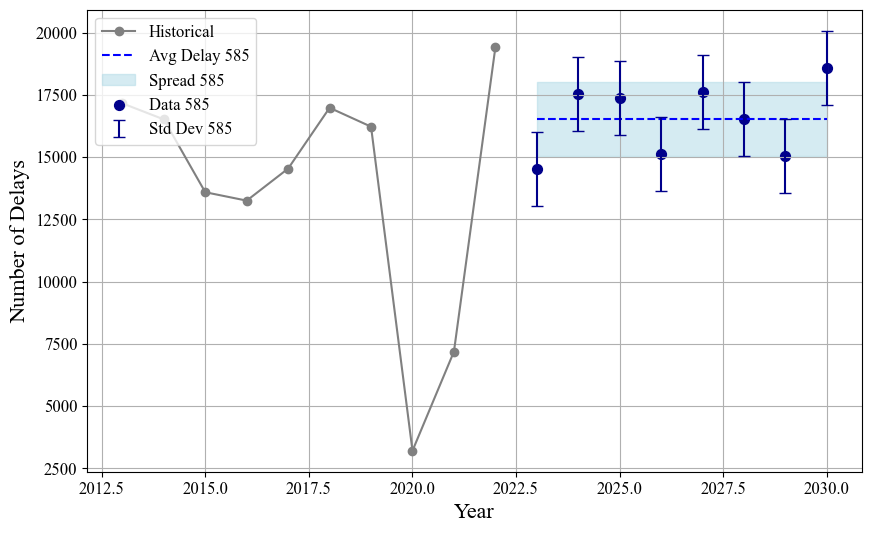

In [437]:
# Plot the delay results - SSP 5.85

# Calculate the average and standard deviation for weather_delays_585
avg_delay_585 = delays_year_df.loc[10:, 'weather_delays_585'].mean()
std_delay_585 = delays_year_df.loc[10:, 'weather_delays_585'].std()

# Plotting
plt.figure(figsize=(10, 6))

# Plot historical values
plt.plot(delays_year_df['year'], delays_year_df['weather_delays_historical'], color='gray', linestyle='-', marker='o', label='Historical')

# Plot average lines and spreads for non-NaN values
plt.plot(delays_year_df.loc[10:, 'year'], [avg_delay_585] * len(delays_year_df.loc[10:]), color='b', linestyle='--', label='Avg Delay 585')
plt.fill_between(delays_year_df.loc[10:, 'year'], avg_delay_585 - std_delay_585, avg_delay_585 + std_delay_585, where=~delays_year_df['weather_delays_585'].isna()[10:], color='lightblue', alpha=0.5, label='Spread 585')

# Plot individual data points
plt.scatter(delays_year_df.loc[10:, 'year'], delays_year_df.loc[10:, 'weather_delays_585'], color='darkblue', label='Data 585', marker='o', s=50)

# Plot error bars for individual data points
plt.errorbar(delays_year_df.loc[10:, 'year'], delays_year_df.loc[10:, 'weather_delays_585'], yerr=std_delay_585, linestyle='', color='darkblue', label='Std Dev 585', capsize=4)

plt.xlabel('Year', fontname='Times New Roman', fontsize=16)
plt.ylabel('Number of Delays', fontname='Times New Roman', fontsize=16)
plt.legend(loc='upper left', title=None)
plt.grid(True)
plt.show()


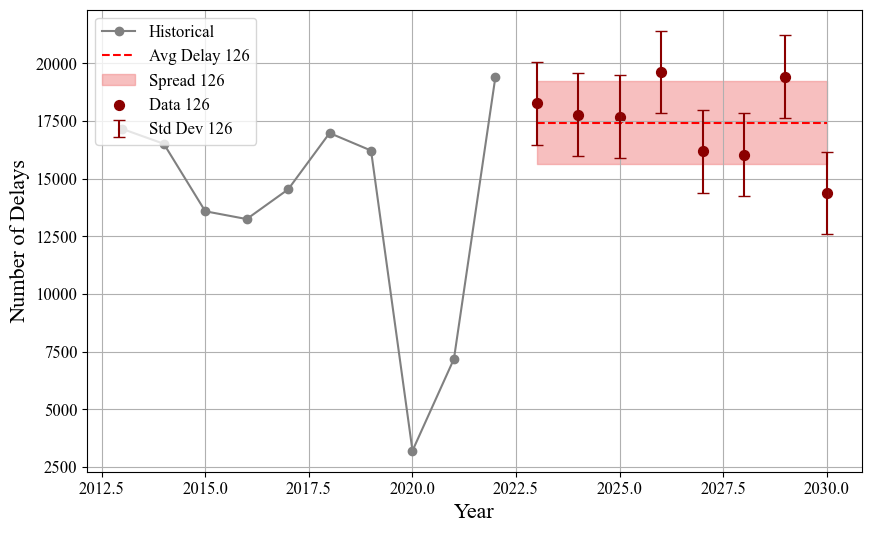

In [438]:
# Plot the delay results - SSP 1.26

# Calculate the average and standard deviation for weather_delays_126
avg_delay_126 = delays_year_df.loc[10:, 'weather_delays_126'].mean()
std_delay_126 = delays_year_df.loc[10:, 'weather_delays_126'].std()

# Plotting
plt.figure(figsize=(10, 6))

# Plot historical values
plt.plot(delays_year_df['year'], delays_year_df['weather_delays_historical'], color='gray', linestyle='-', marker='o', label='Historical')

# Plot average lines and spreads for non-NaN values
plt.plot(delays_year_df.loc[10:, 'year'], [avg_delay_126] * len(delays_year_df.loc[10:]), color='r', linestyle='--', label='Avg Delay 126')
plt.fill_between(delays_year_df.loc[10:, 'year'], avg_delay_126 - std_delay_126, avg_delay_126 + std_delay_126, where=~delays_year_df['weather_delays_126'].isna()[10:], color='lightcoral', alpha=0.5, label='Spread 126')

# Plot individual data points
plt.scatter(delays_year_df.loc[10:, 'year'], delays_year_df.loc[10:, 'weather_delays_126'], color='darkred', label='Data 126', marker='o', s=50)

# Plot error bars for individual data points
plt.errorbar(delays_year_df.loc[10:, 'year'], delays_year_df.loc[10:, 'weather_delays_126'], yerr=std_delay_126, linestyle='', color='darkred', label='Std Dev 126', capsize=4)

plt.xlabel('Year', fontname='Times New Roman', fontsize=16)
plt.ylabel('Number of Delays', fontname='Times New Roman', fontsize=16)
plt.legend(loc='upper left', title=None)
plt.grid(True)
plt.show()


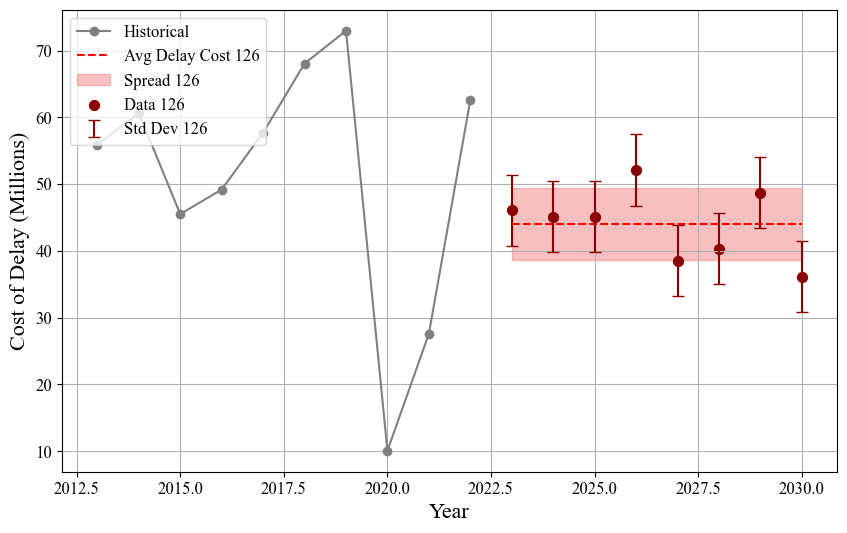

In [439]:
# Plot the delay cost results - SSP 1.26

# Calculate the average and standard deviation for weather_delays_126
avg_cost_126 = cost_year_df.loc[10:, 'Delay Cost 126'].mean()
std_cost_126 = cost_year_df.loc[10:, 'Delay Cost 126'].std()

# Convert cost values to millions
cost_year_df['Delay Cost Historical (Millions)'] = cost_year_df['Delay Cost Historical'] / 1000000
cost_year_df['Delay Cost 126 (Millions)'] = cost_year_df['Delay Cost 126'] / 1000000

# Plotting
plt.figure(figsize=(10, 6))

# Plot historical values
plt.plot(cost_year_df['year'], cost_year_df['Delay Cost Historical (Millions)'], color='gray', linestyle='-', marker='o', label='Historical')

# Plot average line and spread for non-NaN values
plt.plot(cost_year_df.loc[10:, 'year'], [avg_cost_126 / 1000000] * len(cost_year_df.loc[10:]), color='r', linestyle='--', label='Avg Delay Cost 126')
plt.fill_between(cost_year_df.loc[10:, 'year'], (avg_cost_126 - std_cost_126) / 1000000, (avg_cost_126 + std_cost_126) / 1000000, where=~cost_year_df['Delay Cost 126'].isna()[10:], color='lightcoral', alpha=0.5, label='Spread 126')

# Plot individual data points
plt.scatter(cost_year_df.loc[10:, 'year'], cost_year_df.loc[10:, 'Delay Cost 126 (Millions)'], color='darkred', label='Data 126', marker='o', s=50)

# Plot error bars for individual data points
plt.errorbar(cost_year_df.loc[10:, 'year'], cost_year_df.loc[10:, 'Delay Cost 126 (Millions)'], yerr=std_cost_126 / 1000000, linestyle='', color='darkred', label='Std Dev 126', capsize=4)

plt.xlabel('Year', fontname='Times New Roman', fontsize=16)
plt.ylabel('Cost of Delay (Millions)', fontname='Times New Roman', fontsize=16)
plt.legend(loc='upper left', title=None)

plt.grid(True)
plt.show()


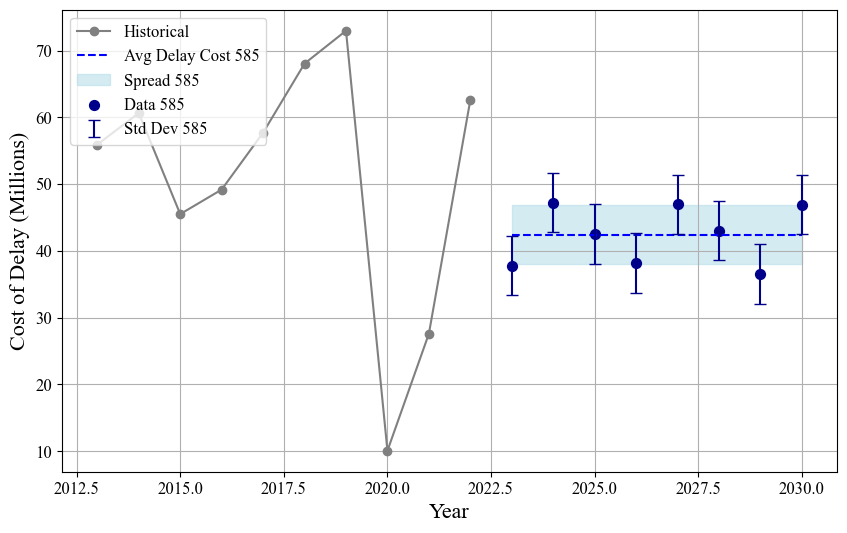

In [440]:
# Plot the delay cost results - SSP 5.85

# Calculate the average and standard deviation for weather_delays_585
avg_cost_585 = cost_year_df.loc[10:, 'Delay Cost 585'].mean()
std_cost_585 = cost_year_df.loc[10:, 'Delay Cost 585'].std()

# Plotting
plt.figure(figsize=(10, 6))

# Plot historical values
plt.plot(cost_year_df['year'], cost_year_df['Delay Cost Historical'] / 1e6, color='gray', linestyle='-', marker='o', label='Historical')  # Divide by 1e6 to convert to millions

# Plot average lines and spreads for non-NaN values
plt.plot(cost_year_df.loc[10:, 'year'], [avg_cost_585 / 1e6] * len(cost_year_df.loc[10:]), color='b', linestyle='--', label='Avg Delay Cost 585')  # Divide by 1e6
plt.fill_between(cost_year_df.loc[10:, 'year'], (avg_cost_585 - std_cost_585) / 1e6, (avg_cost_585 + std_cost_585) / 1e6, where=~cost_year_df['Delay Cost 585'].isna()[10:], color='lightblue', alpha=0.5, label='Spread 585')  # Divide by 1e6

# Plot individual data points
plt.scatter(cost_year_df.loc[10:, 'year'], cost_year_df.loc[10:, 'Delay Cost 585'] / 1e6, color='darkblue', label='Data 585', marker='o', s=50)  # Divide by 1e6

# Plot error bars for individual data points
plt.errorbar(cost_year_df.loc[10:, 'year'], cost_year_df.loc[10:, 'Delay Cost 585'] / 1e6, yerr=std_cost_585 / 1e6, linestyle='', color='darkblue', label='Std Dev 585', capsize=4)  # Divide by 1e6

plt.xlabel('Year', fontname='Times New Roman', fontsize=16)
plt.ylabel('Cost of Delay (Millions)', fontname='Times New Roman', fontsize=16)  # Updated ylabel
plt.legend(loc='upper left', title=None)
plt.grid(True)
plt.show()


In [441]:
# calculate kendall tau and spearman rank correlation for weather delays results

column_126 = delays_year_df['weather_delays_126']
column_585 = delays_year_df['weather_delays_585']

# Drop NaN values from both year and delay columns
valid_data = delays_year_df.dropna(subset=['year', 'weather_delays_126', 'weather_delays_585'])

# Extract valid columns
valid_year = valid_data['year']
valid_126 = valid_data['weather_delays_126']
valid_585 = valid_data['weather_delays_585']

# Calculate Kendall tau and p-value
tau_126, p_value_126 = kendalltau(valid_year, valid_126)

# Calculate Spearman rank correlation and p-value
rho_126, p_value_126_spearman = spearmanr(valid_year, valid_126)

print(f"Kendall tau for weather_delays_126: {tau_126}, p-value: {p_value_126}")
print(f"Spearman rank correlation for weather_delays_126: {rho_126}, p-value: {p_value_126_spearman}")

# Repeat the process for weather_delays_585
tau_585, p_value_585 = kendalltau(valid_year, valid_585)
rho_585, p_value_585_spearman = spearmanr(valid_year, valid_585)

print(f"Kendall tau for weather_delays_585: {tau_585}, p-value: {p_value_585}")
print(f"Spearman rank correlation for weather_delays_585: {rho_585}, p-value: {p_value_585_spearman}")


Kendall tau for weather_delays_126: -0.42857142857142855, p-value: 0.17886904761904762
Spearman rank correlation for weather_delays_126: -0.4285714285714286, p-value: 0.2894032248467901
Kendall tau for weather_delays_585: 0.21428571428571427, p-value: 0.5484126984126985
Spearman rank correlation for weather_delays_585: 0.3571428571428572, p-value: 0.38512064355625636


In [442]:
# calculate kendall tau and spearman rank correlation for weather delay cost results

column_126 = cost_year_df['Delay Cost 126']
column_585 = cost_year_df['Delay Cost 585']

# Drop NaN values from both year and delay columns
valid_data = cost_year_df.dropna(subset=['year', 'Delay Cost 126', 'Delay Cost 585'])

# Extract valid columns
valid_year = valid_data['year']
valid_126 = valid_data['Delay Cost 126']
valid_585 = valid_data['Delay Cost 585']

# Calculate Kendall tau and p-value
tau_126, p_value_126 = kendalltau(valid_year, valid_126)

# Calculate Spearman rank correlation and p-value
rho_126, p_value_126_spearman = spearmanr(valid_year, valid_126)

print(f"Kendall tau for Delay Cost 126: {tau_126}, p-value: {p_value_126}")
print(f"Spearman rank correlation for Delay Cost 126: {rho_126}, p-value: {p_value_126_spearman}")

# Repeat the process for weather_delays_585
tau_585, p_value_585 = kendalltau(valid_year, valid_585)
rho_585, p_value_585_spearman = spearmanr(valid_year, valid_585)

print(f"Kendall tau for Delay Cost 585: {tau_585}, p-value: {p_value_585}")
print(f"Spearman rank correlation for Delay Cost 585: {rho_585}, p-value: {p_value_585_spearman}")


Kendall tau for Delay Cost 126: -0.3571428571428571, p-value: 0.27509920634920637
Spearman rank correlation for Delay Cost 126: -0.4047619047619048, p-value: 0.3198886412288162
Kendall tau for Delay Cost 585: 0.0, p-value: 1.0
Spearman rank correlation for Delay Cost 585: 0.0, p-value: 1.0


In [443]:
# PLotting the cost per carrier

In [444]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2023 = corrected_ssp126_df_2023.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2023['Average_Delay_Cost_Per_Flight'] = grouped_data_2023['sum'] / grouped_data_2023['count']

# Create a new DataFrame with the result
result_df_2023 = grouped_data_2023.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2023)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         263.46
1                AA                         403.14
2                AS                         386.80
3                B6                         428.57
4                DL                         342.12
5                HA                         270.08
6                UA                         505.12
7                YX                         213.82


In [445]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2024 = corrected_ssp126_df_2024.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2024['Average_Delay_Cost_Per_Flight'] = grouped_data_2024['sum'] / grouped_data_2024['count']

# Create a new DataFrame with the result
result_df_2024 = grouped_data_2024.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2024)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         235.09
1                AA                         395.08
2                AS                         364.01
3                B6                         439.22
4                DL                         335.59
5                HA                         262.02
6                UA                         507.28
7                YX                         190.14


In [446]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2025 = corrected_ssp126_df_2025.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2025['Average_Delay_Cost_Per_Flight'] = grouped_data_2025['sum'] / grouped_data_2025['count']

# Create a new DataFrame with the result
result_df_2025 = grouped_data_2025.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2025)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         249.48
1                AA                         415.27
2                AS                         371.28
3                B6                         419.68
4                DL                         328.04
5                HA                         244.24
6                UA                         592.27
7                YX                         206.91


In [447]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2026 = corrected_ssp126_df_2026.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2026['Average_Delay_Cost_Per_Flight'] = grouped_data_2026['sum'] / grouped_data_2026['count']

# Create a new DataFrame with the result
result_df_2026 = grouped_data_2026.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2026)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         306.22
1                AA                         461.29
2                AS                         440.47
3                B6                         464.89
4                DL                         406.23
5                HA                         163.69
6                UA                         688.74
7                YX                         245.11


In [448]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2027 = corrected_ssp126_df_2027.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2027['Average_Delay_Cost_Per_Flight'] = grouped_data_2027['sum'] / grouped_data_2027['count']

# Create a new DataFrame with the result
result_df_2027 = grouped_data_2027.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2027)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         196.06
1                AA                         353.00
2                AS                         332.13
3                B6                         383.13
4                DL                         271.67
5                HA                         203.46
6                UA                         418.70
7                YX                         151.31


In [449]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2028 = corrected_ssp126_df_2028.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2028['Average_Delay_Cost_Per_Flight'] = grouped_data_2028['sum'] / grouped_data_2028['count']

# Create a new DataFrame with the result
result_df_2028 = grouped_data_2028.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2028)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         217.08
1                AA                         371.36
2                AS                         320.14
3                B6                         393.78
4                DL                         290.48
5                HA                         180.58
6                UA                         505.04
7                YX                         157.40


In [450]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2029 = corrected_ssp126_df_2029.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2029['Average_Delay_Cost_Per_Flight'] = grouped_data_2029['sum'] / grouped_data_2029['count']

# Create a new DataFrame with the result
result_df_2029 = grouped_data_2029.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2029)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         279.59
1                AA                         429.87
2                AS                         391.02
3                B6                         455.45
4                DL                         355.39
5                HA                         468.83
6                UA                         609.05
7                YX                         221.87


In [451]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2030 = corrected_ssp126_df_2030.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2030['Average_Delay_Cost_Per_Flight'] = grouped_data_2030['sum'] / grouped_data_2030['count']

# Create a new DataFrame with the result
result_df_2030 = grouped_data_2030.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2030)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         186.39
1                AA                         329.43
2                AS                         325.35
3                B6                         349.29
4                DL                         270.36
5                HA                         187.34
6                UA                         411.15
7                YX                         141.50


In [452]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2030 = corrected_ssp126_df_2030.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2030['Average_Delay_Cost_Per_Flight'] = grouped_data_2030['sum'] / grouped_data_2030['count']

# Create a new DataFrame with the result
result_df_2030 = grouped_data_2030.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2030)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         186.39
1                AA                         329.43
2                AS                         325.35
3                B6                         349.29
4                DL                         270.36
5                HA                         187.34
6                UA                         411.15
7                YX                         141.50


In [453]:
dataframes = [result_df_2023, result_df_2024, result_df_2025, result_df_2026, result_df_2027, result_df_2028, result_df_2029, result_df_2030]

# Concatenate all DataFrames along the rows
merged_df = pd.concat(dataframes, ignore_index=True)

# Group by 'OP_UNIQUE_CARRIER' and calculate the mean for 'Average_Delay_Cost_Per_Flight'
average_delay_by_carrier_SSP126 = merged_df.groupby('OP_UNIQUE_CARRIER')['Average_Delay_Cost_Per_Flight'].mean().reset_index()

# Print the resulting DataFrame
print(average_delay_by_carrier_SSP126)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         241.67
1                AA                         394.81
2                AS                         366.40
3                B6                         416.75
4                DL                         324.98
5                HA                         247.53
6                UA                         529.67
7                YX                         191.01


In [454]:
dataframes = [result_df_2023, result_df_2024, result_df_2025, result_df_2026, result_df_2027, result_df_2028, result_df_2029, result_df_2030]

# Concatenate all DataFrames along the rows
merged_df = pd.concat(dataframes, ignore_index=True)

# Group by 'OP_UNIQUE_CARRIER' and calculate the mean for 'Average_Delay_Cost_Per_Flight'
average_delay_overall_SSP126 = merged_df['Average_Delay_Cost_Per_Flight'].mean()

# Print the resulting DataFrame
print(average_delay_overall_SSP126)


339.10188054134824


In [455]:
# 585

In [456]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2023_585 = corrected_ssp585_df_2023.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2023_585['Average_Delay_Cost_Per_Flight'] = grouped_data_2023_585['sum'] / grouped_data_2023_585['count']

# Create a new DataFrame with the result
result_df_2023_585 = grouped_data_2023_585.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2023_585)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         210.08
1                AA                         341.63
2                AS                         302.38
3                B6                         348.60
4                DL                         292.57
5                HA                         106.84
6                UA                         452.73
7                YX                         167.28


In [457]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2024_585 = corrected_ssp585_df_2024.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2024_585['Average_Delay_Cost_Per_Flight'] = grouped_data_2024_585['sum'] / grouped_data_2024_585['count']

# Create a new DataFrame with the result
result_df_2024_585 = grouped_data_2024_585.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2024_585)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         264.27
1                AA                         423.75
2                AS                         363.52
3                B6                         440.10
4                DL                         345.19
5                HA                         298.01
6                UA                         520.60
7                YX                         228.07


In [458]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2025_585 = corrected_ssp585_df_2025.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2025_585['Average_Delay_Cost_Per_Flight'] = grouped_data_2025_585['sum'] / grouped_data_2025_585['count']

# Create a new DataFrame with the result
result_df_2025_585 = grouped_data_2025_585.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2025_585)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         224.60
1                AA                         372.75
2                AS                         371.88
3                B6                         426.25
4                DL                         291.06
5                HA                         259.26
6                UA                         502.92
7                YX                         172.59


In [459]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2026_585 = corrected_ssp585_df_2026.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2026_585['Average_Delay_Cost_Per_Flight'] = grouped_data_2026_585['sum'] / grouped_data_2026_585['count']

# Create a new DataFrame with the result
result_df_2026_585 = grouped_data_2026_585.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2026_585)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         202.21
1                AA                         358.38
2                AS                         315.49
3                B6                         368.62
4                DL                         274.84
5                HA                         145.25
6                UA                         396.52
7                YX                         159.90


In [460]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2027_585 = corrected_ssp585_df_2027.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2027_585['Average_Delay_Cost_Per_Flight'] = grouped_data_2027_585['sum'] / grouped_data_2027_585['count']

# Create a new DataFrame with the result
result_df_2027_585 = grouped_data_2027_585.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2027_585)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         258.29
1                AA                         425.85
2                AS                         399.58
3                B6                         426.47
4                DL                         370.45
5                HA                         256.06
6                UA                         547.55
7                YX                         210.89


In [461]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2028_585 = corrected_ssp585_df_2028.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2028_585['Average_Delay_Cost_Per_Flight'] = grouped_data_2028_585['sum'] / grouped_data_2028_585['count']

# Create a new DataFrame with the result
result_df_2028_585 = grouped_data_2028_585.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2028_585)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         238.28
1                AA                         395.24
2                AS                         381.91
3                B6                         402.91
4                DL                         316.18
5                HA                         262.90
6                UA                         581.36
7                YX                         181.17


In [462]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2029_585 = corrected_ssp585_df_2029.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2029_585['Average_Delay_Cost_Per_Flight'] = grouped_data_2029_585['sum'] / grouped_data_2029_585['count']

# Create a new DataFrame with the result
result_df_2029_585 = grouped_data_2029_585.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2029_585)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         184.15
1                AA                         336.92
2                AS                         342.17
3                B6                         365.28
4                DL                         261.20
5                HA                         180.16
6                UA                         487.19
7                YX                         124.60


In [463]:
# Group by 'OP_UNIQUE_CARRIER' and calculate the sum of 'Predicted_Delay_Cost' and count of occurrences
grouped_data_2030_585 = corrected_ssp585_df_2030.groupby('OP_UNIQUE_CARRIER')['Predicted_Delay_Cost'].agg(['sum', 'count'])

# Calculate the average delay cost per flight
grouped_data_2030_585['Average_Delay_Cost_Per_Flight'] = grouped_data_2030_585['sum'] / grouped_data_2030_585['count']

# Create a new DataFrame with the result
result_df_2030_585 = grouped_data_2030_585.reset_index()[['OP_UNIQUE_CARRIER', 'Average_Delay_Cost_Per_Flight']]

# Display or use the result_df as needed
print(result_df_2030_585)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         275.94
1                AA                         412.23
2                AS                         377.33
3                B6                         446.11
4                DL                         334.44
5                HA                         153.29
6                UA                         532.79
7                YX                         209.69


In [464]:
dataframes_585 = [result_df_2023_585, result_df_2024_585, result_df_2025_585, result_df_2026_585, result_df_2027_585, result_df_2028_585, result_df_2029_585, result_df_2030_585]

# Concatenate all DataFrames along the rows
merged_df_585 = pd.concat(dataframes_585, ignore_index=True)

# Group by 'OP_UNIQUE_CARRIER' and calculate the mean for 'Average_Delay_Cost_Per_Flight'
average_delay_by_carrier_SSP585 = merged_df_585.groupby('OP_UNIQUE_CARRIER')['Average_Delay_Cost_Per_Flight'].mean().reset_index()

# Print the resulting DataFrame
print(average_delay_by_carrier_SSP585)


  OP_UNIQUE_CARRIER  Average_Delay_Cost_Per_Flight
0                9E                         232.23
1                AA                         383.34
2                AS                         356.78
3                B6                         403.04
4                DL                         310.74
5                HA                         207.72
6                UA                         502.71
7                YX                         181.77


In [465]:
dataframes_585 = [result_df_2023_585, result_df_2024_585, result_df_2025_585, result_df_2026_585, result_df_2027_585, result_df_2028_585, result_df_2029_585, result_df_2030_585]

# Concatenate all DataFrames along the rows
merged_df_585 = pd.concat(dataframes_585, ignore_index=True)

# Calculate the mean for 'Average_Delay_Cost_Per_Flight' across all rows
average_delay_overall_SSP585 = merged_df_585['Average_Delay_Cost_Per_Flight'].mean()

# Print the resulting mean value
print("Overall Average Delay Cost Per Flight (SSP585):", average_delay_overall_SSP585)


Overall Average Delay Cost Per Flight (SSP585): 322.2920676429957


In [466]:
# Calculate by what percentage pices need to be increased to cover the average delay cost - SSP 5.85
311.1 /  416.17 *100

74.75310570199679

In [467]:
# Calculate by what percentage pices need to be increased to cover the average delay cost - SSP 1.26
320.68 / 416.17*100

77.05504961914602

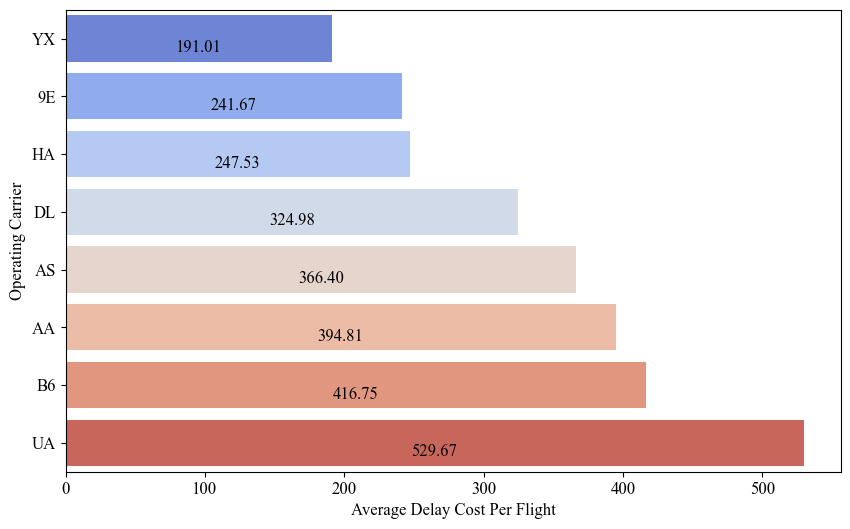

In [468]:
# PLot the average Delay Cost Per Flight by Carrier (SSP126)

# Sort the DataFrame by 'Average_Delay_Cost_Per_Flight' in ascending order
average_delay_by_carrier_SSP126_sorted = average_delay_by_carrier_SSP126.sort_values(by='Average_Delay_Cost_Per_Flight')

# Set the color palette for the plot
colors = sns.color_palette("coolwarm", len(average_delay_by_carrier_SSP126_sorted))

# Plot the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Average_Delay_Cost_Per_Flight', y='OP_UNIQUE_CARRIER', data=average_delay_by_carrier_SSP126_sorted, palette=colors)

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.xlabel('Average Delay Cost Per Flight')
plt.ylabel('Operating Carrier')
#plt.title('Average Delay Cost Per Flight by Carrier (SSP126)')

# Show the plot
plt.show()


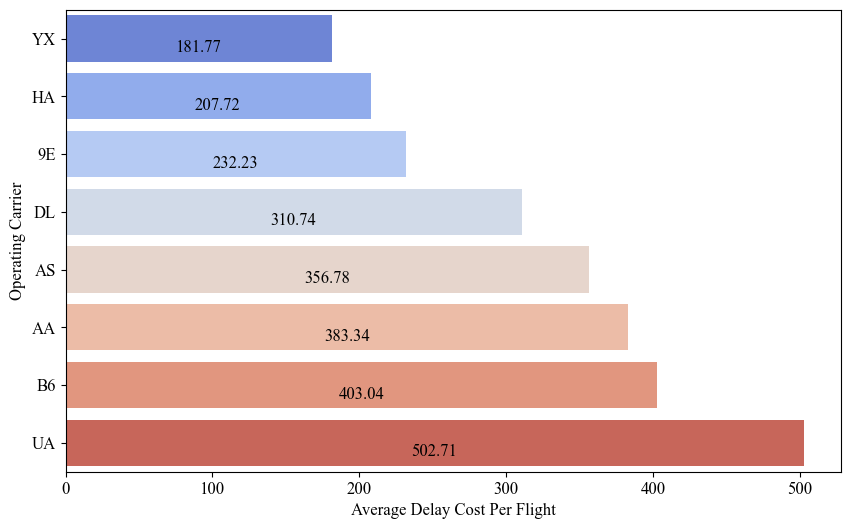

In [469]:
# PLot the average Delay Cost Per Flight by Carrier (SSP585)

# Sort the DataFrame by 'Average_Delay_Cost_Per_Flight' in ascending order
average_delay_by_carrier_SSP585_sorted = average_delay_by_carrier_SSP585.sort_values(by='Average_Delay_Cost_Per_Flight')

# Set the color palette for the plot
colors = sns.color_palette("coolwarm", len(average_delay_by_carrier_SSP585_sorted))

# Plot the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Average_Delay_Cost_Per_Flight', y='OP_UNIQUE_CARRIER', data=average_delay_by_carrier_SSP585_sorted, palette=colors)

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.xlabel('Average Delay Cost Per Flight')
plt.ylabel('Operating Carrier')

# Show the plot
plt.show()


In [470]:
# Comparing delay percentage of departure times

In [471]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp126_df_2023['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp126_df_2023['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_126_23 = corrected_ssp126_df_2023.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_126_23['year'] = 2023

avg_delays_per_hour_126_23['data'] = '126'

# Display the resulting DataFrame
print(avg_delays_per_hour_126_23)

    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.21                476.61  2023  126
1              6             0.12                289.94  2023  126
2              7             0.09                251.25  2023  126
3              8             0.12                336.86  2023  126
4              9             0.11                291.07  2023  126
5             10             0.13                361.54  2023  126
6             11             0.09                207.83  2023  126
7             12             0.09                205.32  2023  126
8             13             0.14                327.14  2023  126
9             14             0.12                302.43  2023  126
10            15             0.15                417.85  2023  126
11            16             0.15                437.87  2023  126
12            17             0.17                441.93  2023  126
13            18             0.17                448.52  2023 

In [472]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp126_df_2024['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp126_df_2024['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_126_24 = corrected_ssp126_df_2024.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_126_24['year'] = 2024

avg_delays_per_hour_126_24['data'] = '126'

# Display the resulting DataFrame
print(avg_delays_per_hour_126_24)


    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.27                600.42  2024  126
1              6             0.14                337.22  2024  126
2              7             0.11                310.54  2024  126
3              8             0.13                366.50  2024  126
4              9             0.12                307.68  2024  126
5             10             0.14                386.36  2024  126
6             11             0.09                222.35  2024  126
7             12             0.09                213.73  2024  126
8             13             0.13                307.39  2024  126
9             14             0.11                271.33  2024  126
10            15             0.14                381.50  2024  126
11            16             0.14                396.56  2024  126
12            17             0.16                422.06  2024  126
13            18             0.15                394.86  2024 

In [473]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp126_df_2025['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp126_df_2025['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_126_25 = corrected_ssp126_df_2025.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_126_25['year'] = 2025

avg_delays_per_hour_126_25['data'] = '126'

# Display the resulting DataFrame
print(avg_delays_per_hour_126_25)

    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.22                483.83  2025  126
1              6             0.12                287.29  2025  126
2              7             0.10                266.23  2025  126
3              8             0.12                326.19  2025  126
4              9             0.12                286.33  2025  126
5             10             0.12                336.09  2025  126
6             11             0.09                214.75  2025  126
7             12             0.09                213.80  2025  126
8             13             0.13                303.77  2025  126
9             14             0.12                300.98  2025  126
10            15             0.14                387.46  2025  126
11            16             0.15                425.69  2025  126
12            17             0.17                473.44  2025  126
13            18             0.15                429.97  2025 

In [474]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp126_df_2026['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp126_df_2026['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_126_26 = corrected_ssp126_df_2026.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_126_26['year'] = 2026

avg_delays_per_hour_126_26['data'] = '126'

# Display the resulting DataFrame
print(avg_delays_per_hour_126_26)

    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.22                480.79  2026  126
1              6             0.12                294.08  2026  126
2              7             0.10                272.07  2026  126
3              8             0.13                338.77  2026  126
4              9             0.12                288.99  2026  126
5             10             0.14                376.37  2026  126
6             11             0.10                233.77  2026  126
7             12             0.10                235.04  2026  126
8             13             0.15                342.26  2026  126
9             14             0.13                315.83  2026  126
10            15             0.17                457.61  2026  126
11            16             0.17                533.01  2026  126
12            17             0.19                569.76  2026  126
13            18             0.19                579.08  2026 

In [475]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp126_df_2027['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp126_df_2027['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_126_27 = corrected_ssp126_df_2027.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_126_27['year'] = 2027

avg_delays_per_hour_126_27['data'] = '126'

# Display the resulting DataFrame
print(avg_delays_per_hour_126_27)

    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.24                501.86  2027  126
1              6             0.12                279.46  2027  126
2              7             0.10                255.36  2027  126
3              8             0.12                297.93  2027  126
4              9             0.11                252.21  2027  126
5             10             0.12                306.03  2027  126
6             11             0.08                170.14  2027  126
7             12             0.08                177.66  2027  126
8             13             0.13                278.31  2027  126
9             14             0.10                236.86  2027  126
10            15             0.13                318.82  2027  126
11            16             0.13                345.22  2027  126
12            17             0.15                367.77  2027  126
13            18             0.14                355.28  2027 

In [476]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp126_df_2028['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp126_df_2028['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_126_28 = corrected_ssp126_df_2028.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_126_28['year'] = 2028

avg_delays_per_hour_126_28['data'] = '126'

# Display the resulting DataFrame
print(avg_delays_per_hour_126_28)

    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.23                507.51  2028  126
1              6             0.11                276.30  2028  126
2              7             0.09                237.96  2028  126
3              8             0.11                291.57  2028  126
4              9             0.11                260.24  2028  126
5             10             0.12                317.08  2028  126
6             11             0.08                186.19  2028  126
7             12             0.08                185.00  2028  126
8             13             0.12                275.47  2028  126
9             14             0.11                261.43  2028  126
10            15             0.13                351.53  2028  126
11            16             0.13                380.04  2028  126
12            17             0.15                411.61  2028  126
13            18             0.14                401.50  2028 

In [477]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp126_df_2029['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp126_df_2029['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_126_29 = corrected_ssp126_df_2029.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_126_29['year'] = 2029

avg_delays_per_hour_126_29['data'] = '126'

# Display the resulting DataFrame
print(avg_delays_per_hour_126_29)

    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.26                535.07  2029  126
1              6             0.13                290.35  2029  126
2              7             0.10                250.01  2029  126
3              8             0.13                320.23  2029  126
4              9             0.12                290.82  2029  126
5             10             0.14                369.38  2029  126
6             11             0.10                225.22  2029  126
7             12             0.10                225.57  2029  126
8             13             0.14                311.84  2029  126
9             14             0.13                282.89  2029  126
10            15             0.16                423.79  2029  126
11            16             0.16                485.18  2029  126
12            17             0.18                526.93  2029  126
13            18             0.18                513.51  2029 

In [478]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp126_df_2030['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp126_df_2030['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_126_30 = corrected_ssp126_df_2030.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_126_30['year'] = 2030

avg_delays_per_hour_126_30['data'] = '126'

# Display the resulting DataFrame
print(avg_delays_per_hour_126_30)

    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.23                491.25  2030  126
1              6             0.11                261.26  2030  126
2              7             0.08                229.13  2030  126
3              8             0.11                300.32  2030  126
4              9             0.10                248.63  2030  126
5             10             0.11                312.31  2030  126
6             11             0.07                181.44  2030  126
7             12             0.07                169.82  2030  126
8             13             0.11                231.82  2030  126
9             14             0.09                205.54  2030  126
10            15             0.11                279.96  2030  126
11            16             0.12                336.73  2030  126
12            17             0.13                342.29  2030  126
13            18             0.12                336.55  2030 

In [479]:
# create a list containing your DataFrames
dfs = [avg_delays_per_hour_126_23, avg_delays_per_hour_126_24, avg_delays_per_hour_126_25,
       avg_delays_per_hour_126_26, avg_delays_per_hour_126_27, avg_delays_per_hour_126_28,
       avg_delays_per_hour_126_29, avg_delays_per_hour_126_30]

# Concatenate all DataFrames into one
df_concatenated = pd.concat(dfs)

# Group by CRS_DEP_TIME and calculate the mean of Weather_Delayed
result_df = df_concatenated.groupby('CRS_DEP_TIME')['Weather_Delayed'].mean().reset_index()

# Display the result
print(result_df)

    CRS_DEP_TIME  Weather_Delayed
0              5             0.23
1              6             0.12
2              7             0.10
3              8             0.12
4              9             0.11
5             10             0.13
6             11             0.09
7             12             0.09
8             13             0.13
9             14             0.11
10            15             0.14
11            16             0.14
12            17             0.16
13            18             0.15
14            19             0.13
15            20             0.20
16            21             0.17
17            22             0.17
18            23             0.18


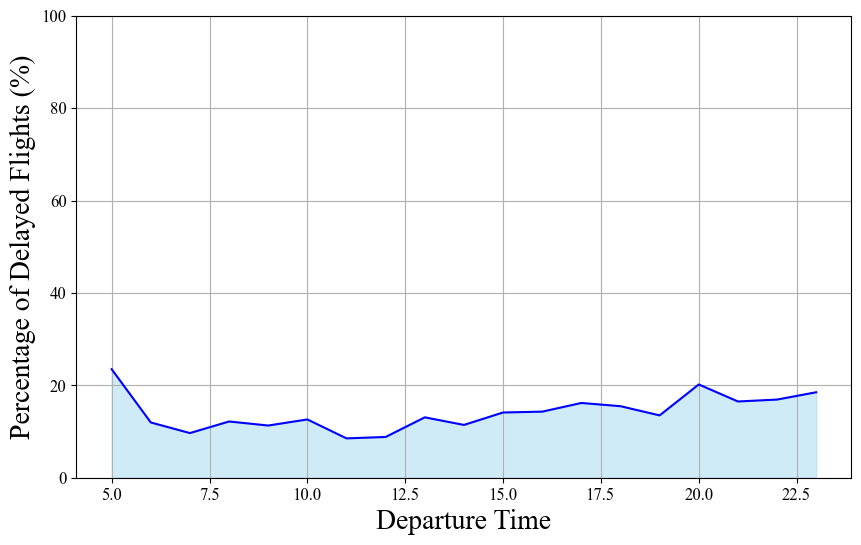

In [480]:
# result_df is the DataFrame with average Weather_Delayed values
result_df['Weather_Delayed_percentage'] = result_df['Weather_Delayed'] * 100

plt.figure(figsize=(10, 6))

# Plot the line and fill the area under the curve
plt.fill_between(result_df['CRS_DEP_TIME'], result_df['Weather_Delayed_percentage'], color='skyblue', alpha=0.4)
plt.plot(result_df['CRS_DEP_TIME'], result_df['Weather_Delayed_percentage'], linestyle='-', color='b')

#plt.title('Percentage of Delayed Flights Over Time', fontdict={'fontname': 'Times New Roman', 'fontsize': 16})
plt.xlabel('Departure Time', fontdict={'fontname': 'Times New Roman', 'fontsize': 20})
plt.ylabel('Percentage of Delayed Flights (%)', fontdict={'fontname': 'Times New Roman', 'fontsize': 20})
plt.ylim(0, 100)
plt.grid(True)
plt.show()


In [481]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp585_df_2023['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp585_df_2023['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_585_23 = corrected_ssp585_df_2023.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_585_23['year'] = 2023

avg_delays_per_hour_585_23['data'] = '585'

# Display the resulting DataFrame
print(avg_delays_per_hour_585_23)


    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.20                451.40  2023  585
1              6             0.10                227.89  2023  585
2              7             0.08                209.88  2023  585
3              8             0.10                255.46  2023  585
4              9             0.09                218.86  2023  585
5             10             0.10                273.56  2023  585
6             11             0.06                149.04  2023  585
7             12             0.07                162.11  2023  585
8             13             0.11                240.37  2023  585
9             14             0.09                220.15  2023  585
10            15             0.11                329.77  2023  585
11            16             0.12                376.84  2023  585
12            17             0.13                399.51  2023  585
13            18             0.13                407.54  2023 

In [482]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp585_df_2024['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp585_df_2024['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_585_24 = corrected_ssp585_df_2024.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_585_24['year'] = 2024

avg_delays_per_hour_585_24['data'] = '585'

# Display the resulting DataFrame
print(avg_delays_per_hour_585_24)


    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.27                590.48  2024  585
1              6             0.13                328.16  2024  585
2              7             0.10                308.98  2024  585
3              8             0.13                401.18  2024  585
4              9             0.12                338.12  2024  585
5             10             0.14                426.13  2024  585
6             11             0.09                247.79  2024  585
7             12             0.09                222.25  2024  585
8             13             0.13                309.99  2024  585
9             14             0.12                298.60  2024  585
10            15             0.15                399.36  2024  585
11            16             0.14                414.43  2024  585
12            17             0.15                420.26  2024  585
13            18             0.13                388.17  2024 

In [483]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp585_df_2025['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp585_df_2025['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_585_25 = corrected_ssp585_df_2025.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_585_25['year'] = 2025

avg_delays_per_hour_585_25['data'] = '585'

# Display the resulting DataFrame
print(avg_delays_per_hour_585_25)


    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.28                624.77  2025  585
1              6             0.12                304.33  2025  585
2              7             0.08                237.72  2025  585
3              8             0.11                304.89  2025  585
4              9             0.11                279.77  2025  585
5             10             0.12                338.59  2025  585
6             11             0.08                200.02  2025  585
7             12             0.08                192.23  2025  585
8             13             0.13                298.97  2025  585
9             14             0.12                266.82  2025  585
10            15             0.14                364.88  2025  585
11            16             0.15                395.06  2025  585
12            17             0.17                418.91  2025  585
13            18             0.15                388.49  2025 

In [484]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp585_df_2026['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp585_df_2026['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_585_26 = corrected_ssp585_df_2026.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_585_26['year'] = 2026

avg_delays_per_hour_585_26['data'] = '585'

# Display the resulting DataFrame
print(avg_delays_per_hour_585_26)


    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.22                474.21  2026  585
1              6             0.11                270.84  2026  585
2              7             0.08                229.28  2026  585
3              8             0.11                287.68  2026  585
4              9             0.10                252.93  2026  585
5             10             0.11                322.20  2026  585
6             11             0.07                176.33  2026  585
7             12             0.08                177.24  2026  585
8             13             0.11                262.79  2026  585
9             14             0.10                241.45  2026  585
10            15             0.12                300.53  2026  585
11            16             0.12                339.58  2026  585
12            17             0.13                351.39  2026  585
13            18             0.13                368.38  2026 

In [485]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp585_df_2027['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp585_df_2027['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_585_27 = corrected_ssp585_df_2027.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_585_27['year'] = 2027

avg_delays_per_hour_585_27['data'] = '585'

# Display the resulting DataFrame
print(avg_delays_per_hour_585_27)


    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.24                538.12  2027  585
1              6             0.12                283.44  2027  585
2              7             0.10                296.21  2027  585
3              8             0.12                355.11  2027  585
4              9             0.11                299.46  2027  585
5             10             0.12                365.33  2027  585
6             11             0.09                235.30  2027  585
7             12             0.08                211.89  2027  585
8             13             0.13                304.13  2027  585
9             14             0.11                276.16  2027  585
10            15             0.14                399.97  2027  585
11            16             0.15                443.84  2027  585
12            17             0.16                444.01  2027  585
13            18             0.16                478.56  2027 

In [486]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp585_df_2028['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp585_df_2028['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_585_28 = corrected_ssp585_df_2028.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_585_28['year'] = 2028

avg_delays_per_hour_585_28['data'] = '585'

# Display the resulting DataFrame
print(avg_delays_per_hour_585_28)


    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.23                515.84  2028  585
1              6             0.10                237.88  2028  585
2              7             0.09                224.67  2028  585
3              8             0.11                281.43  2028  585
4              9             0.10                248.34  2028  585
5             10             0.11                307.30  2028  585
6             11             0.08                179.17  2028  585
7             12             0.08                182.01  2028  585
8             13             0.13                296.91  2028  585
9             14             0.12                293.48  2028  585
10            15             0.14                391.52  2028  585
11            16             0.15                455.18  2028  585
12            17             0.16                455.78  2028  585
13            18             0.15                453.10  2028 

In [487]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp585_df_2029['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp585_df_2029['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_585_29 = corrected_ssp585_df_2029.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_585_29['year'] = 2029

avg_delays_per_hour_585_29['data'] = '585'

# Display the resulting DataFrame
print(avg_delays_per_hour_585_29)


    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.24                547.24  2029  585
1              6             0.10                242.43  2029  585
2              7             0.08                197.86  2029  585
3              8             0.10                265.57  2029  585
4              9             0.10                244.60  2029  585
5             10             0.11                294.60  2029  585
6             11             0.07                165.69  2029  585
7             12             0.07                154.19  2029  585
8             13             0.11                257.41  2029  585
9             14             0.10                232.81  2029  585
10            15             0.13                334.85  2029  585
11            16             0.13                352.06  2029  585
12            17             0.14                359.16  2029  585
13            18             0.13                339.02  2029 

In [488]:
# Convert CRS_DEP_TIME to datetime format
corrected_ssp585_df_2030['CRS_DEP_TIME'] = pd.to_datetime(corrected_ssp585_df_2030['CRS_DEP_TIME'], format='%H%M').dt.hour

# Group by departure time and calculate average delays
avg_delays_per_hour_585_30 = corrected_ssp585_df_2030.groupby('CRS_DEP_TIME')['Weather_Delayed', 'Predicted_Delay_Cost'].mean().reset_index()

avg_delays_per_hour_585_30['year'] = 2030

avg_delays_per_hour_585_30['data'] = '585'

# Display the resulting DataFrame
print(avg_delays_per_hour_585_30)


    CRS_DEP_TIME  Weather_Delayed  Predicted_Delay_Cost  year data
0              5             0.25                565.95  2030  585
1              6             0.12                294.56  2030  585
2              7             0.09                245.66  2030  585
3              8             0.13                349.88  2030  585
4              9             0.12                318.62  2030  585
5             10             0.14                399.36  2030  585
6             11             0.10                226.28  2030  585
7             12             0.09                226.87  2030  585
8             13             0.14                320.87  2030  585
9             14             0.13                316.45  2030  585
10            15             0.15                402.25  2030  585
11            16             0.16                451.10  2030  585
12            17             0.17                468.75  2030  585
13            18             0.17                458.71  2030 

In [489]:
# create a list containing your DataFrames
dfs = [avg_delays_per_hour_585_23, avg_delays_per_hour_585_24, avg_delays_per_hour_585_25,
       avg_delays_per_hour_585_26, avg_delays_per_hour_585_27, avg_delays_per_hour_585_28,
       avg_delays_per_hour_585_29, avg_delays_per_hour_585_30]

# Concatenate all DataFrames into one
df_concatenated = pd.concat(dfs)

# Group by CRS_DEP_TIME and calculate the mean of Weather_Delayed
result_df = df_concatenated.groupby('CRS_DEP_TIME')['Weather_Delayed'].mean().reset_index()

# Display the result
print(result_df)


    CRS_DEP_TIME  Weather_Delayed
0              5             0.24
1              6             0.11
2              7             0.09
3              8             0.11
4              9             0.11
5             10             0.12
6             11             0.08
7             12             0.08
8             13             0.12
9             14             0.11
10            15             0.14
11            16             0.14
12            17             0.15
13            18             0.15
14            19             0.13
15            20             0.19
16            21             0.16
17            22             0.17
18            23             0.19


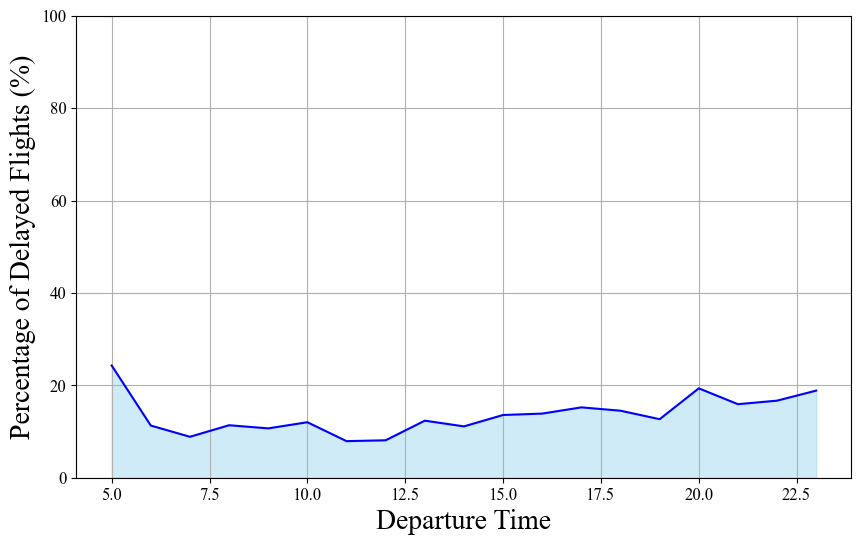

In [490]:
# Assuming result_df is the DataFrame with average Weather_Delayed values
result_df['Weather_Delayed_percentage'] = result_df['Weather_Delayed'] * 100

plt.figure(figsize=(10, 6))

# Plot the line and fill the area under the curve
plt.fill_between(result_df['CRS_DEP_TIME'], result_df['Weather_Delayed_percentage'], color='skyblue', alpha=0.4)
plt.plot(result_df['CRS_DEP_TIME'], result_df['Weather_Delayed_percentage'], linestyle='-', color='b')

#plt.title('Percentage of Delayed Flights Over Time', fontdict={'fontname': 'Times New Roman', 'fontsize': 16})
plt.xlabel('Departure Time', fontdict={'fontname': 'Times New Roman', 'fontsize': 20})
plt.ylabel('Percentage of Delayed Flights (%)', fontdict={'fontname': 'Times New Roman', 'fontsize': 20})
plt.ylim(0, 100)
plt.grid(True)
plt.show()


In [491]:
# Formulas

$\text{Profit} = \text{Revenue} - \text{Cost}$


\[ \text{Profit} = \text{Revenue} - \text{Cost} \]

$\text{Profit} = \text{Selling Price} \times \text{Quantity Sold} - \text{Cost}$